In [1]:
import numpy as np
import const
import utilities as ut
import matplotlib.pyplot as plt
import datetime
import joblib
from tqdm import tqdm
import math

import gym
import ctfsql
import evaluate

In [2]:
from typing import Mapping, Any

import numpy as np
from ctfsql.agents.random_agent import Agent


class RandomAgent(Agent):
    """ Agent that randomly selects a command from the admissible ones. """
    def __init__(self, seed=1234):
        self.seed = seed
        self.rng = np.random.RandomState(self.seed)
    
    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]):
        command_id = np.random.randint(0, len(infos["admissible_commands"]))
        command = infos["admissible_commands"][command_id]
        return command_id,  command

In [2]:
import os
from glob import glob

import torch
from tqdm import tqdm


def run_episode(agent, max_step=2000, nb_episodes=10, verbose=True):

    torch.manual_seed(20211021)  # For reproducibility when using action sampling.

    env = gym.make('ctfsql-v0')

    # Collect some statistics: nb_steps, final reward.
    steps, mean_scores, norm_scores = [], [], []
    for no_episode in tqdm(range(nb_episodes)):
        obs, infos = env.reset()  # Start new episode.

        score = 0
        sum_score = 0
        done = False
        nb_steps = 0
        print(env.url)
        while not done and nb_steps <= max_step:
            command_id, command = agent.act(obs, score, done, infos)
            obs, score, done, infos = env.step(command_id, command)
            
#             if infos['description'] == 'Successfully get table names in the database.':
#                 for i, a in enumerate(infos['admissible_commands']):
#                     print(i, a)

            nb_steps += 1
            sum_score += score
        agent.act(obs, score, done, infos)  # Let the agent know the game is done.

        steps.append(nb_steps)
        mean_score = round(np.mean(sum_score), 3)
        mean_scores.append(mean_score)
        if verbose:
            print('ステップ数:{0}, 平均報酬:{1}'.format(nb_steps, mean_score))

#         print(steps, mean_scores)

    env.close()
    return agent, steps, mean_scores
#     timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
#     joblib.dump(agent,'ignore_simul2_'+timestamp+'.pkl', compress=True)
#     train_data = joblib.load('ignore_simul2_20211203102304978989.pkl')
    


In [3]:
from ctfsql.agents.agent import NeuralAgent
agent = NeuralAgent()
agent.train()
run_episode(agent)
# trained_agent, steps, mean_scores = run_episode(agent)

  0%|          | 0/10 [00:00<?, ?it/s]

http://127.0.0.1/ctf_2/ctf_2_3.php
   100. reward: -0.011  policy: -0.235  value:  0.007  entropy:  4.680  confidence:  0.010  score:  0  vocab: 384
   200. reward:  0.000  policy: -0.097  value:  0.001  entropy:  4.979  confidence:  0.007  score: -1  vocab: 459
   300. reward:  0.000  policy: -0.024  value:  0.000  entropy:  5.060  confidence:  0.006  score: -1  vocab: 472


 10%|█         | 1/10 [01:46<15:59, 106.62s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_3/ctf_3_5.php
   400. reward: -0.011  policy: -0.030  value:  0.008  entropy:  4.570  confidence:  0.012  score: 10  vocab: 505


 20%|██        | 2/10 [02:01<10:32, 79.07s/it] 

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_4/ctf_4_3.php
   500. reward: -0.011  policy:  0.002  value:  0.008  entropy:  4.683  confidence:  0.010  score: 10  vocab: 511
   600. reward:  0.000  policy:  0.040  value:  0.000  entropy:  4.475  confidence:  0.013  score: -1  vocab: 511
   700. reward:  0.000  policy:  0.026  value:  0.000  entropy:  4.935  confidence:  0.007  score: -1  vocab: 511
   800. reward:  0.000  policy:  0.011  value:  0.000  entropy:  5.027  confidence:  0.007  score: -1  vocab: 511


 30%|███       | 3/10 [03:05<08:41, 74.43s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_4/ctf_4_4.php
   900. reward:  0.211  policy:  5.023  value:  6.055  entropy:  4.746  confidence:  0.009  score: 10  vocab: 511
  1000. reward:  0.000  policy: -0.129  value:  0.000  entropy:  4.940  confidence:  0.007  score: -1  vocab: 511
  1100. reward:  0.000  policy: -0.175  value:  0.001  entropy:  5.021  confidence:  0.007  score: -1  vocab: 511
  1200. reward:  0.000  policy: -0.173  value:  0.001  entropy:  5.055  confidence:  0.006  score: -1  vocab: 511
  1300. reward:  0.000  policy: -0.187  value:  0.001  entropy:  5.077  confidence:  0.006  score: -1  vocab: 511
  1400. reward:  0.000  policy: -0.164  value:  0.001  entropy:  5.091  confidence:  0.006  score: -1  vocab: 511
  1500. reward:  0.000  policy: -0.147  value:  0.000  entropy:  5.100  confidence:  0.006  score: -1  vocab: 511


 40%|████      | 4/10 [06:56<12:09, 121.59s/it]

ステップ数:780, 平均報酬:-769.0
http://127.0.0.1/ctf_4/ctf_4_5.php
  1600. reward:  0.211  policy:  5.060  value:  6.034  entropy:  5.061  confidence:  0.007  score: 10  vocab: 528


 50%|█████     | 5/10 [07:01<07:12, 86.47s/it] 

ステップ数:28, 平均報酬:-17.0
http://127.0.0.1/ctf_1/ctf_1_2.php
  1700. reward:  0.211  policy:  2.259  value:  5.034  entropy:  4.070  confidence:  0.019  score: 10  vocab: 536
  1800. reward:  0.000  policy: -0.222  value:  0.001  entropy:  4.895  confidence:  0.007  score: -1  vocab: 536
  1900. reward:  0.000  policy: -0.294  value:  0.002  entropy:  5.005  confidence:  0.007  score: -1  vocab: 536
  2000. reward:  0.000  policy: -0.286  value:  0.002  entropy:  5.050  confidence:  0.006  score: -1  vocab: 536
  2100. reward:  0.000  policy: -0.301  value:  0.002  entropy:  5.068  confidence:  0.006  score: -1  vocab: 536


 60%|██████    | 6/10 [09:29<07:00, 105.15s/it]

ステップ数:538, 平均報酬:-527.0
http://127.0.0.1/ctf_2/ctf_2_4.php
  2200. reward:  0.211  policy:  2.340  value:  4.450  entropy:  4.612  confidence:  0.012  score: 10  vocab: 536
  2300. reward:  0.000  policy: -0.141  value:  0.001  entropy:  4.461  confidence:  0.013  score: -1  vocab: 536
  2400. reward:  0.000  policy: -0.315  value:  0.003  entropy:  4.955  confidence:  0.007  score: -1  vocab: 536


 70%|███████   | 7/10 [10:52<04:55, 98.51s/it] 

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_2/ctf_2_2.php
  2500. reward:  0.211  policy:  4.698  value:  5.974  entropy:  4.973  confidence:  0.007  score: 10  vocab: 536
  2600. reward:  0.000  policy: -0.223  value:  0.002  entropy:  4.155  confidence:  0.017  score: -1  vocab: 536
  2700. reward:  0.000  policy: -0.358  value:  0.003  entropy:  4.905  confidence:  0.007  score: -1  vocab: 536
  2800. reward:  0.000  policy: -0.447  value:  0.005  entropy:  5.009  confidence:  0.007  score: -1  vocab: 536


 80%|████████  | 8/10 [12:07<03:02, 91.19s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_3/ctf_3_4.php
  2900. reward:  0.211  policy:  4.494  value:  5.906  entropy:  4.180  confidence:  0.018  score: 10  vocab: 536
  3000. reward:  0.000  policy: -0.348  value:  0.003  entropy:  4.732  confidence:  0.009  score: -1  vocab: 536


 90%|█████████ | 9/10 [12:55<01:18, 78.37s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_1/ctf_1_4.php
  3100. reward:  0.211  policy:  3.507  value:  5.571  entropy:  4.838  confidence:  0.009  score: 10  vocab: 536
  3200. reward:  0.000  policy: -0.435  value:  0.005  entropy:  4.618  confidence:  0.011  score: -1  vocab: 536


100%|██████████| 10/10 [13:30<00:00, 81.02s/it]

ステップ数:156, 平均報酬:-145.0


(<ctfsql.agents.agent.NeuralAgent at 0x7fc8d8126090>,
 [340, 139, 333, 780, 28, 538, 328, 337, 255, 156],
 [-329.0,
  -128.0,
  -322.0,
  -769.0,
  -17.0,
  -527.0,
  -317.0,
  -326.0,
  -244.0,
  -145.0])

In [21]:
from ctfsql.agents.agent import NeuralAgent
agent = NeuralAgent()
trained_agent, steps, mean_scores = run_episode(agent)

  0%|          | 0/10 [00:00<?, ?it/s]

http://127.0.0.1/ctf_3/ctf_3_5.php


KeyboardInterrupt: 

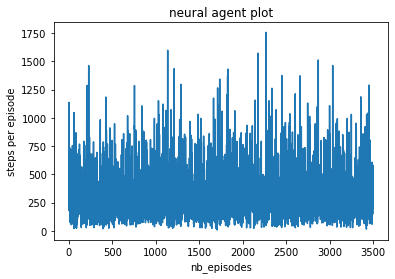

In [42]:
fig = plt.figure()
plt.plot(steps)
plt.title('neural agent plot')
plt.xlabel('nb_episodes')
plt.ylabel('steps per episode')
fig.savefig("nn_agent.png")

Text(0, 0.5, 'nb_episodes')

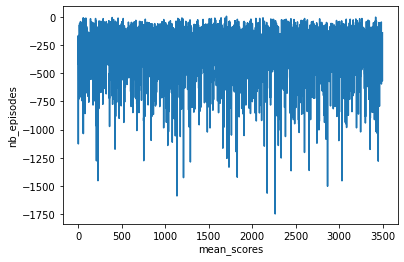

In [8]:
plt.plot(mean_scores)
plt.xlabel('mean_scores')
plt.ylabel('nb_episodes')

In [9]:
np.mean(steps)

327.06685714285715

In [14]:
min(steps)

7

In [12]:
agent = RandomAgent()
random_trained_agent, random_steps, random_mean_scores = run_episode(agent)

  0%|          | 0/3500 [00:00<?, ?it/s]

http://127.0.0.1/ctf_2/ctf_2_4.php


  0%|          | 1/3500 [00:06<6:29:12,  6.67s/it]

ステップ数:499, 平均報酬:-488.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  0%|          | 2/3500 [00:08<4:57:11,  5.10s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  0%|          | 3/3500 [00:11<4:21:08,  4.48s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  0%|          | 4/3500 [00:16<4:29:21,  4.62s/it]

ステップ数:394, 平均報酬:-383.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  0%|          | 5/3500 [00:20<4:31:48,  4.67s/it]

ステップ数:367, 平均報酬:-356.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  0%|          | 6/3500 [00:28<5:28:52,  5.65s/it]

ステップ数:621, 平均報酬:-610.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  0%|          | 7/3500 [00:32<4:46:33,  4.92s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  0%|          | 8/3500 [00:35<4:16:38,  4.41s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  0%|          | 9/3500 [00:37<3:46:31,  3.89s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  0%|          | 10/3500 [00:42<4:04:40,  4.21s/it]

ステップ数:388, 平均報酬:-377.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  0%|          | 11/3500 [00:46<3:48:50,  3.94s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  0%|          | 12/3500 [00:48<3:28:09,  3.58s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  0%|          | 13/3500 [00:49<2:32:59,  2.63s/it]

ステップ数:26, 平均報酬:-15.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  0%|          | 14/3500 [00:52<2:41:30,  2.78s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  0%|          | 15/3500 [00:56<3:09:59,  3.27s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  0%|          | 16/3500 [01:01<3:27:55,  3.58s/it]

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  0%|          | 17/3500 [01:07<4:19:48,  4.48s/it]

ステップ数:485, 平均報酬:-474.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  1%|          | 18/3500 [01:11<4:00:12,  4.14s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  1%|          | 19/3500 [01:18<4:58:28,  5.14s/it]

ステップ数:606, 平均報酬:-595.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  1%|          | 20/3500 [01:26<5:40:55,  5.88s/it]

ステップ数:632, 平均報酬:-621.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  1%|          | 21/3500 [01:28<4:33:06,  4.71s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  1%|          | 22/3500 [01:31<4:01:25,  4.16s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  1%|          | 23/3500 [01:36<4:23:17,  4.54s/it]

ステップ数:434, 平均報酬:-423.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  1%|          | 24/3500 [01:40<4:06:53,  4.26s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  1%|          | 25/3500 [01:41<3:13:21,  3.34s/it]

ステップ数:88, 平均報酬:-77.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  1%|          | 26/3500 [01:45<3:32:32,  3.67s/it]

ステップ数:358, 平均報酬:-347.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  1%|          | 27/3500 [01:50<3:52:30,  4.02s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  1%|          | 28/3500 [01:53<3:31:44,  3.66s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  1%|          | 29/3500 [01:56<3:24:26,  3.53s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  1%|          | 30/3500 [02:00<3:34:59,  3.72s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  1%|          | 31/3500 [02:08<4:48:40,  4.99s/it]

ステップ数:644, 平均報酬:-633.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  1%|          | 32/3500 [02:09<3:39:26,  3.80s/it]

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  1%|          | 33/3500 [02:12<3:19:17,  3.45s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  1%|          | 34/3500 [02:14<2:50:49,  2.96s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  1%|          | 35/3500 [02:15<2:22:54,  2.47s/it]

ステップ数:92, 平均報酬:-81.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  1%|          | 36/3500 [02:20<3:08:36,  3.27s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  1%|          | 37/3500 [02:27<4:16:47,  4.45s/it]

ステップ数:559, 平均報酬:-548.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  1%|          | 38/3500 [02:32<4:14:03,  4.40s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  1%|          | 39/3500 [02:33<3:28:15,  3.61s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  1%|          | 40/3500 [02:36<3:15:50,  3.40s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  1%|          | 41/3500 [02:48<5:35:59,  5.83s/it]

ステップ数:910, 平均報酬:-899.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  1%|          | 42/3500 [02:50<4:35:40,  4.78s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  1%|          | 43/3500 [02:54<4:19:39,  4.51s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  1%|▏         | 44/3500 [02:56<3:28:31,  3.62s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  1%|▏         | 45/3500 [03:00<3:42:24,  3.86s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  1%|▏         | 46/3500 [03:03<3:28:03,  3.61s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  1%|▏         | 47/3500 [03:07<3:39:45,  3.82s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  1%|▏         | 48/3500 [03:10<3:19:42,  3.47s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  1%|▏         | 49/3500 [03:12<2:47:40,  2.92s/it]

ステップ数:114, 平均報酬:-103.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  1%|▏         | 50/3500 [03:15<2:53:57,  3.03s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  1%|▏         | 51/3500 [03:16<2:22:55,  2.49s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  1%|▏         | 52/3500 [03:20<2:43:29,  2.84s/it]

ステップ数:275, 平均報酬:-264.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  2%|▏         | 53/3500 [03:36<6:29:17,  6.78s/it]

ステップ数:1253, 平均報酬:-1242.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  2%|▏         | 54/3500 [03:43<6:30:08,  6.79s/it]

ステップ数:530, 平均報酬:-519.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  2%|▏         | 55/3500 [03:45<5:08:54,  5.38s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  2%|▏         | 56/3500 [03:45<3:47:53,  3.97s/it]

ステップ数:47, 平均報酬:-36.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  2%|▏         | 57/3500 [03:47<3:13:25,  3.37s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  2%|▏         | 58/3500 [03:51<3:11:50,  3.34s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  2%|▏         | 59/3500 [03:52<2:46:39,  2.91s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  2%|▏         | 60/3500 [03:56<2:55:47,  3.07s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  2%|▏         | 61/3500 [04:01<3:35:01,  3.75s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  2%|▏         | 62/3500 [04:03<3:05:08,  3.23s/it]

ステップ数:153, 平均報酬:-142.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  2%|▏         | 63/3500 [04:04<2:24:49,  2.53s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  2%|▏         | 64/3500 [04:06<2:14:58,  2.36s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  2%|▏         | 65/3500 [04:09<2:31:34,  2.65s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  2%|▏         | 66/3500 [04:14<3:08:43,  3.30s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  2%|▏         | 67/3500 [04:15<2:27:59,  2.59s/it]

ステップ数:58, 平均報酬:-47.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  2%|▏         | 68/3500 [04:18<2:26:58,  2.57s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  2%|▏         | 69/3500 [04:29<4:59:27,  5.24s/it]

ステップ数:898, 平均報酬:-887.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  2%|▏         | 70/3500 [04:37<5:42:58,  6.00s/it]

ステップ数:607, 平均報酬:-596.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  2%|▏         | 71/3500 [04:39<4:29:26,  4.71s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  2%|▏         | 72/3500 [04:44<4:48:17,  5.05s/it]

ステップ数:454, 平均報酬:-443.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  2%|▏         | 73/3500 [04:50<4:59:45,  5.25s/it]

ステップ数:459, 平均報酬:-448.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  2%|▏         | 74/3500 [04:53<4:17:16,  4.51s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  2%|▏         | 75/3500 [04:56<3:52:46,  4.08s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  2%|▏         | 76/3500 [04:58<3:16:02,  3.44s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  2%|▏         | 77/3500 [05:03<3:48:35,  4.01s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  2%|▏         | 78/3500 [05:06<3:17:26,  3.46s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  2%|▏         | 79/3500 [05:10<3:32:29,  3.73s/it]

ステップ数:347, 平均報酬:-336.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  2%|▏         | 80/3500 [05:15<4:01:50,  4.24s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  2%|▏         | 81/3500 [05:17<3:18:27,  3.48s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  2%|▏         | 82/3500 [05:18<2:34:57,  2.72s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  2%|▏         | 83/3500 [05:19<2:10:55,  2.30s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  2%|▏         | 84/3500 [05:22<2:21:30,  2.49s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  2%|▏         | 85/3500 [05:24<2:12:11,  2.32s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  2%|▏         | 86/3500 [05:25<1:49:11,  1.92s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  2%|▏         | 87/3500 [05:30<2:45:39,  2.91s/it]

ステップ数:403, 平均報酬:-392.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  3%|▎         | 88/3500 [05:35<3:11:46,  3.37s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  3%|▎         | 89/3500 [05:38<3:14:26,  3.42s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  3%|▎         | 90/3500 [05:42<3:09:55,  3.34s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  3%|▎         | 91/3500 [05:48<4:03:40,  4.29s/it]

ステップ数:494, 平均報酬:-483.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  3%|▎         | 92/3500 [05:50<3:25:31,  3.62s/it]

ステップ数:142, 平均報酬:-131.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  3%|▎         | 93/3500 [05:58<4:37:10,  4.88s/it]

ステップ数:610, 平均報酬:-599.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  3%|▎         | 94/3500 [06:03<4:42:18,  4.97s/it]

ステップ数:417, 平均報酬:-406.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  3%|▎         | 95/3500 [06:06<4:12:30,  4.45s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  3%|▎         | 96/3500 [06:08<3:21:47,  3.56s/it]

ステップ数:110, 平均報酬:-99.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  3%|▎         | 97/3500 [06:09<2:44:51,  2.91s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  3%|▎         | 98/3500 [06:14<3:22:30,  3.57s/it]

ステップ数:450, 平均報酬:-439.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  3%|▎         | 99/3500 [06:21<4:19:21,  4.58s/it]

ステップ数:561, 平均報酬:-550.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  3%|▎         | 100/3500 [06:25<3:57:55,  4.20s/it]

ステップ数:273, 平均報酬:-262.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  3%|▎         | 101/3500 [06:28<3:44:13,  3.96s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  3%|▎         | 102/3500 [06:35<4:34:34,  4.85s/it]

ステップ数:567, 平均報酬:-556.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  3%|▎         | 103/3500 [06:39<4:20:49,  4.61s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  3%|▎         | 104/3500 [06:42<3:56:58,  4.19s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  3%|▎         | 105/3500 [06:42<2:51:13,  3.03s/it]

ステップ数:20, 平均報酬:-9.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  3%|▎         | 106/3500 [06:44<2:24:23,  2.55s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  3%|▎         | 107/3500 [06:47<2:32:04,  2.69s/it]

ステップ数:240, 平均報酬:-229.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  3%|▎         | 108/3500 [06:56<4:25:19,  4.69s/it]

ステップ数:790, 平均報酬:-779.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  3%|▎         | 109/3500 [06:58<3:32:02,  3.75s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  3%|▎         | 110/3500 [07:00<3:04:02,  3.26s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  3%|▎         | 111/3500 [07:03<2:57:39,  3.15s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  3%|▎         | 112/3500 [07:11<4:15:53,  4.53s/it]

ステップ数:578, 平均報酬:-567.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  3%|▎         | 113/3500 [07:13<3:45:45,  4.00s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  3%|▎         | 114/3500 [07:22<5:05:24,  5.41s/it]

ステップ数:670, 平均報酬:-659.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  3%|▎         | 115/3500 [07:24<4:03:35,  4.32s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  3%|▎         | 116/3500 [07:26<3:26:05,  3.65s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  3%|▎         | 117/3500 [07:33<4:20:22,  4.62s/it]

ステップ数:571, 平均報酬:-560.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  3%|▎         | 118/3500 [07:35<3:31:59,  3.76s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  3%|▎         | 119/3500 [07:41<4:21:16,  4.64s/it]

ステップ数:550, 平均報酬:-539.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  3%|▎         | 120/3500 [07:51<5:42:04,  6.07s/it]

ステップ数:795, 平均報酬:-784.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  3%|▎         | 121/3500 [07:53<4:42:54,  5.02s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  3%|▎         | 122/3500 [07:58<4:32:41,  4.84s/it]

ステップ数:371, 平均報酬:-360.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  4%|▎         | 123/3500 [08:00<3:50:55,  4.10s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  4%|▎         | 124/3500 [08:03<3:32:00,  3.77s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  4%|▎         | 125/3500 [08:11<4:44:49,  5.06s/it]

ステップ数:687, 平均報酬:-676.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  4%|▎         | 126/3500 [08:19<5:24:53,  5.78s/it]

ステップ数:620, 平均報酬:-609.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  4%|▎         | 127/3500 [08:23<4:59:19,  5.32s/it]

ステップ数:351, 平均報酬:-340.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  4%|▎         | 128/3500 [08:30<5:33:25,  5.93s/it]

ステップ数:617, 平均報酬:-606.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  4%|▎         | 129/3500 [08:32<4:22:01,  4.66s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  4%|▎         | 130/3500 [08:38<4:41:06,  5.00s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  4%|▎         | 131/3500 [08:38<3:30:52,  3.76s/it]

ステップ数:57, 平均報酬:-46.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  4%|▍         | 132/3500 [08:40<2:56:16,  3.14s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  4%|▍         | 133/3500 [08:50<4:41:03,  5.01s/it]

ステップ数:789, 平均報酬:-778.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  4%|▍         | 134/3500 [08:53<4:21:20,  4.66s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  4%|▍         | 135/3500 [08:58<4:19:46,  4.63s/it]

ステップ数:371, 平均報酬:-360.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  4%|▍         | 136/3500 [09:01<3:45:14,  4.02s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  4%|▍         | 137/3500 [09:09<5:05:13,  5.45s/it]

ステップ数:635, 平均報酬:-624.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  4%|▍         | 138/3500 [09:11<4:00:52,  4.30s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  4%|▍         | 139/3500 [09:25<6:50:43,  7.33s/it]

ステップ数:1131, 平均報酬:-1120.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  4%|▍         | 140/3500 [09:27<5:13:09,  5.59s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  4%|▍         | 141/3500 [09:30<4:31:57,  4.86s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  4%|▍         | 142/3500 [09:34<4:19:01,  4.63s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  4%|▍         | 143/3500 [09:41<4:56:59,  5.31s/it]

ステップ数:575, 平均報酬:-564.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  4%|▍         | 144/3500 [09:42<3:41:07,  3.95s/it]

ステップ数:57, 平均報酬:-46.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  4%|▍         | 145/3500 [09:50<4:50:12,  5.19s/it]

ステップ数:669, 平均報酬:-658.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  4%|▍         | 146/3500 [09:55<4:45:27,  5.11s/it]

ステップ数:393, 平均報酬:-382.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  4%|▍         | 147/3500 [09:58<4:12:46,  4.52s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  4%|▍         | 148/3500 [10:03<4:24:32,  4.74s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  4%|▍         | 149/3500 [10:07<4:05:35,  4.40s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  4%|▍         | 150/3500 [10:09<3:26:02,  3.69s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  4%|▍         | 151/3500 [10:10<2:51:38,  3.07s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  4%|▍         | 152/3500 [10:21<5:02:13,  5.42s/it]

ステップ数:813, 平均報酬:-802.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  4%|▍         | 153/3500 [10:31<6:21:05,  6.83s/it]

ステップ数:793, 平均報酬:-782.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  4%|▍         | 154/3500 [10:39<6:40:45,  7.19s/it]

ステップ数:622, 平均報酬:-611.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  4%|▍         | 155/3500 [10:40<4:53:42,  5.27s/it]

ステップ数:59, 平均報酬:-48.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  4%|▍         | 156/3500 [10:41<3:44:34,  4.03s/it]

ステップ数:81, 平均報酬:-70.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  4%|▍         | 157/3500 [10:49<4:49:28,  5.20s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  5%|▍         | 158/3500 [10:50<3:32:00,  3.81s/it]

ステップ数:35, 平均報酬:-24.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  5%|▍         | 159/3500 [10:52<2:56:48,  3.18s/it]

ステップ数:132, 平均報酬:-121.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  5%|▍         | 160/3500 [10:57<3:34:12,  3.85s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▍         | 161/3500 [11:03<4:08:14,  4.46s/it]

ステップ数:426, 平均報酬:-415.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  5%|▍         | 162/3500 [11:06<3:43:50,  4.02s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  5%|▍         | 163/3500 [11:09<3:30:40,  3.79s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  5%|▍         | 164/3500 [11:11<2:58:25,  3.21s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  5%|▍         | 165/3500 [11:21<4:46:05,  5.15s/it]

ステップ数:750, 平均報酬:-739.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  5%|▍         | 166/3500 [11:23<3:57:53,  4.28s/it]

ステップ数:169, 平均報酬:-158.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  5%|▍         | 167/3500 [11:31<5:01:51,  5.43s/it]

ステップ数:622, 平均報酬:-611.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  5%|▍         | 168/3500 [11:33<4:00:05,  4.32s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  5%|▍         | 169/3500 [11:38<4:07:34,  4.46s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  5%|▍         | 170/3500 [11:43<4:16:45,  4.63s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  5%|▍         | 171/3500 [11:47<4:21:10,  4.71s/it]

ステップ数:380, 平均報酬:-369.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  5%|▍         | 172/3500 [11:49<3:28:08,  3.75s/it]

ステップ数:111, 平均報酬:-100.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▍         | 173/3500 [11:50<2:42:52,  2.94s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▍         | 174/3500 [11:55<3:22:27,  3.65s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▌         | 175/3500 [12:03<4:35:54,  4.98s/it]

ステップ数:653, 平均報酬:-642.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▌         | 176/3500 [12:09<4:37:06,  5.00s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  5%|▌         | 177/3500 [12:14<4:48:30,  5.21s/it]

ステップ数:428, 平均報酬:-417.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  5%|▌         | 178/3500 [12:17<4:11:21,  4.54s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  5%|▌         | 179/3500 [12:21<4:01:13,  4.36s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  5%|▌         | 180/3500 [12:23<3:18:43,  3.59s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  5%|▌         | 181/3500 [12:28<3:42:01,  4.01s/it]

ステップ数:432, 平均報酬:-421.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  5%|▌         | 182/3500 [12:32<3:38:07,  3.94s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  5%|▌         | 183/3500 [12:37<3:57:18,  4.29s/it]

ステップ数:431, 平均報酬:-420.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  5%|▌         | 184/3500 [12:40<3:44:53,  4.07s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  5%|▌         | 185/3500 [12:54<6:21:43,  6.91s/it]

ステップ数:1125, 平均報酬:-1114.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  5%|▌         | 186/3500 [12:56<4:58:51,  5.41s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  5%|▌         | 187/3500 [12:58<4:06:26,  4.46s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  5%|▌         | 188/3500 [13:01<3:40:24,  3.99s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  5%|▌         | 189/3500 [13:07<4:10:08,  4.53s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  5%|▌         | 190/3500 [13:11<3:57:39,  4.31s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  5%|▌         | 191/3500 [13:15<4:05:23,  4.45s/it]

ステップ数:371, 平均報酬:-360.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  5%|▌         | 192/3500 [13:31<7:15:51,  7.91s/it]

ステップ数:1261, 平均報酬:-1250.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  6%|▌         | 193/3500 [13:38<7:02:06,  7.66s/it]

ステップ数:542, 平均報酬:-531.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  6%|▌         | 194/3500 [13:39<5:13:56,  5.70s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  6%|▌         | 195/3500 [13:41<4:02:03,  4.39s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  6%|▌         | 196/3500 [13:45<3:54:53,  4.27s/it]

ステップ数:308, 平均報酬:-297.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  6%|▌         | 197/3500 [13:48<3:37:35,  3.95s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  6%|▌         | 198/3500 [13:54<4:07:23,  4.50s/it]

ステップ数:457, 平均報酬:-446.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  6%|▌         | 199/3500 [13:57<3:42:20,  4.04s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  6%|▌         | 200/3500 [14:02<4:06:18,  4.48s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  6%|▌         | 201/3500 [14:04<3:20:37,  3.65s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  6%|▌         | 202/3500 [14:09<3:40:16,  4.01s/it]

ステップ数:383, 平均報酬:-372.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  6%|▌         | 203/3500 [14:13<3:49:13,  4.17s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  6%|▌         | 204/3500 [14:17<3:37:18,  3.96s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  6%|▌         | 205/3500 [14:19<3:08:07,  3.43s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  6%|▌         | 206/3500 [14:29<4:58:28,  5.44s/it]

ステップ数:787, 平均報酬:-776.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  6%|▌         | 207/3500 [14:30<3:38:54,  3.99s/it]

ステップ数:37, 平均報酬:-26.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  6%|▌         | 208/3500 [14:37<4:33:59,  4.99s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  6%|▌         | 209/3500 [14:39<3:47:57,  4.16s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  6%|▌         | 210/3500 [14:40<2:48:30,  3.07s/it]

ステップ数:34, 平均報酬:-23.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  6%|▌         | 211/3500 [14:44<3:08:55,  3.45s/it]

ステップ数:324, 平均報酬:-313.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  6%|▌         | 212/3500 [14:54<4:52:02,  5.33s/it]

ステップ数:749, 平均報酬:-738.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  6%|▌         | 213/3500 [14:59<4:56:46,  5.42s/it]

ステップ数:420, 平均報酬:-409.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  6%|▌         | 214/3500 [15:01<3:47:08,  4.15s/it]

ステップ数:78, 平均報酬:-67.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  6%|▌         | 215/3500 [15:06<4:05:18,  4.48s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  6%|▌         | 216/3500 [15:08<3:20:44,  3.67s/it]

ステップ数:111, 平均報酬:-100.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  6%|▌         | 217/3500 [15:11<3:10:24,  3.48s/it]

ステップ数:205, 平均報酬:-194.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  6%|▌         | 218/3500 [15:15<3:30:33,  3.85s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  6%|▋         | 219/3500 [15:25<5:06:06,  5.60s/it]

ステップ数:772, 平均報酬:-761.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  6%|▋         | 220/3500 [15:28<4:25:32,  4.86s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  6%|▋         | 221/3500 [15:30<3:39:55,  4.02s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  6%|▋         | 222/3500 [15:38<4:34:11,  5.02s/it]

ステップ数:541, 平均報酬:-530.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  6%|▋         | 223/3500 [15:40<3:42:02,  4.07s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  6%|▋         | 224/3500 [15:42<3:14:19,  3.56s/it]

ステップ数:169, 平均報酬:-158.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  6%|▋         | 225/3500 [15:44<2:52:50,  3.17s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  6%|▋         | 226/3500 [15:48<3:08:14,  3.45s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  6%|▋         | 227/3500 [16:07<7:18:18,  8.03s/it]

ステップ数:1432, 平均報酬:-1421.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  7%|▋         | 228/3500 [16:11<6:15:40,  6.89s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  7%|▋         | 229/3500 [16:17<6:02:26,  6.65s/it]

ステップ数:470, 平均報酬:-459.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  7%|▋         | 230/3500 [16:24<6:08:38,  6.76s/it]

ステップ数:534, 平均報酬:-523.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  7%|▋         | 231/3500 [16:31<6:14:08,  6.87s/it]

ステップ数:529, 平均報酬:-518.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 232/3500 [16:34<5:07:38,  5.65s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  7%|▋         | 233/3500 [16:41<5:17:23,  5.83s/it]

ステップ数:452, 平均報酬:-441.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  7%|▋         | 234/3500 [16:43<4:19:48,  4.77s/it]

ステップ数:153, 平均報酬:-142.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 235/3500 [16:48<4:23:38,  4.84s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  7%|▋         | 236/3500 [16:51<3:49:57,  4.23s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  7%|▋         | 237/3500 [17:05<6:42:14,  7.40s/it]

ステップ数:1101, 平均報酬:-1090.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  7%|▋         | 238/3500 [17:07<5:03:04,  5.57s/it]

ステップ数:96, 平均報酬:-85.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  7%|▋         | 239/3500 [17:13<5:20:38,  5.90s/it]

ステップ数:483, 平均報酬:-472.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  7%|▋         | 240/3500 [17:17<4:50:13,  5.34s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  7%|▋         | 241/3500 [17:24<5:12:04,  5.75s/it]

ステップ数:511, 平均報酬:-500.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  7%|▋         | 242/3500 [17:37<7:09:10,  7.90s/it]

ステップ数:981, 平均報酬:-970.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  7%|▋         | 243/3500 [17:45<7:11:02,  7.94s/it]

ステップ数:599, 平均報酬:-588.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  7%|▋         | 244/3500 [17:50<6:16:08,  6.93s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 245/3500 [17:51<4:43:42,  5.23s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  7%|▋         | 246/3500 [17:53<3:58:00,  4.39s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  7%|▋         | 247/3500 [17:57<3:46:19,  4.17s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  7%|▋         | 248/3500 [17:59<3:09:07,  3.49s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 249/3500 [18:05<3:48:34,  4.22s/it]

ステップ数:439, 平均報酬:-428.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  7%|▋         | 250/3500 [18:09<3:53:15,  4.31s/it]

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 251/3500 [18:15<4:07:16,  4.57s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  7%|▋         | 252/3500 [18:19<4:09:12,  4.60s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  7%|▋         | 253/3500 [18:21<3:30:26,  3.89s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  7%|▋         | 254/3500 [18:25<3:17:34,  3.65s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  7%|▋         | 255/3500 [18:25<2:33:39,  2.84s/it]

ステップ数:63, 平均報酬:-52.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  7%|▋         | 256/3500 [18:29<2:52:50,  3.20s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  7%|▋         | 257/3500 [18:32<2:35:29,  2.88s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  7%|▋         | 258/3500 [18:38<3:32:29,  3.93s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  7%|▋         | 259/3500 [18:47<4:46:07,  5.30s/it]

ステップ数:650, 平均報酬:-639.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  7%|▋         | 260/3500 [18:55<5:37:11,  6.24s/it]

ステップ数:637, 平均報酬:-626.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  7%|▋         | 261/3500 [19:08<7:31:23,  8.36s/it]

ステップ数:940, 平均報酬:-929.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  7%|▋         | 262/3500 [19:10<5:37:10,  6.25s/it]

ステップ数:86, 平均報酬:-75.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  8%|▊         | 263/3500 [19:23<7:40:30,  8.54s/it]

ステップ数:1065, 平均報酬:-1054.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  8%|▊         | 264/3500 [19:37<8:57:04,  9.96s/it]

ステップ数:1030, 平均報酬:-1019.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  8%|▊         | 265/3500 [19:40<7:16:23,  8.09s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  8%|▊         | 266/3500 [19:44<5:55:20,  6.59s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  8%|▊         | 267/3500 [19:49<5:28:54,  6.10s/it]

ステップ数:351, 平均報酬:-340.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  8%|▊         | 268/3500 [19:55<5:41:24,  6.34s/it]

ステップ数:508, 平均報酬:-497.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  8%|▊         | 269/3500 [19:58<4:45:37,  5.30s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  8%|▊         | 270/3500 [20:00<3:51:52,  4.31s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  8%|▊         | 271/3500 [20:04<3:40:02,  4.09s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  8%|▊         | 272/3500 [20:08<3:40:35,  4.10s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  8%|▊         | 273/3500 [20:13<4:01:54,  4.50s/it]

ステップ数:402, 平均報酬:-391.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  8%|▊         | 274/3500 [20:24<5:47:42,  6.47s/it]

ステップ数:843, 平均報酬:-832.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  8%|▊         | 275/3500 [20:29<5:22:29,  6.00s/it]

ステップ数:344, 平均報酬:-333.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  8%|▊         | 276/3500 [20:35<5:12:16,  5.81s/it]

ステップ数:390, 平均報酬:-379.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  8%|▊         | 277/3500 [20:37<4:20:11,  4.84s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  8%|▊         | 278/3500 [20:39<3:27:54,  3.87s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  8%|▊         | 279/3500 [20:44<3:51:41,  4.32s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  8%|▊         | 280/3500 [20:48<3:38:01,  4.06s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  8%|▊         | 281/3500 [20:57<5:01:03,  5.61s/it]

ステップ数:716, 平均報酬:-705.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  8%|▊         | 282/3500 [20:58<3:46:10,  4.22s/it]

ステップ数:72, 平均報酬:-61.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  8%|▊         | 283/3500 [21:04<4:14:25,  4.75s/it]

ステップ数:394, 平均報酬:-383.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  8%|▊         | 284/3500 [21:10<4:39:33,  5.22s/it]

ステップ数:422, 平均報酬:-411.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  8%|▊         | 285/3500 [21:20<5:45:43,  6.45s/it]

ステップ数:689, 平均報酬:-678.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  8%|▊         | 286/3500 [21:24<5:11:38,  5.82s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  8%|▊         | 287/3500 [21:30<5:21:45,  6.01s/it]

ステップ数:481, 平均報酬:-470.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  8%|▊         | 288/3500 [21:37<5:28:06,  6.13s/it]

ステップ数:463, 平均報酬:-452.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  8%|▊         | 289/3500 [21:41<5:03:35,  5.67s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_3/ctf_3_4.php


  8%|▊         | 290/3500 [21:44<4:07:54,  4.63s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  8%|▊         | 291/3500 [21:52<5:14:31,  5.88s/it]

ステップ数:625, 平均報酬:-614.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  8%|▊         | 292/3500 [21:57<4:47:58,  5.39s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  8%|▊         | 293/3500 [21:59<3:58:28,  4.46s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  8%|▊         | 294/3500 [22:09<5:20:53,  6.01s/it]

ステップ数:735, 平均報酬:-724.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  8%|▊         | 295/3500 [22:12<4:35:53,  5.16s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  8%|▊         | 296/3500 [22:27<7:17:17,  8.19s/it]

ステップ数:1149, 平均報酬:-1138.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  8%|▊         | 297/3500 [22:28<5:27:35,  6.14s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  9%|▊         | 298/3500 [22:33<5:04:12,  5.70s/it]

ステップ数:377, 平均報酬:-366.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  9%|▊         | 299/3500 [22:35<4:10:15,  4.69s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  9%|▊         | 300/3500 [22:37<3:16:54,  3.69s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_2/ctf_2_3.php


  9%|▊         | 301/3500 [22:39<2:48:07,  3.15s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  9%|▊         | 302/3500 [22:39<2:11:22,  2.46s/it]

ステップ数:54, 平均報酬:-43.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  9%|▊         | 303/3500 [22:46<3:09:23,  3.55s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  9%|▊         | 304/3500 [22:51<3:46:26,  4.25s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_1/ctf_1_4.php


  9%|▊         | 305/3500 [22:53<3:06:30,  3.50s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  9%|▊         | 306/3500 [22:59<3:49:17,  4.31s/it]

ステップ数:380, 平均報酬:-369.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  9%|▉         | 307/3500 [23:00<2:48:46,  3.17s/it]

ステップ数:28, 平均報酬:-17.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  9%|▉         | 308/3500 [23:02<2:29:15,  2.81s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  9%|▉         | 309/3500 [23:05<2:35:03,  2.92s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_1/ctf_1_3.php


  9%|▉         | 310/3500 [23:06<1:57:57,  2.22s/it]

ステップ数:32, 平均報酬:-21.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  9%|▉         | 311/3500 [23:06<1:30:45,  1.71s/it]

ステップ数:30, 平均報酬:-19.0
http://127.0.0.1/ctf_2/ctf_2_4.php


  9%|▉         | 312/3500 [23:17<3:59:19,  4.50s/it]

ステップ数:778, 平均報酬:-767.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 313/3500 [23:22<3:58:31,  4.49s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  9%|▉         | 314/3500 [23:24<3:24:16,  3.85s/it]

ステップ数:168, 平均報酬:-157.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  9%|▉         | 315/3500 [23:26<3:01:48,  3.42s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 316/3500 [23:39<5:33:42,  6.29s/it]

ステップ数:976, 平均報酬:-965.0
http://127.0.0.1/ctf_3/ctf_3_2.php


  9%|▉         | 317/3500 [23:49<6:25:38,  7.27s/it]

ステップ数:703, 平均報酬:-692.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  9%|▉         | 318/3500 [23:51<5:08:00,  5.81s/it]

ステップ数:182, 平均報酬:-171.0
http://127.0.0.1/ctf_3/ctf_3_3.php


  9%|▉         | 319/3500 [23:55<4:26:14,  5.02s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 320/3500 [24:02<4:57:30,  5.61s/it]

ステップ数:495, 平均報酬:-484.0
http://127.0.0.1/ctf_3/ctf_3_5.php


  9%|▉         | 321/3500 [24:04<4:03:40,  4.60s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_4/ctf_4_4.php


  9%|▉         | 322/3500 [24:11<4:51:07,  5.50s/it]

ステップ数:546, 平均報酬:-535.0
http://127.0.0.1/ctf_4/ctf_4_5.php


  9%|▉         | 323/3500 [24:15<4:20:27,  4.92s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_1/ctf_1_2.php


  9%|▉         | 324/3500 [24:26<6:06:12,  6.92s/it]

ステップ数:858, 平均報酬:-847.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  9%|▉         | 325/3500 [24:30<5:06:33,  5.79s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 326/3500 [24:39<6:02:00,  6.84s/it]

ステップ数:655, 平均報酬:-644.0
http://127.0.0.1/ctf_2/ctf_2_2.php


  9%|▉         | 327/3500 [24:41<4:42:16,  5.34s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 328/3500 [24:46<4:32:29,  5.15s/it]

ステップ数:369, 平均報酬:-358.0
http://127.0.0.1/ctf_4/ctf_4_2.php


  9%|▉         | 329/3500 [24:55<5:35:54,  6.36s/it]

ステップ数:674, 平均報酬:-663.0
http://127.0.0.1/ctf_1/ctf_1_5.php


  9%|▉         | 330/3500 [24:58<4:48:02,  5.45s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_2/ctf_2_5.php


  9%|▉         | 331/3500 [25:05<5:18:07,  6.02s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_4/ctf_4_3.php


  9%|▉         | 332/3500 [25:09<4:32:34,  5.16s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|▉         | 333/3500 [25:10<3:36:25,  4.10s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 10%|▉         | 334/3500 [25:16<4:01:06,  4.57s/it]

ステップ数:390, 平均報酬:-379.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 10%|▉         | 335/3500 [25:18<3:22:05,  3.83s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 10%|▉         | 336/3500 [25:32<6:02:31,  6.87s/it]

ステップ数:1054, 平均報酬:-1043.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 10%|▉         | 337/3500 [25:37<5:33:18,  6.32s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 10%|▉         | 338/3500 [25:39<4:29:07,  5.11s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 10%|▉         | 339/3500 [25:41<3:44:09,  4.25s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 10%|▉         | 340/3500 [25:44<3:11:12,  3.63s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 10%|▉         | 341/3500 [25:59<6:20:04,  7.22s/it]

ステップ数:1147, 平均報酬:-1136.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|▉         | 342/3500 [26:04<5:44:13,  6.54s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|▉         | 343/3500 [26:09<5:12:23,  5.94s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 10%|▉         | 344/3500 [26:11<4:20:09,  4.95s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 10%|▉         | 345/3500 [26:13<3:28:36,  3.97s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 10%|▉         | 346/3500 [26:15<3:01:49,  3.46s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 10%|▉         | 347/3500 [26:17<2:33:31,  2.92s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 10%|▉         | 348/3500 [26:22<3:06:35,  3.55s/it]

ステップ数:344, 平均報酬:-333.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 10%|▉         | 349/3500 [26:25<3:00:00,  3.43s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 10%|█         | 350/3500 [26:32<3:54:36,  4.47s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 10%|█         | 351/3500 [26:38<4:23:19,  5.02s/it]

ステップ数:447, 平均報酬:-436.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 10%|█         | 352/3500 [26:42<4:05:19,  4.68s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 10%|█         | 353/3500 [26:44<3:23:00,  3.87s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 10%|█         | 354/3500 [26:46<2:43:03,  3.11s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 10%|█         | 355/3500 [26:47<2:20:23,  2.68s/it]

ステップ数:112, 平均報酬:-101.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|█         | 356/3500 [26:54<3:32:29,  4.06s/it]

ステップ数:555, 平均報酬:-544.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|█         | 357/3500 [26:57<3:03:07,  3.50s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 10%|█         | 358/3500 [27:04<3:58:30,  4.55s/it]

ステップ数:441, 平均報酬:-430.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 10%|█         | 359/3500 [27:08<3:47:48,  4.35s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 10%|█         | 360/3500 [27:09<3:06:31,  3.56s/it]

ステップ数:106, 平均報酬:-95.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 10%|█         | 361/3500 [27:14<3:31:09,  4.04s/it]

ステップ数:349, 平均報酬:-338.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 10%|█         | 362/3500 [27:17<3:12:10,  3.67s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 10%|█         | 363/3500 [27:20<2:53:47,  3.32s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 10%|█         | 364/3500 [27:23<2:56:26,  3.38s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 10%|█         | 365/3500 [27:26<2:50:18,  3.26s/it]

ステップ数:218, 平均報酬:-207.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 10%|█         | 366/3500 [27:29<2:37:30,  3.02s/it]

ステップ数:164, 平均報酬:-153.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 10%|█         | 367/3500 [27:31<2:22:32,  2.73s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 11%|█         | 368/3500 [27:33<2:21:25,  2.71s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 11%|█         | 369/3500 [27:44<4:25:08,  5.08s/it]

ステップ数:764, 平均報酬:-753.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█         | 370/3500 [27:47<3:54:04,  4.49s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 11%|█         | 371/3500 [27:51<3:46:11,  4.34s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 11%|█         | 372/3500 [27:57<4:04:01,  4.68s/it]

ステップ数:388, 平均報酬:-377.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 11%|█         | 373/3500 [28:03<4:31:54,  5.22s/it]

ステップ数:465, 平均報酬:-454.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 11%|█         | 374/3500 [28:05<3:43:40,  4.29s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 11%|█         | 375/3500 [28:09<3:32:31,  4.08s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 11%|█         | 376/3500 [28:11<3:01:19,  3.48s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 11%|█         | 377/3500 [28:16<3:32:56,  4.09s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 11%|█         | 378/3500 [28:22<3:57:43,  4.57s/it]

ステップ数:422, 平均報酬:-411.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 11%|█         | 379/3500 [28:30<4:57:36,  5.72s/it]

ステップ数:609, 平均報酬:-598.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 11%|█         | 380/3500 [28:37<5:02:45,  5.82s/it]

ステップ数:440, 平均報酬:-429.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█         | 381/3500 [28:43<5:16:50,  6.09s/it]

ステップ数:485, 平均報酬:-474.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 11%|█         | 382/3500 [28:53<6:16:56,  7.25s/it]

ステップ数:741, 平均報酬:-730.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 11%|█         | 383/3500 [28:57<5:16:32,  6.09s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 11%|█         | 384/3500 [29:00<4:28:08,  5.16s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 11%|█         | 385/3500 [29:01<3:27:08,  3.99s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█         | 386/3500 [29:04<3:06:55,  3.60s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 11%|█         | 387/3500 [29:06<2:54:14,  3.36s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 11%|█         | 388/3500 [29:08<2:28:21,  2.86s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 11%|█         | 389/3500 [29:14<3:15:41,  3.77s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 11%|█         | 390/3500 [29:16<2:50:19,  3.29s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 11%|█         | 391/3500 [29:24<4:02:49,  4.69s/it]

ステップ数:554, 平均報酬:-543.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 11%|█         | 392/3500 [29:29<4:01:12,  4.66s/it]

ステップ数:308, 平均報酬:-297.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 11%|█         | 393/3500 [29:38<5:08:06,  5.95s/it]

ステップ数:634, 平均報酬:-623.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 11%|█▏        | 394/3500 [29:44<5:15:59,  6.10s/it]

ステップ数:454, 平均報酬:-443.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 11%|█▏        | 395/3500 [29:47<4:20:16,  5.03s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█▏        | 396/3500 [29:49<3:40:05,  4.25s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 11%|█▏        | 397/3500 [29:57<4:32:02,  5.26s/it]

ステップ数:566, 平均報酬:-555.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 11%|█▏        | 398/3500 [30:05<5:18:29,  6.16s/it]

ステップ数:580, 平均報酬:-569.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█▏        | 399/3500 [30:06<4:07:21,  4.79s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 11%|█▏        | 400/3500 [30:14<4:46:11,  5.54s/it]

ステップ数:509, 平均報酬:-498.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 11%|█▏        | 401/3500 [30:16<3:48:06,  4.42s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 11%|█▏        | 402/3500 [30:21<3:57:17,  4.60s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 12%|█▏        | 403/3500 [30:26<4:02:47,  4.70s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 12%|█▏        | 404/3500 [30:28<3:27:24,  4.02s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 12%|█▏        | 405/3500 [30:29<2:44:11,  3.18s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 12%|█▏        | 406/3500 [30:35<3:26:29,  4.00s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 12%|█▏        | 407/3500 [30:38<3:02:50,  3.55s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 12%|█▏        | 408/3500 [30:49<5:09:03,  6.00s/it]

ステップ数:838, 平均報酬:-827.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 12%|█▏        | 409/3500 [30:56<5:19:49,  6.21s/it]

ステップ数:537, 平均報酬:-526.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 12%|█▏        | 410/3500 [31:01<4:55:39,  5.74s/it]

ステップ数:309, 平均報酬:-298.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 12%|█▏        | 411/3500 [31:07<5:09:14,  6.01s/it]

ステップ数:412, 平均報酬:-401.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 12%|█▏        | 412/3500 [31:11<4:34:55,  5.34s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 12%|█▏        | 413/3500 [31:13<3:36:09,  4.20s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 12%|█▏        | 414/3500 [31:23<5:04:12,  5.91s/it]

ステップ数:686, 平均報酬:-675.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 12%|█▏        | 415/3500 [31:29<5:07:20,  5.98s/it]

ステップ数:431, 平均報酬:-420.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 12%|█▏        | 416/3500 [31:30<3:57:44,  4.63s/it]

ステップ数:96, 平均報酬:-85.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 12%|█▏        | 417/3500 [31:35<4:08:04,  4.83s/it]

ステップ数:370, 平均報酬:-359.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 12%|█▏        | 418/3500 [31:42<4:35:10,  5.36s/it]

ステップ数:487, 平均報酬:-476.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 12%|█▏        | 419/3500 [31:47<4:28:28,  5.23s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 12%|█▏        | 420/3500 [31:50<3:50:24,  4.49s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 12%|█▏        | 421/3500 [31:52<3:13:03,  3.76s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 12%|█▏        | 422/3500 [31:59<4:02:15,  4.72s/it]

ステップ数:478, 平均報酬:-467.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 12%|█▏        | 423/3500 [32:03<3:52:32,  4.53s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 12%|█▏        | 424/3500 [32:08<3:57:44,  4.64s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 12%|█▏        | 425/3500 [32:18<5:18:00,  6.21s/it]

ステップ数:693, 平均報酬:-682.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 12%|█▏        | 426/3500 [32:24<5:16:44,  6.18s/it]

ステップ数:477, 平均報酬:-466.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 12%|█▏        | 427/3500 [32:25<3:59:20,  4.67s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 12%|█▏        | 428/3500 [32:28<3:30:14,  4.11s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 12%|█▏        | 429/3500 [32:38<5:00:13,  5.87s/it]

ステップ数:746, 平均報酬:-735.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 12%|█▏        | 430/3500 [32:40<4:07:52,  4.84s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 12%|█▏        | 431/3500 [32:45<4:07:08,  4.83s/it]

ステップ数:318, 平均報酬:-307.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 12%|█▏        | 432/3500 [32:47<3:32:02,  4.15s/it]

ステップ数:164, 平均報酬:-153.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 12%|█▏        | 433/3500 [32:57<4:51:09,  5.70s/it]

ステップ数:618, 平均報酬:-607.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 12%|█▏        | 434/3500 [33:01<4:33:38,  5.36s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 12%|█▏        | 435/3500 [33:12<5:55:03,  6.95s/it]

ステップ数:693, 平均報酬:-682.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 12%|█▏        | 436/3500 [33:26<7:41:51,  9.04s/it]

ステップ数:971, 平均報酬:-960.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 12%|█▏        | 437/3500 [33:28<5:47:35,  6.81s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 13%|█▎        | 438/3500 [33:29<4:27:27,  5.24s/it]

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 13%|█▎        | 439/3500 [33:38<5:23:14,  6.34s/it]

ステップ数:638, 平均報酬:-627.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 13%|█▎        | 440/3500 [33:40<4:22:54,  5.16s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 13%|█▎        | 441/3500 [33:44<4:05:06,  4.81s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 13%|█▎        | 442/3500 [33:50<4:23:15,  5.17s/it]

ステップ数:471, 平均報酬:-460.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 13%|█▎        | 443/3500 [33:56<4:30:12,  5.30s/it]

ステップ数:372, 平均報酬:-361.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 13%|█▎        | 444/3500 [33:58<3:34:48,  4.22s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 13%|█▎        | 445/3500 [34:07<4:55:44,  5.81s/it]

ステップ数:670, 平均報酬:-659.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 13%|█▎        | 446/3500 [34:09<3:55:24,  4.62s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 13%|█▎        | 447/3500 [34:13<3:42:36,  4.37s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 13%|█▎        | 448/3500 [34:20<4:28:45,  5.28s/it]

ステップ数:523, 平均報酬:-512.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 13%|█▎        | 449/3500 [34:22<3:38:45,  4.30s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 13%|█▎        | 450/3500 [34:25<3:13:09,  3.80s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 13%|█▎        | 451/3500 [34:28<3:00:40,  3.56s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 13%|█▎        | 452/3500 [34:36<4:15:18,  5.03s/it]

ステップ数:570, 平均報酬:-559.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 13%|█▎        | 453/3500 [34:41<4:02:16,  4.77s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 13%|█▎        | 454/3500 [34:42<3:18:55,  3.92s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 13%|█▎        | 455/3500 [34:45<3:03:24,  3.61s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 13%|█▎        | 456/3500 [34:47<2:37:48,  3.11s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 13%|█▎        | 457/3500 [34:48<1:58:57,  2.35s/it]

ステップ数:30, 平均報酬:-19.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 13%|█▎        | 458/3500 [34:50<1:55:28,  2.28s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 13%|█▎        | 459/3500 [34:54<2:26:31,  2.89s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 13%|█▎        | 460/3500 [34:57<2:26:18,  2.89s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 13%|█▎        | 461/3500 [35:02<3:02:05,  3.59s/it]

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 13%|█▎        | 462/3500 [35:06<3:00:23,  3.56s/it]

ステップ数:218, 平均報酬:-207.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 13%|█▎        | 463/3500 [35:18<5:10:10,  6.13s/it]

ステップ数:805, 平均報酬:-794.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 13%|█▎        | 464/3500 [35:19<3:47:13,  4.49s/it]

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 13%|█▎        | 465/3500 [35:20<3:00:37,  3.57s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 13%|█▎        | 466/3500 [35:23<2:51:32,  3.39s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 13%|█▎        | 467/3500 [35:27<3:06:39,  3.69s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 13%|█▎        | 468/3500 [35:28<2:24:03,  2.85s/it]

ステップ数:56, 平均報酬:-45.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 13%|█▎        | 469/3500 [35:31<2:18:06,  2.73s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 13%|█▎        | 470/3500 [35:35<2:37:40,  3.12s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 13%|█▎        | 471/3500 [35:44<4:01:37,  4.79s/it]

ステップ数:616, 平均報酬:-605.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 13%|█▎        | 472/3500 [35:49<4:08:59,  4.93s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 14%|█▎        | 473/3500 [35:50<3:13:13,  3.83s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 14%|█▎        | 474/3500 [35:57<4:03:57,  4.84s/it]

ステップ数:502, 平均報酬:-491.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 14%|█▎        | 475/3500 [36:05<4:49:12,  5.74s/it]

ステップ数:515, 平均報酬:-504.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 14%|█▎        | 476/3500 [36:07<3:46:58,  4.50s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 14%|█▎        | 477/3500 [36:09<3:15:29,  3.88s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 14%|█▎        | 478/3500 [36:11<2:37:48,  3.13s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 14%|█▎        | 479/3500 [36:16<3:07:48,  3.73s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 14%|█▎        | 480/3500 [36:25<4:38:22,  5.53s/it]

ステップ数:665, 平均報酬:-654.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 14%|█▎        | 481/3500 [36:29<4:03:57,  4.85s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 14%|█▍        | 482/3500 [36:32<3:34:34,  4.27s/it]

ステップ数:195, 平均報酬:-184.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 14%|█▍        | 483/3500 [36:32<2:44:14,  3.27s/it]

ステップ数:62, 平均報酬:-51.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 14%|█▍        | 484/3500 [36:35<2:33:04,  3.05s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 14%|█▍        | 485/3500 [36:41<3:11:03,  3.80s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 14%|█▍        | 486/3500 [36:45<3:23:45,  4.06s/it]

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 14%|█▍        | 487/3500 [36:51<3:53:12,  4.64s/it]

ステップ数:408, 平均報酬:-397.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 14%|█▍        | 488/3500 [36:55<3:42:20,  4.43s/it]

ステップ数:288, 平均報酬:-277.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 14%|█▍        | 489/3500 [36:57<3:04:10,  3.67s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 14%|█▍        | 490/3500 [37:01<3:03:41,  3.66s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 14%|█▍        | 491/3500 [37:06<3:30:04,  4.19s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 14%|█▍        | 492/3500 [37:10<3:32:08,  4.23s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 14%|█▍        | 493/3500 [37:14<3:25:44,  4.11s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 14%|█▍        | 494/3500 [37:18<3:20:00,  3.99s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 14%|█▍        | 495/3500 [37:20<2:44:24,  3.28s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 14%|█▍        | 496/3500 [37:22<2:23:41,  2.87s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 14%|█▍        | 497/3500 [37:31<3:56:17,  4.72s/it]

ステップ数:634, 平均報酬:-623.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 14%|█▍        | 498/3500 [37:34<3:36:58,  4.34s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 14%|█▍        | 499/3500 [37:35<2:45:22,  3.31s/it]

ステップ数:53, 平均報酬:-42.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 14%|█▍        | 500/3500 [37:37<2:26:59,  2.94s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 14%|█▍        | 501/3500 [37:47<4:09:23,  4.99s/it]

ステップ数:651, 平均報酬:-640.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 14%|█▍        | 502/3500 [37:49<3:27:52,  4.16s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 14%|█▍        | 503/3500 [37:55<3:51:01,  4.63s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 14%|█▍        | 504/3500 [37:59<3:52:10,  4.65s/it]

ステップ数:331, 平均報酬:-320.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 14%|█▍        | 505/3500 [38:06<4:28:20,  5.38s/it]

ステップ数:511, 平均報酬:-500.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 14%|█▍        | 506/3500 [38:11<4:18:54,  5.19s/it]

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 14%|█▍        | 507/3500 [38:16<4:19:04,  5.19s/it]

ステップ数:349, 平均報酬:-338.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 15%|█▍        | 508/3500 [38:22<4:29:40,  5.41s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 15%|█▍        | 509/3500 [38:27<4:16:08,  5.14s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 15%|█▍        | 510/3500 [38:40<6:11:54,  7.46s/it]

ステップ数:887, 平均報酬:-876.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 15%|█▍        | 511/3500 [38:43<5:16:13,  6.35s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 15%|█▍        | 512/3500 [38:49<5:10:45,  6.24s/it]

ステップ数:421, 平均報酬:-410.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 15%|█▍        | 513/3500 [38:52<4:22:04,  5.26s/it]

ステップ数:205, 平均報酬:-194.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 15%|█▍        | 514/3500 [38:56<3:52:58,  4.68s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 15%|█▍        | 515/3500 [39:00<3:47:34,  4.57s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 15%|█▍        | 516/3500 [39:16<6:30:09,  7.84s/it]

ステップ数:996, 平均報酬:-985.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 15%|█▍        | 517/3500 [39:22<6:02:07,  7.28s/it]

ステップ数:412, 平均報酬:-401.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 15%|█▍        | 518/3500 [39:25<5:00:43,  6.05s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 15%|█▍        | 519/3500 [39:28<4:24:49,  5.33s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 15%|█▍        | 520/3500 [39:36<4:59:29,  6.03s/it]

ステップ数:540, 平均報酬:-529.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 15%|█▍        | 521/3500 [39:45<5:36:38,  6.78s/it]

ステップ数:565, 平均報酬:-554.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 15%|█▍        | 522/3500 [39:48<4:49:57,  5.84s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 15%|█▍        | 523/3500 [39:57<5:38:16,  6.82s/it]

ステップ数:622, 平均報酬:-611.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 15%|█▍        | 524/3500 [40:04<5:37:53,  6.81s/it]

ステップ数:474, 平均報酬:-463.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 15%|█▌        | 525/3500 [40:08<4:59:34,  6.04s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 15%|█▌        | 526/3500 [40:12<4:28:55,  5.43s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 15%|█▌        | 527/3500 [40:15<3:44:34,  4.53s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 15%|█▌        | 528/3500 [40:26<5:18:34,  6.43s/it]

ステップ数:768, 平均報酬:-757.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 15%|█▌        | 529/3500 [40:30<4:41:41,  5.69s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 15%|█▌        | 530/3500 [40:31<3:43:49,  4.52s/it]

ステップ数:112, 平均報酬:-101.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 15%|█▌        | 531/3500 [40:37<4:01:58,  4.89s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 15%|█▌        | 532/3500 [40:42<4:07:27,  5.00s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 15%|█▌        | 533/3500 [40:50<4:41:03,  5.68s/it]

ステップ数:500, 平均報酬:-489.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 15%|█▌        | 534/3500 [40:51<3:37:51,  4.41s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 15%|█▌        | 535/3500 [40:59<4:22:40,  5.32s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 15%|█▌        | 536/3500 [41:02<3:47:33,  4.61s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 15%|█▌        | 537/3500 [41:07<4:00:50,  4.88s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 15%|█▌        | 538/3500 [41:19<5:40:13,  6.89s/it]

ステップ数:770, 平均報酬:-759.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 15%|█▌        | 539/3500 [41:24<5:21:38,  6.52s/it]

ステップ数:405, 平均報酬:-394.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 15%|█▌        | 540/3500 [41:27<4:24:36,  5.36s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 15%|█▌        | 541/3500 [41:33<4:27:36,  5.43s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 15%|█▌        | 542/3500 [41:35<3:40:58,  4.48s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 16%|█▌        | 543/3500 [41:40<3:52:18,  4.71s/it]

ステップ数:344, 平均報酬:-333.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 16%|█▌        | 544/3500 [41:41<2:56:47,  3.59s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 16%|█▌        | 545/3500 [41:43<2:32:56,  3.11s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 16%|█▌        | 546/3500 [41:45<2:18:15,  2.81s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 16%|█▌        | 547/3500 [41:50<2:55:06,  3.56s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 16%|█▌        | 548/3500 [41:55<3:14:43,  3.96s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 16%|█▌        | 549/3500 [42:05<4:42:18,  5.74s/it]

ステップ数:698, 平均報酬:-687.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 16%|█▌        | 550/3500 [42:07<3:41:30,  4.51s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 16%|█▌        | 551/3500 [42:13<4:11:56,  5.13s/it]

ステップ数:467, 平均報酬:-456.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 16%|█▌        | 552/3500 [42:16<3:29:49,  4.27s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 16%|█▌        | 553/3500 [42:17<2:46:39,  3.39s/it]

ステップ数:76, 平均報酬:-65.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 16%|█▌        | 554/3500 [42:21<2:56:57,  3.60s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 16%|█▌        | 555/3500 [42:33<4:52:41,  5.96s/it]

ステップ数:821, 平均報酬:-810.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 16%|█▌        | 556/3500 [42:39<5:06:21,  6.24s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 16%|█▌        | 557/3500 [42:44<4:34:35,  5.60s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 16%|█▌        | 558/3500 [42:45<3:31:53,  4.32s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 16%|█▌        | 559/3500 [42:52<4:08:19,  5.07s/it]

ステップ数:467, 平均報酬:-456.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 16%|█▌        | 560/3500 [43:04<5:56:51,  7.28s/it]

ステップ数:854, 平均報酬:-843.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 16%|█▌        | 561/3500 [43:11<5:46:23,  7.07s/it]

ステップ数:432, 平均報酬:-421.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 16%|█▌        | 562/3500 [43:16<5:26:01,  6.66s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 16%|█▌        | 563/3500 [43:24<5:42:39,  7.00s/it]

ステップ数:548, 平均報酬:-537.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 16%|█▌        | 564/3500 [43:27<4:34:32,  5.61s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 16%|█▌        | 565/3500 [43:34<5:05:13,  6.24s/it]

ステップ数:550, 平均報酬:-539.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 16%|█▌        | 566/3500 [43:37<4:18:43,  5.29s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 16%|█▌        | 567/3500 [43:41<3:51:49,  4.74s/it]

ステップ数:237, 平均報酬:-226.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 16%|█▌        | 568/3500 [43:47<4:18:39,  5.29s/it]

ステップ数:456, 平均報酬:-445.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 16%|█▋        | 569/3500 [43:54<4:41:51,  5.77s/it]

ステップ数:463, 平均報酬:-452.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 16%|█▋        | 570/3500 [43:56<3:47:58,  4.67s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 16%|█▋        | 571/3500 [43:59<3:11:45,  3.93s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 16%|█▋        | 572/3500 [44:02<2:57:58,  3.65s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 16%|█▋        | 573/3500 [44:04<2:42:04,  3.32s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 16%|█▋        | 574/3500 [44:09<3:05:04,  3.80s/it]

ステップ数:331, 平均報酬:-320.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 16%|█▋        | 575/3500 [44:12<2:46:29,  3.42s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 16%|█▋        | 576/3500 [44:13<2:16:13,  2.80s/it]

ステップ数:86, 平均報酬:-75.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 16%|█▋        | 577/3500 [44:18<2:47:19,  3.43s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 17%|█▋        | 578/3500 [44:23<3:14:54,  4.00s/it]

ステップ数:347, 平均報酬:-336.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 17%|█▋        | 579/3500 [44:31<4:10:44,  5.15s/it]

ステップ数:528, 平均報酬:-517.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 17%|█▋        | 580/3500 [44:34<3:34:18,  4.40s/it]

ステップ数:168, 平均報酬:-157.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 17%|█▋        | 581/3500 [44:41<4:11:05,  5.16s/it]

ステップ数:478, 平均報酬:-467.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 17%|█▋        | 582/3500 [44:42<3:14:27,  4.00s/it]

ステップ数:83, 平均報酬:-72.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 17%|█▋        | 583/3500 [44:43<2:38:17,  3.26s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 17%|█▋        | 584/3500 [44:51<3:38:24,  4.49s/it]

ステップ数:503, 平均報酬:-492.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 17%|█▋        | 585/3500 [44:54<3:17:18,  4.06s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 17%|█▋        | 586/3500 [44:58<3:21:13,  4.14s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 17%|█▋        | 587/3500 [45:04<3:51:28,  4.77s/it]

ステップ数:358, 平均報酬:-347.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 17%|█▋        | 588/3500 [45:07<3:21:17,  4.15s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 17%|█▋        | 589/3500 [45:08<2:38:34,  3.27s/it]

ステップ数:62, 平均報酬:-51.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 17%|█▋        | 590/3500 [45:14<3:11:04,  3.94s/it]

ステップ数:357, 平均報酬:-346.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 17%|█▋        | 591/3500 [45:16<2:43:23,  3.37s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 17%|█▋        | 592/3500 [45:35<6:36:56,  8.19s/it]

ステップ数:1355, 平均報酬:-1344.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 17%|█▋        | 593/3500 [45:41<5:56:47,  7.36s/it]

ステップ数:381, 平均報酬:-370.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 17%|█▋        | 594/3500 [45:56<7:47:14,  9.65s/it]

ステップ数:985, 平均報酬:-974.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 17%|█▋        | 595/3500 [45:58<5:55:11,  7.34s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 17%|█▋        | 596/3500 [46:13<7:54:34,  9.81s/it]

ステップ数:1094, 平均報酬:-1083.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 17%|█▋        | 597/3500 [46:19<6:56:21,  8.61s/it]

ステップ数:396, 平均報酬:-385.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 17%|█▋        | 598/3500 [46:21<5:20:04,  6.62s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 17%|█▋        | 599/3500 [46:23<4:08:36,  5.14s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 17%|█▋        | 600/3500 [46:26<3:35:59,  4.47s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 17%|█▋        | 601/3500 [46:29<3:23:02,  4.20s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 17%|█▋        | 602/3500 [46:31<2:55:07,  3.63s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 17%|█▋        | 603/3500 [46:36<3:06:50,  3.87s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 17%|█▋        | 604/3500 [46:43<4:00:02,  4.97s/it]

ステップ数:541, 平均報酬:-530.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 17%|█▋        | 605/3500 [46:49<4:14:08,  5.27s/it]

ステップ数:423, 平均報酬:-412.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 17%|█▋        | 606/3500 [46:56<4:34:01,  5.68s/it]

ステップ数:452, 平均報酬:-441.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 17%|█▋        | 607/3500 [47:01<4:20:59,  5.41s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 17%|█▋        | 608/3500 [47:04<3:50:32,  4.78s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 17%|█▋        | 609/3500 [47:10<4:09:59,  5.19s/it]

ステップ数:370, 平均報酬:-359.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 17%|█▋        | 610/3500 [47:19<5:03:31,  6.30s/it]

ステップ数:599, 平均報酬:-588.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 17%|█▋        | 611/3500 [47:25<4:56:44,  6.16s/it]

ステップ数:434, 平均報酬:-423.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 17%|█▋        | 612/3500 [47:35<5:47:58,  7.23s/it]

ステップ数:673, 平均報酬:-662.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 18%|█▊        | 613/3500 [47:39<5:03:30,  6.31s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 18%|█▊        | 614/3500 [47:43<4:36:15,  5.74s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 18%|█▊        | 615/3500 [47:48<4:17:25,  5.35s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 18%|█▊        | 616/3500 [47:58<5:28:22,  6.83s/it]

ステップ数:676, 平均報酬:-665.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 18%|█▊        | 617/3500 [48:05<5:24:25,  6.75s/it]

ステップ数:461, 平均報酬:-450.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 18%|█▊        | 618/3500 [48:10<5:06:40,  6.38s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 18%|█▊        | 619/3500 [48:15<4:43:01,  5.89s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 18%|█▊        | 620/3500 [48:18<3:56:16,  4.92s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 18%|█▊        | 621/3500 [48:24<4:23:51,  5.50s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 18%|█▊        | 622/3500 [48:29<4:14:03,  5.30s/it]

ステップ数:323, 平均報酬:-312.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 18%|█▊        | 623/3500 [48:38<5:02:20,  6.31s/it]

ステップ数:586, 平均報酬:-575.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 18%|█▊        | 624/3500 [48:41<4:18:47,  5.40s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 18%|█▊        | 625/3500 [48:46<4:15:33,  5.33s/it]

ステップ数:347, 平均報酬:-336.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 18%|█▊        | 626/3500 [48:50<3:57:31,  4.96s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 18%|█▊        | 627/3500 [48:54<3:33:42,  4.46s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 18%|█▊        | 628/3500 [49:06<5:28:58,  6.87s/it]

ステップ数:819, 平均報酬:-808.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 18%|█▊        | 629/3500 [49:11<4:53:36,  6.14s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 18%|█▊        | 630/3500 [49:15<4:27:41,  5.60s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 18%|█▊        | 631/3500 [49:18<3:51:06,  4.83s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 18%|█▊        | 632/3500 [49:23<3:52:21,  4.86s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 18%|█▊        | 633/3500 [49:25<3:10:37,  3.99s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 18%|█▊        | 634/3500 [49:27<2:46:09,  3.48s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 18%|█▊        | 635/3500 [49:35<3:48:47,  4.79s/it]

ステップ数:544, 平均報酬:-533.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 18%|█▊        | 636/3500 [49:40<3:45:30,  4.72s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 18%|█▊        | 637/3500 [49:45<3:52:55,  4.88s/it]

ステップ数:350, 平均報酬:-339.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 18%|█▊        | 638/3500 [49:47<3:11:37,  4.02s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 18%|█▊        | 639/3500 [49:55<4:10:12,  5.25s/it]

ステップ数:543, 平均報酬:-532.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 18%|█▊        | 640/3500 [50:01<4:13:55,  5.33s/it]

ステップ数:351, 平均報酬:-340.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 18%|█▊        | 641/3500 [50:13<5:59:15,  7.54s/it]

ステップ数:873, 平均報酬:-862.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 18%|█▊        | 642/3500 [50:21<5:58:23,  7.52s/it]

ステップ数:500, 平均報酬:-489.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 18%|█▊        | 643/3500 [50:23<4:38:57,  5.86s/it]

ステップ数:132, 平均報酬:-121.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 18%|█▊        | 644/3500 [50:26<4:06:28,  5.18s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 18%|█▊        | 645/3500 [50:30<3:38:41,  4.60s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 18%|█▊        | 646/3500 [50:34<3:41:25,  4.65s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 18%|█▊        | 647/3500 [50:43<4:32:36,  5.73s/it]

ステップ数:587, 平均報酬:-576.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 19%|█▊        | 648/3500 [50:47<4:20:03,  5.47s/it]

ステップ数:318, 平均報酬:-307.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 19%|█▊        | 649/3500 [50:48<3:13:45,  4.08s/it]

ステップ数:51, 平均報酬:-40.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 19%|█▊        | 650/3500 [50:55<3:51:54,  4.88s/it]

ステップ数:450, 平均報酬:-439.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 19%|█▊        | 651/3500 [50:59<3:39:27,  4.62s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 19%|█▊        | 652/3500 [51:03<3:37:12,  4.58s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 19%|█▊        | 653/3500 [51:10<4:02:14,  5.11s/it]

ステップ数:370, 平均報酬:-359.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 19%|█▊        | 654/3500 [51:14<3:46:27,  4.77s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 19%|█▊        | 655/3500 [51:17<3:25:28,  4.33s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 19%|█▊        | 656/3500 [51:19<2:47:28,  3.53s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 19%|█▉        | 657/3500 [51:21<2:32:45,  3.22s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 19%|█▉        | 658/3500 [51:24<2:27:12,  3.11s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 19%|█▉        | 659/3500 [51:27<2:24:57,  3.06s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 19%|█▉        | 660/3500 [51:35<3:26:31,  4.36s/it]

ステップ数:516, 平均報酬:-505.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 19%|█▉        | 661/3500 [51:37<3:06:00,  3.93s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 19%|█▉        | 662/3500 [51:44<3:42:40,  4.71s/it]

ステップ数:417, 平均報酬:-406.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 19%|█▉        | 663/3500 [51:46<3:06:17,  3.94s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 19%|█▉        | 664/3500 [51:48<2:41:05,  3.41s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 19%|█▉        | 665/3500 [51:56<3:42:27,  4.71s/it]

ステップ数:508, 平均報酬:-497.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 19%|█▉        | 666/3500 [52:00<3:28:30,  4.41s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 19%|█▉        | 667/3500 [52:18<6:41:47,  8.51s/it]

ステップ数:1268, 平均報酬:-1257.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 19%|█▉        | 668/3500 [52:24<6:07:15,  7.78s/it]

ステップ数:413, 平均報酬:-402.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 19%|█▉        | 669/3500 [52:36<7:04:10,  8.99s/it]

ステップ数:761, 平均報酬:-750.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 19%|█▉        | 670/3500 [52:38<5:29:35,  6.99s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 19%|█▉        | 671/3500 [52:40<4:24:49,  5.62s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 19%|█▉        | 672/3500 [52:43<3:48:37,  4.85s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 19%|█▉        | 673/3500 [52:45<3:07:01,  3.97s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 19%|█▉        | 674/3500 [52:48<2:48:46,  3.58s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 19%|█▉        | 675/3500 [52:55<3:34:50,  4.56s/it]

ステップ数:457, 平均報酬:-446.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 19%|█▉        | 676/3500 [53:10<6:01:52,  7.69s/it]

ステップ数:931, 平均報酬:-920.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 19%|█▉        | 677/3500 [53:14<5:13:51,  6.67s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 19%|█▉        | 678/3500 [53:21<5:14:18,  6.68s/it]

ステップ数:446, 平均報酬:-435.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 19%|█▉        | 679/3500 [53:22<3:58:27,  5.07s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 19%|█▉        | 680/3500 [53:26<3:40:20,  4.69s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 19%|█▉        | 681/3500 [53:32<3:54:29,  4.99s/it]

ステップ数:385, 平均報酬:-374.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 19%|█▉        | 682/3500 [53:37<3:51:49,  4.94s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 20%|█▉        | 683/3500 [53:41<3:50:19,  4.91s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 20%|█▉        | 684/3500 [53:45<3:28:33,  4.44s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 20%|█▉        | 685/3500 [53:47<2:51:20,  3.65s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 20%|█▉        | 686/3500 [54:04<6:12:29,  7.94s/it]

ステップ数:1209, 平均報酬:-1198.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 20%|█▉        | 687/3500 [54:08<5:11:25,  6.64s/it]

ステップ数:238, 平均報酬:-227.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 20%|█▉        | 688/3500 [54:14<5:04:21,  6.49s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 20%|█▉        | 689/3500 [54:19<4:39:01,  5.96s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 20%|█▉        | 690/3500 [54:25<4:33:47,  5.85s/it]

ステップ数:372, 平均報酬:-361.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 20%|█▉        | 691/3500 [54:30<4:32:30,  5.82s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 20%|█▉        | 692/3500 [54:32<3:29:51,  4.48s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 20%|█▉        | 693/3500 [54:36<3:24:13,  4.37s/it]

ステップ数:258, 平均報酬:-247.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 20%|█▉        | 694/3500 [54:39<3:01:40,  3.88s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 20%|█▉        | 695/3500 [54:41<2:35:19,  3.32s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 20%|█▉        | 696/3500 [54:47<3:19:27,  4.27s/it]

ステップ数:427, 平均報酬:-416.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 20%|█▉        | 697/3500 [54:52<3:35:38,  4.62s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 20%|█▉        | 698/3500 [54:58<3:49:39,  4.92s/it]

ステップ数:396, 平均報酬:-385.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 20%|█▉        | 699/3500 [55:03<3:52:34,  4.98s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 20%|██        | 700/3500 [55:05<3:07:39,  4.02s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 20%|██        | 701/3500 [55:08<2:56:17,  3.78s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 20%|██        | 702/3500 [55:11<2:40:10,  3.43s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 20%|██        | 703/3500 [55:14<2:35:32,  3.34s/it]

ステップ数:207, 平均報酬:-196.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 20%|██        | 704/3500 [55:18<2:46:08,  3.57s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 20%|██        | 705/3500 [55:21<2:35:38,  3.34s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 20%|██        | 706/3500 [55:22<2:04:44,  2.68s/it]

ステップ数:73, 平均報酬:-62.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 20%|██        | 707/3500 [55:26<2:21:12,  3.03s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 20%|██        | 708/3500 [55:30<2:37:26,  3.38s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 20%|██        | 709/3500 [55:35<3:01:22,  3.90s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 20%|██        | 710/3500 [55:41<3:24:53,  4.41s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 20%|██        | 711/3500 [55:42<2:41:15,  3.47s/it]

ステップ数:81, 平均報酬:-70.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 20%|██        | 712/3500 [55:47<3:06:38,  4.02s/it]

ステップ数:373, 平均報酬:-362.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 20%|██        | 713/3500 [55:53<3:29:18,  4.51s/it]

ステップ数:376, 平均報酬:-365.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 20%|██        | 714/3500 [55:55<2:58:26,  3.84s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 20%|██        | 715/3500 [56:03<3:56:50,  5.10s/it]

ステップ数:544, 平均報酬:-533.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 20%|██        | 716/3500 [56:08<3:45:53,  4.87s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 20%|██        | 717/3500 [56:14<4:10:26,  5.40s/it]

ステップ数:435, 平均報酬:-424.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 21%|██        | 718/3500 [56:17<3:34:18,  4.62s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 21%|██        | 719/3500 [56:18<2:49:52,  3.67s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 21%|██        | 720/3500 [56:21<2:39:03,  3.43s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 21%|██        | 721/3500 [56:24<2:28:11,  3.20s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 21%|██        | 722/3500 [56:27<2:25:56,  3.15s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 21%|██        | 723/3500 [56:40<4:44:12,  6.14s/it]

ステップ数:904, 平均報酬:-893.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 21%|██        | 724/3500 [56:42<3:39:20,  4.74s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 21%|██        | 725/3500 [56:52<5:01:01,  6.51s/it]

ステップ数:700, 平均報酬:-689.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 21%|██        | 726/3500 [56:54<3:48:39,  4.95s/it]

ステップ数:78, 平均報酬:-67.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 21%|██        | 727/3500 [56:57<3:32:36,  4.60s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 21%|██        | 728/3500 [57:05<4:20:32,  5.64s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 21%|██        | 729/3500 [57:18<5:52:12,  7.63s/it]

ステップ数:782, 平均報酬:-771.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 21%|██        | 730/3500 [57:20<4:34:41,  5.95s/it]

ステップ数:142, 平均報酬:-131.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 21%|██        | 731/3500 [57:22<3:37:51,  4.72s/it]

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 21%|██        | 732/3500 [57:30<4:33:28,  5.93s/it]

ステップ数:611, 平均報酬:-600.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 21%|██        | 733/3500 [57:34<3:56:44,  5.13s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 21%|██        | 734/3500 [57:39<3:59:15,  5.19s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 21%|██        | 735/3500 [57:43<3:41:47,  4.81s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 21%|██        | 736/3500 [57:45<2:58:36,  3.88s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 21%|██        | 737/3500 [57:51<3:35:05,  4.67s/it]

ステップ数:446, 平均報酬:-435.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 21%|██        | 738/3500 [57:57<3:53:16,  5.07s/it]

ステップ数:398, 平均報酬:-387.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 21%|██        | 739/3500 [58:07<5:02:26,  6.57s/it]

ステップ数:610, 平均報酬:-599.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 21%|██        | 740/3500 [58:12<4:38:29,  6.05s/it]

ステップ数:345, 平均報酬:-334.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 21%|██        | 741/3500 [58:20<4:58:40,  6.50s/it]

ステップ数:507, 平均報酬:-496.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 21%|██        | 742/3500 [58:21<3:46:34,  4.93s/it]

ステップ数:83, 平均報酬:-72.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 21%|██        | 743/3500 [58:23<3:06:31,  4.06s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 21%|██▏       | 744/3500 [58:27<3:03:32,  4.00s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 21%|██▏       | 745/3500 [58:39<5:01:05,  6.56s/it]

ステップ数:872, 平均報酬:-861.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 21%|██▏       | 746/3500 [58:43<4:18:01,  5.62s/it]

ステップ数:242, 平均報酬:-231.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 21%|██▏       | 747/3500 [58:45<3:32:06,  4.62s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 21%|██▏       | 748/3500 [58:48<3:07:06,  4.08s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 21%|██▏       | 749/3500 [58:51<2:51:03,  3.73s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 21%|██▏       | 750/3500 [58:57<3:23:29,  4.44s/it]

ステップ数:420, 平均報酬:-409.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 21%|██▏       | 751/3500 [59:00<3:04:33,  4.03s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 21%|██▏       | 752/3500 [59:07<3:52:09,  5.07s/it]

ステップ数:445, 平均報酬:-434.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 22%|██▏       | 753/3500 [59:10<3:23:04,  4.44s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 22%|██▏       | 754/3500 [59:16<3:39:51,  4.80s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 22%|██▏       | 755/3500 [59:20<3:23:33,  4.45s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 22%|██▏       | 756/3500 [59:32<5:06:10,  6.69s/it]

ステップ数:819, 平均報酬:-808.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 22%|██▏       | 757/3500 [59:33<3:49:34,  5.02s/it]

ステップ数:74, 平均報酬:-63.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 22%|██▏       | 758/3500 [59:39<4:03:43,  5.33s/it]

ステップ数:441, 平均報酬:-430.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 22%|██▏       | 759/3500 [59:48<4:59:07,  6.55s/it]

ステップ数:633, 平均報酬:-622.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 22%|██▏       | 760/3500 [59:51<4:07:50,  5.43s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 761/3500 [59:53<3:25:57,  4.51s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 22%|██▏       | 762/3500 [59:59<3:49:22,  5.03s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 22%|██▏       | 763/3500 [1:00:06<4:05:47,  5.39s/it]

ステップ数:391, 平均報酬:-380.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 22%|██▏       | 764/3500 [1:00:11<3:58:27,  5.23s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 22%|██▏       | 765/3500 [1:00:19<4:46:23,  6.28s/it]

ステップ数:569, 平均報酬:-558.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 766/3500 [1:00:22<3:59:53,  5.26s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 22%|██▏       | 767/3500 [1:00:25<3:23:38,  4.47s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 768/3500 [1:00:29<3:14:31,  4.27s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 22%|██▏       | 769/3500 [1:00:31<2:53:47,  3.82s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 770/3500 [1:00:39<3:49:16,  5.04s/it]

ステップ数:520, 平均報酬:-509.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 22%|██▏       | 771/3500 [1:00:43<3:31:25,  4.65s/it]

ステップ数:260, 平均報酬:-249.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 22%|██▏       | 772/3500 [1:00:44<2:39:32,  3.51s/it]

ステップ数:56, 平均報酬:-45.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 773/3500 [1:00:48<2:43:09,  3.59s/it]

ステップ数:249, 平均報酬:-238.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 22%|██▏       | 774/3500 [1:00:52<2:50:02,  3.74s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 22%|██▏       | 775/3500 [1:00:59<3:35:41,  4.75s/it]

ステップ数:453, 平均報酬:-442.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 22%|██▏       | 776/3500 [1:01:03<3:25:11,  4.52s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 22%|██▏       | 777/3500 [1:01:08<3:40:26,  4.86s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 22%|██▏       | 778/3500 [1:01:13<3:36:25,  4.77s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 22%|██▏       | 779/3500 [1:01:15<3:03:24,  4.04s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 22%|██▏       | 780/3500 [1:01:19<3:03:04,  4.04s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 22%|██▏       | 781/3500 [1:01:23<2:50:14,  3.76s/it]

ステップ数:207, 平均報酬:-196.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 22%|██▏       | 782/3500 [1:01:29<3:20:27,  4.43s/it]

ステップ数:421, 平均報酬:-410.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 22%|██▏       | 783/3500 [1:01:32<3:12:54,  4.26s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 22%|██▏       | 784/3500 [1:01:37<3:15:01,  4.31s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 22%|██▏       | 785/3500 [1:01:45<4:01:02,  5.33s/it]

ステップ数:534, 平均報酬:-523.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 22%|██▏       | 786/3500 [1:01:52<4:28:02,  5.93s/it]

ステップ数:469, 平均報酬:-458.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 22%|██▏       | 787/3500 [1:01:55<3:46:00,  5.00s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 23%|██▎       | 788/3500 [1:02:00<3:45:02,  4.98s/it]

ステップ数:322, 平均報酬:-311.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 23%|██▎       | 789/3500 [1:02:07<4:24:00,  5.84s/it]

ステップ数:515, 平均報酬:-504.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 23%|██▎       | 790/3500 [1:02:09<3:30:09,  4.65s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 23%|██▎       | 791/3500 [1:02:14<3:29:01,  4.63s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 23%|██▎       | 792/3500 [1:02:15<2:45:52,  3.68s/it]

ステップ数:92, 平均報酬:-81.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 23%|██▎       | 793/3500 [1:02:29<5:00:43,  6.67s/it]

ステップ数:922, 平均報酬:-911.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 23%|██▎       | 794/3500 [1:02:34<4:35:48,  6.12s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 23%|██▎       | 795/3500 [1:02:38<4:05:57,  5.46s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 23%|██▎       | 796/3500 [1:02:40<3:27:55,  4.61s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 23%|██▎       | 797/3500 [1:02:41<2:36:39,  3.48s/it]

ステップ数:48, 平均報酬:-37.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 23%|██▎       | 798/3500 [1:02:46<3:00:11,  4.00s/it]

ステップ数:359, 平均報酬:-348.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 23%|██▎       | 799/3500 [1:02:49<2:37:48,  3.51s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 23%|██▎       | 800/3500 [1:02:52<2:32:44,  3.39s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 23%|██▎       | 801/3500 [1:02:57<2:57:30,  3.95s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 23%|██▎       | 802/3500 [1:03:02<3:09:21,  4.21s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 23%|██▎       | 803/3500 [1:03:04<2:35:12,  3.45s/it]

ステップ数:97, 平均報酬:-86.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 23%|██▎       | 804/3500 [1:03:07<2:35:26,  3.46s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 23%|██▎       | 805/3500 [1:03:08<2:02:57,  2.74s/it]

ステップ数:59, 平均報酬:-48.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 23%|██▎       | 806/3500 [1:03:09<1:38:21,  2.19s/it]

ステップ数:45, 平均報酬:-34.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 23%|██▎       | 807/3500 [1:03:10<1:27:19,  1.95s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 23%|██▎       | 808/3500 [1:03:13<1:41:29,  2.26s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 23%|██▎       | 809/3500 [1:03:15<1:31:49,  2.05s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 23%|██▎       | 810/3500 [1:03:17<1:25:21,  1.90s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 23%|██▎       | 811/3500 [1:03:21<1:54:10,  2.55s/it]

ステップ数:270, 平均報酬:-259.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 23%|██▎       | 812/3500 [1:03:31<3:34:21,  4.78s/it]

ステップ数:680, 平均報酬:-669.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 23%|██▎       | 813/3500 [1:03:35<3:24:02,  4.56s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 23%|██▎       | 814/3500 [1:03:37<2:50:09,  3.80s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 23%|██▎       | 815/3500 [1:03:45<3:46:19,  5.06s/it]

ステップ数:530, 平均報酬:-519.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 23%|██▎       | 816/3500 [1:03:48<3:23:40,  4.55s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 23%|██▎       | 817/3500 [1:03:52<3:21:08,  4.50s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 23%|██▎       | 818/3500 [1:03:58<3:34:50,  4.81s/it]

ステップ数:377, 平均報酬:-366.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 23%|██▎       | 819/3500 [1:04:03<3:41:56,  4.97s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 23%|██▎       | 820/3500 [1:04:05<2:55:03,  3.92s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 23%|██▎       | 821/3500 [1:04:08<2:42:00,  3.63s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 23%|██▎       | 822/3500 [1:04:10<2:20:52,  3.16s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 24%|██▎       | 823/3500 [1:04:15<2:49:31,  3.80s/it]

ステップ数:349, 平均報酬:-338.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 24%|██▎       | 824/3500 [1:04:18<2:39:35,  3.58s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 24%|██▎       | 825/3500 [1:04:25<3:21:45,  4.53s/it]

ステップ数:461, 平均報酬:-450.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 24%|██▎       | 826/3500 [1:04:31<3:38:36,  4.91s/it]

ステップ数:426, 平均報酬:-415.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 24%|██▎       | 827/3500 [1:04:35<3:24:20,  4.59s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 24%|██▎       | 828/3500 [1:04:38<3:06:06,  4.18s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 24%|██▎       | 829/3500 [1:04:42<3:05:51,  4.18s/it]

ステップ数:273, 平均報酬:-262.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 24%|██▎       | 830/3500 [1:04:44<2:36:04,  3.51s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 24%|██▎       | 831/3500 [1:04:49<2:53:08,  3.89s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 24%|██▍       | 832/3500 [1:04:54<3:10:01,  4.27s/it]

ステップ数:347, 平均報酬:-336.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 24%|██▍       | 833/3500 [1:04:56<2:38:37,  3.57s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 24%|██▍       | 834/3500 [1:04:59<2:38:26,  3.57s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 24%|██▍       | 835/3500 [1:05:02<2:23:12,  3.22s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 24%|██▍       | 836/3500 [1:05:07<2:45:17,  3.72s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 24%|██▍       | 837/3500 [1:05:12<3:00:40,  4.07s/it]

ステップ数:287, 平均報酬:-276.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 24%|██▍       | 838/3500 [1:05:14<2:34:01,  3.47s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 24%|██▍       | 839/3500 [1:05:19<2:57:53,  4.01s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 24%|██▍       | 840/3500 [1:05:24<3:14:09,  4.38s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 24%|██▍       | 841/3500 [1:05:26<2:43:57,  3.70s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 24%|██▍       | 842/3500 [1:05:31<2:53:02,  3.91s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 24%|██▍       | 843/3500 [1:05:35<2:53:38,  3.92s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 24%|██▍       | 844/3500 [1:05:39<3:00:55,  4.09s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 24%|██▍       | 845/3500 [1:05:43<2:54:39,  3.95s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 24%|██▍       | 846/3500 [1:05:45<2:26:53,  3.32s/it]

ステップ数:132, 平均報酬:-121.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 24%|██▍       | 847/3500 [1:05:49<2:43:17,  3.69s/it]

ステップ数:308, 平均報酬:-297.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 24%|██▍       | 848/3500 [1:05:51<2:14:50,  3.05s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 24%|██▍       | 849/3500 [1:06:01<3:55:39,  5.33s/it]

ステップ数:710, 平均報酬:-699.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 24%|██▍       | 850/3500 [1:06:02<2:55:53,  3.98s/it]

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 24%|██▍       | 851/3500 [1:06:06<2:55:56,  3.99s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 24%|██▍       | 852/3500 [1:06:09<2:37:51,  3.58s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 24%|██▍       | 853/3500 [1:06:12<2:35:39,  3.53s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 24%|██▍       | 854/3500 [1:06:13<2:00:42,  2.74s/it]

ステップ数:59, 平均報酬:-48.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 24%|██▍       | 855/3500 [1:06:19<2:39:19,  3.61s/it]

ステップ数:380, 平均報酬:-369.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 24%|██▍       | 856/3500 [1:06:21<2:24:08,  3.27s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 24%|██▍       | 857/3500 [1:06:28<3:12:57,  4.38s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 25%|██▍       | 858/3500 [1:06:33<3:20:12,  4.55s/it]

ステップ数:359, 平均報酬:-348.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▍       | 859/3500 [1:06:34<2:35:44,  3.54s/it]

ステップ数:70, 平均報酬:-59.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 25%|██▍       | 860/3500 [1:06:39<2:50:14,  3.87s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 25%|██▍       | 861/3500 [1:06:49<4:17:07,  5.85s/it]

ステップ数:688, 平均報酬:-677.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 25%|██▍       | 862/3500 [1:06:50<3:11:03,  4.35s/it]

ステップ数:49, 平均報酬:-38.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 25%|██▍       | 863/3500 [1:06:54<3:00:37,  4.11s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 25%|██▍       | 864/3500 [1:07:04<4:17:07,  5.85s/it]

ステップ数:610, 平均報酬:-599.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 25%|██▍       | 865/3500 [1:07:14<5:16:10,  7.20s/it]

ステップ数:636, 平均報酬:-625.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 25%|██▍       | 866/3500 [1:07:17<4:16:50,  5.85s/it]

ステップ数:171, 平均報酬:-160.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 25%|██▍       | 867/3500 [1:07:20<3:39:10,  4.99s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▍       | 868/3500 [1:07:20<2:41:57,  3.69s/it]

ステップ数:38, 平均報酬:-27.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 25%|██▍       | 869/3500 [1:07:21<2:03:19,  2.81s/it]

ステップ数:50, 平均報酬:-39.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▍       | 870/3500 [1:07:23<1:49:20,  2.49s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 25%|██▍       | 871/3500 [1:07:26<1:58:48,  2.71s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 25%|██▍       | 872/3500 [1:07:27<1:35:09,  2.17s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 25%|██▍       | 873/3500 [1:07:33<2:25:57,  3.33s/it]

ステップ数:407, 平均報酬:-396.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 25%|██▍       | 874/3500 [1:07:37<2:33:08,  3.50s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 25%|██▌       | 875/3500 [1:07:43<3:05:54,  4.25s/it]

ステップ数:395, 平均報酬:-384.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 25%|██▌       | 876/3500 [1:07:46<2:45:33,  3.79s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 25%|██▌       | 877/3500 [1:07:52<3:20:20,  4.58s/it]

ステップ数:448, 平均報酬:-437.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▌       | 878/3500 [1:08:00<4:05:57,  5.63s/it]

ステップ数:525, 平均報酬:-514.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▌       | 879/3500 [1:08:07<4:25:15,  6.07s/it]

ステップ数:449, 平均報酬:-438.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 25%|██▌       | 880/3500 [1:08:12<4:01:08,  5.52s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 25%|██▌       | 881/3500 [1:08:12<2:57:24,  4.06s/it]

ステップ数:32, 平均報酬:-21.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 25%|██▌       | 882/3500 [1:08:23<4:29:18,  6.17s/it]

ステップ数:767, 平均報酬:-756.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 25%|██▌       | 883/3500 [1:08:28<4:06:33,  5.65s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 25%|██▌       | 884/3500 [1:08:32<3:46:47,  5.20s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 25%|██▌       | 885/3500 [1:08:36<3:27:34,  4.76s/it]

ステップ数:240, 平均報酬:-229.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 25%|██▌       | 886/3500 [1:08:37<2:48:29,  3.87s/it]

ステップ数:77, 平均報酬:-66.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 25%|██▌       | 887/3500 [1:08:42<2:55:32,  4.03s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 25%|██▌       | 888/3500 [1:08:44<2:31:17,  3.48s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 25%|██▌       | 889/3500 [1:08:49<2:49:10,  3.89s/it]

ステップ数:314, 平均報酬:-303.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 25%|██▌       | 890/3500 [1:08:51<2:21:58,  3.26s/it]

ステップ数:116, 平均報酬:-105.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 25%|██▌       | 891/3500 [1:08:54<2:19:13,  3.20s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 25%|██▌       | 892/3500 [1:08:56<2:01:47,  2.80s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 893/3500 [1:09:05<3:34:01,  4.93s/it]

ステップ数:609, 平均報酬:-598.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 894/3500 [1:09:09<3:15:32,  4.50s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 26%|██▌       | 895/3500 [1:09:21<4:57:24,  6.85s/it]

ステップ数:818, 平均報酬:-807.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 26%|██▌       | 896/3500 [1:09:31<5:33:36,  7.69s/it]

ステップ数:679, 平均報酬:-668.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 26%|██▌       | 897/3500 [1:09:41<5:58:45,  8.27s/it]

ステップ数:673, 平均報酬:-662.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 898/3500 [1:09:46<5:21:27,  7.41s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 899/3500 [1:09:49<4:24:35,  6.10s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 26%|██▌       | 900/3500 [1:09:52<3:50:37,  5.32s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 26%|██▌       | 901/3500 [1:09:54<2:56:54,  4.08s/it]

ステップ数:64, 平均報酬:-53.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 26%|██▌       | 902/3500 [1:09:58<2:54:56,  4.04s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 903/3500 [1:09:58<2:09:45,  3.00s/it]

ステップ数:28, 平均報酬:-17.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 26%|██▌       | 904/3500 [1:10:03<2:31:14,  3.50s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 26%|██▌       | 905/3500 [1:10:07<2:43:16,  3.78s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 26%|██▌       | 906/3500 [1:10:10<2:29:02,  3.45s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 26%|██▌       | 907/3500 [1:10:15<2:45:28,  3.83s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 26%|██▌       | 908/3500 [1:10:17<2:19:44,  3.23s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 26%|██▌       | 909/3500 [1:10:23<3:07:47,  4.35s/it]

ステップ数:447, 平均報酬:-436.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 26%|██▌       | 910/3500 [1:10:38<5:17:41,  7.36s/it]

ステップ数:972, 平均報酬:-961.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 26%|██▌       | 911/3500 [1:10:42<4:36:42,  6.41s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 26%|██▌       | 912/3500 [1:10:47<4:23:23,  6.11s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 26%|██▌       | 913/3500 [1:10:55<4:46:35,  6.65s/it]

ステップ数:527, 平均報酬:-516.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 26%|██▌       | 914/3500 [1:11:00<4:15:03,  5.92s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 26%|██▌       | 915/3500 [1:11:04<4:01:01,  5.59s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 26%|██▌       | 916/3500 [1:11:09<3:47:07,  5.27s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 26%|██▌       | 917/3500 [1:11:25<6:08:54,  8.57s/it]

ステップ数:1056, 平均報酬:-1045.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 26%|██▌       | 918/3500 [1:11:31<5:33:39,  7.75s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 26%|██▋       | 919/3500 [1:11:35<4:49:06,  6.72s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 26%|██▋       | 920/3500 [1:11:37<3:49:41,  5.34s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 26%|██▋       | 921/3500 [1:11:40<3:15:55,  4.56s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 26%|██▋       | 922/3500 [1:11:47<3:41:08,  5.15s/it]

ステップ数:428, 平均報酬:-417.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 26%|██▋       | 923/3500 [1:11:48<2:53:24,  4.04s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 26%|██▋       | 924/3500 [1:11:51<2:41:24,  3.76s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 26%|██▋       | 925/3500 [1:11:53<2:12:00,  3.08s/it]

ステップ数:86, 平均報酬:-75.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 26%|██▋       | 926/3500 [1:12:01<3:17:27,  4.60s/it]

ステップ数:534, 平均報酬:-523.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 26%|██▋       | 927/3500 [1:12:04<3:02:05,  4.25s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 27%|██▋       | 928/3500 [1:12:07<2:42:33,  3.79s/it]

ステップ数:168, 平均報酬:-157.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 27%|██▋       | 929/3500 [1:12:11<2:49:27,  3.95s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 27%|██▋       | 930/3500 [1:12:22<4:08:01,  5.79s/it]

ステップ数:663, 平均報酬:-652.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 27%|██▋       | 931/3500 [1:12:26<3:47:34,  5.32s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 27%|██▋       | 932/3500 [1:12:29<3:22:34,  4.73s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 27%|██▋       | 933/3500 [1:12:36<3:55:52,  5.51s/it]

ステップ数:494, 平均報酬:-483.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 27%|██▋       | 934/3500 [1:12:39<3:20:40,  4.69s/it]

ステップ数:182, 平均報酬:-171.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 27%|██▋       | 935/3500 [1:12:45<3:38:41,  5.12s/it]

ステップ数:420, 平均報酬:-409.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 27%|██▋       | 936/3500 [1:12:51<3:42:17,  5.20s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 27%|██▋       | 937/3500 [1:12:57<4:01:27,  5.65s/it]

ステップ数:454, 平均報酬:-443.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 27%|██▋       | 938/3500 [1:12:59<3:14:56,  4.57s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 27%|██▋       | 939/3500 [1:13:05<3:25:06,  4.81s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 27%|██▋       | 940/3500 [1:13:15<4:33:21,  6.41s/it]

ステップ数:621, 平均報酬:-610.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 27%|██▋       | 941/3500 [1:13:19<4:00:55,  5.65s/it]

ステップ数:261, 平均報酬:-250.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 27%|██▋       | 942/3500 [1:13:22<3:25:38,  4.82s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 27%|██▋       | 943/3500 [1:13:30<4:11:36,  5.90s/it]

ステップ数:574, 平均報酬:-563.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 27%|██▋       | 944/3500 [1:13:35<3:52:17,  5.45s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 27%|██▋       | 945/3500 [1:13:37<3:17:35,  4.64s/it]

ステップ数:171, 平均報酬:-160.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 27%|██▋       | 946/3500 [1:13:46<4:03:54,  5.73s/it]

ステップ数:568, 平均報酬:-557.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 27%|██▋       | 947/3500 [1:13:49<3:33:41,  5.02s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 27%|██▋       | 948/3500 [1:13:54<3:30:33,  4.95s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 27%|██▋       | 949/3500 [1:13:58<3:19:40,  4.70s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 27%|██▋       | 950/3500 [1:14:09<4:41:58,  6.63s/it]

ステップ数:734, 平均報酬:-723.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 27%|██▋       | 951/3500 [1:14:12<3:51:03,  5.44s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 27%|██▋       | 952/3500 [1:14:26<5:44:13,  8.11s/it]

ステップ数:1004, 平均報酬:-993.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 27%|██▋       | 953/3500 [1:14:38<6:28:56,  9.16s/it]

ステップ数:845, 平均報酬:-834.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 27%|██▋       | 954/3500 [1:14:43<5:34:50,  7.89s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 27%|██▋       | 955/3500 [1:14:43<4:05:50,  5.80s/it]

ステップ数:52, 平均報酬:-41.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 27%|██▋       | 956/3500 [1:14:45<3:16:44,  4.64s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 27%|██▋       | 957/3500 [1:14:48<2:48:11,  3.97s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 27%|██▋       | 958/3500 [1:14:55<3:23:24,  4.80s/it]

ステップ数:441, 平均報酬:-430.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 27%|██▋       | 959/3500 [1:14:57<2:57:41,  4.20s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 27%|██▋       | 960/3500 [1:15:08<4:22:16,  6.20s/it]

ステップ数:664, 平均報酬:-653.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 27%|██▋       | 961/3500 [1:15:11<3:39:33,  5.19s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 27%|██▋       | 962/3500 [1:15:12<2:47:47,  3.97s/it]

ステップ数:65, 平均報酬:-54.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 28%|██▊       | 963/3500 [1:15:13<2:03:12,  2.91s/it]

ステップ数:23, 平均報酬:-12.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 28%|██▊       | 964/3500 [1:15:17<2:22:06,  3.36s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 28%|██▊       | 965/3500 [1:15:33<5:04:37,  7.21s/it]

ステップ数:1095, 平均報酬:-1084.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 28%|██▊       | 966/3500 [1:15:41<5:10:11,  7.34s/it]

ステップ数:527, 平均報酬:-516.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 28%|██▊       | 967/3500 [1:15:46<4:47:53,  6.82s/it]

ステップ数:383, 平均報酬:-372.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 28%|██▊       | 968/3500 [1:15:52<4:27:43,  6.34s/it]

ステップ数:353, 平均報酬:-342.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 28%|██▊       | 969/3500 [1:16:05<5:59:00,  8.51s/it]

ステップ数:905, 平均報酬:-894.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 28%|██▊       | 970/3500 [1:16:07<4:35:20,  6.53s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 28%|██▊       | 971/3500 [1:16:10<3:51:27,  5.49s/it]

ステップ数:237, 平均報酬:-226.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 28%|██▊       | 972/3500 [1:16:12<3:10:26,  4.52s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 28%|██▊       | 973/3500 [1:16:17<3:05:54,  4.41s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 28%|██▊       | 974/3500 [1:16:19<2:43:35,  3.89s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 28%|██▊       | 975/3500 [1:16:27<3:25:56,  4.89s/it]

ステップ数:487, 平均報酬:-476.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 28%|██▊       | 976/3500 [1:16:33<3:46:05,  5.37s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 28%|██▊       | 977/3500 [1:16:35<3:06:16,  4.43s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 28%|██▊       | 978/3500 [1:16:39<2:52:49,  4.11s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 28%|██▊       | 979/3500 [1:16:44<3:09:08,  4.50s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 28%|██▊       | 980/3500 [1:16:49<3:18:05,  4.72s/it]

ステップ数:342, 平均報酬:-331.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 28%|██▊       | 981/3500 [1:16:54<3:21:52,  4.81s/it]

ステップ数:331, 平均報酬:-320.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 28%|██▊       | 982/3500 [1:17:12<6:05:44,  8.72s/it]

ステップ数:1079, 平均報酬:-1068.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 28%|██▊       | 983/3500 [1:17:15<4:55:02,  7.03s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 28%|██▊       | 984/3500 [1:17:18<4:01:22,  5.76s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 28%|██▊       | 985/3500 [1:17:21<3:21:13,  4.80s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 28%|██▊       | 986/3500 [1:17:42<6:48:31,  9.75s/it]

ステップ数:1445, 平均報酬:-1434.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 28%|██▊       | 987/3500 [1:17:48<6:07:11,  8.77s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 28%|██▊       | 988/3500 [1:17:51<4:48:46,  6.90s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 28%|██▊       | 989/3500 [1:17:55<4:10:46,  5.99s/it]

ステップ数:240, 平均報酬:-229.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 28%|██▊       | 990/3500 [1:17:58<3:40:11,  5.26s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 28%|██▊       | 991/3500 [1:18:01<3:11:32,  4.58s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 28%|██▊       | 992/3500 [1:18:06<3:13:35,  4.63s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 28%|██▊       | 993/3500 [1:18:11<3:15:02,  4.67s/it]

ステップ数:297, 平均報酬:-286.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 28%|██▊       | 994/3500 [1:18:16<3:22:16,  4.84s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 28%|██▊       | 995/3500 [1:18:22<3:39:05,  5.25s/it]

ステップ数:405, 平均報酬:-394.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 28%|██▊       | 996/3500 [1:18:30<4:09:53,  5.99s/it]

ステップ数:514, 平均報酬:-503.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 28%|██▊       | 997/3500 [1:18:34<3:48:02,  5.47s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 29%|██▊       | 998/3500 [1:18:43<4:23:41,  6.32s/it]

ステップ数:565, 平均報酬:-554.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 29%|██▊       | 999/3500 [1:18:44<3:25:37,  4.93s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 29%|██▊       | 1000/3500 [1:18:48<3:11:23,  4.59s/it]

ステップ数:240, 平均報酬:-229.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 29%|██▊       | 1001/3500 [1:18:51<2:54:18,  4.19s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 29%|██▊       | 1002/3500 [1:19:01<4:06:07,  5.91s/it]

ステップ数:641, 平均報酬:-630.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 29%|██▊       | 1003/3500 [1:19:04<3:27:31,  4.99s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 29%|██▊       | 1004/3500 [1:19:05<2:33:42,  3.69s/it]

ステップ数:27, 平均報酬:-16.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 29%|██▊       | 1005/3500 [1:19:11<3:06:01,  4.47s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 29%|██▊       | 1006/3500 [1:19:15<3:02:12,  4.38s/it]

ステップ数:273, 平均報酬:-262.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 29%|██▉       | 1007/3500 [1:19:21<3:20:22,  4.82s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 29%|██▉       | 1008/3500 [1:19:22<2:38:48,  3.82s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 29%|██▉       | 1009/3500 [1:19:27<2:50:19,  4.10s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 29%|██▉       | 1010/3500 [1:19:36<3:49:36,  5.53s/it]

ステップ数:595, 平均報酬:-584.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 29%|██▉       | 1011/3500 [1:19:41<3:46:53,  5.47s/it]

ステップ数:362, 平均報酬:-351.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 29%|██▉       | 1012/3500 [1:19:47<3:51:12,  5.58s/it]

ステップ数:353, 平均報酬:-342.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 29%|██▉       | 1013/3500 [1:19:51<3:24:00,  4.92s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 29%|██▉       | 1014/3500 [1:19:56<3:24:51,  4.94s/it]

ステップ数:322, 平均報酬:-311.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 29%|██▉       | 1015/3500 [1:20:01<3:32:29,  5.13s/it]

ステップ数:358, 平均報酬:-347.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 29%|██▉       | 1016/3500 [1:20:04<3:07:30,  4.53s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 29%|██▉       | 1017/3500 [1:20:06<2:31:36,  3.66s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 29%|██▉       | 1018/3500 [1:20:15<3:33:34,  5.16s/it]

ステップ数:569, 平均報酬:-558.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 29%|██▉       | 1019/3500 [1:20:17<2:55:20,  4.24s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 29%|██▉       | 1020/3500 [1:20:23<3:26:34,  5.00s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 29%|██▉       | 1021/3500 [1:20:34<4:36:04,  6.68s/it]

ステップ数:713, 平均報酬:-702.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 29%|██▉       | 1022/3500 [1:20:39<4:10:35,  6.07s/it]

ステップ数:322, 平均報酬:-311.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 29%|██▉       | 1023/3500 [1:20:39<3:03:11,  4.44s/it]

ステップ数:40, 平均報酬:-29.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 29%|██▉       | 1024/3500 [1:20:44<3:08:10,  4.56s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 29%|██▉       | 1025/3500 [1:20:50<3:27:03,  5.02s/it]

ステップ数:393, 平均報酬:-382.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 29%|██▉       | 1026/3500 [1:20:53<3:04:09,  4.47s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 29%|██▉       | 1027/3500 [1:20:58<3:07:30,  4.55s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 29%|██▉       | 1028/3500 [1:21:04<3:18:44,  4.82s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 29%|██▉       | 1029/3500 [1:21:16<4:52:27,  7.10s/it]

ステップ数:773, 平均報酬:-762.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 29%|██▉       | 1030/3500 [1:21:18<3:52:09,  5.64s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 29%|██▉       | 1031/3500 [1:21:30<5:09:13,  7.51s/it]

ステップ数:813, 平均報酬:-802.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 29%|██▉       | 1032/3500 [1:21:35<4:41:16,  6.84s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 30%|██▉       | 1033/3500 [1:21:40<4:18:10,  6.28s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 30%|██▉       | 1034/3500 [1:21:44<3:49:40,  5.59s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 30%|██▉       | 1035/3500 [1:21:47<3:12:04,  4.68s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 30%|██▉       | 1036/3500 [1:21:57<4:12:25,  6.15s/it]

ステップ数:647, 平均報酬:-636.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 30%|██▉       | 1037/3500 [1:21:58<3:11:11,  4.66s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 30%|██▉       | 1038/3500 [1:22:16<6:02:35,  8.84s/it]

ステップ数:1249, 平均報酬:-1238.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 30%|██▉       | 1039/3500 [1:22:26<6:11:44,  9.06s/it]

ステップ数:640, 平均報酬:-629.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 30%|██▉       | 1040/3500 [1:22:30<5:15:56,  7.71s/it]

ステップ数:313, 平均報酬:-302.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 30%|██▉       | 1041/3500 [1:22:36<4:45:57,  6.98s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 30%|██▉       | 1042/3500 [1:22:39<3:58:02,  5.81s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 30%|██▉       | 1043/3500 [1:22:42<3:25:18,  5.01s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 30%|██▉       | 1044/3500 [1:22:50<3:57:50,  5.81s/it]

ステップ数:541, 平均報酬:-530.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 30%|██▉       | 1045/3500 [1:22:57<4:16:34,  6.27s/it]

ステップ数:497, 平均報酬:-486.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 30%|██▉       | 1046/3500 [1:23:03<4:13:09,  6.19s/it]

ステップ数:350, 平均報酬:-339.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 30%|██▉       | 1047/3500 [1:23:08<3:58:53,  5.84s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 30%|██▉       | 1048/3500 [1:23:17<4:37:27,  6.79s/it]

ステップ数:608, 平均報酬:-597.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 30%|██▉       | 1049/3500 [1:23:23<4:28:31,  6.57s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 30%|███       | 1050/3500 [1:23:28<4:04:14,  5.98s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 30%|███       | 1051/3500 [1:23:35<4:18:54,  6.34s/it]

ステップ数:483, 平均報酬:-472.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 30%|███       | 1052/3500 [1:23:37<3:24:54,  5.02s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 30%|███       | 1053/3500 [1:23:42<3:22:17,  4.96s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 30%|███       | 1054/3500 [1:23:43<2:39:18,  3.91s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 30%|███       | 1055/3500 [1:23:45<2:14:44,  3.31s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 30%|███       | 1056/3500 [1:23:52<2:55:23,  4.31s/it]

ステップ数:437, 平均報酬:-426.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 30%|███       | 1057/3500 [1:23:54<2:26:41,  3.60s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 30%|███       | 1058/3500 [1:23:58<2:37:04,  3.86s/it]

ステップ数:300, 平均報酬:-289.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 30%|███       | 1059/3500 [1:24:13<4:49:25,  7.11s/it]

ステップ数:992, 平均報酬:-981.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 30%|███       | 1060/3500 [1:24:19<4:41:16,  6.92s/it]

ステップ数:428, 平均報酬:-417.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 30%|███       | 1061/3500 [1:24:33<6:05:27,  8.99s/it]

ステップ数:923, 平均報酬:-912.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 30%|███       | 1062/3500 [1:24:36<4:46:01,  7.04s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 30%|███       | 1063/3500 [1:24:40<4:13:11,  6.23s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 30%|███       | 1064/3500 [1:24:45<4:00:38,  5.93s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 30%|███       | 1065/3500 [1:24:48<3:20:26,  4.94s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 30%|███       | 1066/3500 [1:24:50<2:49:13,  4.17s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 30%|███       | 1067/3500 [1:24:53<2:38:40,  3.91s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 31%|███       | 1068/3500 [1:24:57<2:39:43,  3.94s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 31%|███       | 1069/3500 [1:25:06<3:37:06,  5.36s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 31%|███       | 1070/3500 [1:25:11<3:27:02,  5.11s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 31%|███       | 1071/3500 [1:25:21<4:30:33,  6.68s/it]

ステップ数:695, 平均報酬:-684.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 31%|███       | 1072/3500 [1:25:22<3:20:17,  4.95s/it]

ステップ数:48, 平均報酬:-37.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 31%|███       | 1073/3500 [1:25:27<3:22:03,  5.00s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 31%|███       | 1074/3500 [1:25:30<2:55:53,  4.35s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 31%|███       | 1075/3500 [1:25:37<3:24:11,  5.05s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 31%|███       | 1076/3500 [1:25:44<3:53:40,  5.78s/it]

ステップ数:505, 平均報酬:-494.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 31%|███       | 1077/3500 [1:25:48<3:29:18,  5.18s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 31%|███       | 1078/3500 [1:25:55<3:51:08,  5.73s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 31%|███       | 1079/3500 [1:26:00<3:42:48,  5.52s/it]

ステップ数:314, 平均報酬:-303.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 31%|███       | 1080/3500 [1:26:04<3:20:17,  4.97s/it]

ステップ数:242, 平均報酬:-231.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 31%|███       | 1081/3500 [1:26:05<2:37:09,  3.90s/it]

ステップ数:81, 平均報酬:-70.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 31%|███       | 1082/3500 [1:26:07<2:11:18,  3.26s/it]

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 31%|███       | 1083/3500 [1:26:09<2:01:08,  3.01s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 31%|███       | 1084/3500 [1:26:15<2:31:33,  3.76s/it]

ステップ数:370, 平均報酬:-359.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 31%|███       | 1085/3500 [1:26:20<2:52:15,  4.28s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 31%|███       | 1086/3500 [1:26:24<2:48:30,  4.19s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 31%|███       | 1087/3500 [1:26:26<2:19:09,  3.46s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 31%|███       | 1088/3500 [1:26:31<2:38:06,  3.93s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 31%|███       | 1089/3500 [1:26:34<2:25:49,  3.63s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 31%|███       | 1090/3500 [1:26:35<2:01:06,  3.02s/it]

ステップ数:96, 平均報酬:-85.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 31%|███       | 1091/3500 [1:26:39<2:06:13,  3.14s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 31%|███       | 1092/3500 [1:26:48<3:13:03,  4.81s/it]

ステップ数:581, 平均報酬:-570.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 31%|███       | 1093/3500 [1:26:50<2:39:24,  3.97s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 31%|███▏      | 1094/3500 [1:26:53<2:35:01,  3.87s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 31%|███▏      | 1095/3500 [1:26:55<2:15:44,  3.39s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 31%|███▏      | 1096/3500 [1:27:00<2:29:15,  3.73s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 31%|███▏      | 1097/3500 [1:27:04<2:32:50,  3.82s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 31%|███▏      | 1098/3500 [1:27:10<3:00:39,  4.51s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 31%|███▏      | 1099/3500 [1:27:15<2:59:52,  4.50s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 31%|███▏      | 1100/3500 [1:27:24<3:57:52,  5.95s/it]

ステップ数:624, 平均報酬:-613.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 31%|███▏      | 1101/3500 [1:27:27<3:22:27,  5.06s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 31%|███▏      | 1102/3500 [1:27:28<2:36:42,  3.92s/it]

ステップ数:72, 平均報酬:-61.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 32%|███▏      | 1103/3500 [1:27:34<2:54:02,  4.36s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 32%|███▏      | 1104/3500 [1:27:36<2:29:50,  3.75s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 32%|███▏      | 1105/3500 [1:27:37<1:54:37,  2.87s/it]

ステップ数:41, 平均報酬:-30.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 32%|███▏      | 1106/3500 [1:27:40<1:55:43,  2.90s/it]

ステップ数:218, 平均報酬:-207.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1107/3500 [1:27:47<2:48:33,  4.23s/it]

ステップ数:493, 平均報酬:-482.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1108/3500 [1:27:52<2:59:52,  4.51s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1109/3500 [1:27:55<2:42:45,  4.08s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 32%|███▏      | 1110/3500 [1:27:58<2:31:40,  3.81s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 32%|███▏      | 1111/3500 [1:28:07<3:25:37,  5.16s/it]

ステップ数:531, 平均報酬:-520.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 32%|███▏      | 1112/3500 [1:28:08<2:37:55,  3.97s/it]

ステップ数:70, 平均報酬:-59.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 32%|███▏      | 1113/3500 [1:28:18<3:54:55,  5.91s/it]

ステップ数:681, 平均報酬:-670.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 32%|███▏      | 1114/3500 [1:28:20<3:00:54,  4.55s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 32%|███▏      | 1115/3500 [1:28:23<2:46:00,  4.18s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 32%|███▏      | 1116/3500 [1:28:33<4:00:06,  6.04s/it]

ステップ数:712, 平均報酬:-701.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 32%|███▏      | 1117/3500 [1:28:44<4:52:51,  7.37s/it]

ステップ数:708, 平均報酬:-697.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 32%|███▏      | 1118/3500 [1:28:50<4:43:06,  7.13s/it]

ステップ数:464, 平均報酬:-453.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 32%|███▏      | 1119/3500 [1:28:55<4:10:11,  6.30s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 32%|███▏      | 1120/3500 [1:29:06<5:10:51,  7.84s/it]

ステップ数:685, 平均報酬:-674.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 32%|███▏      | 1121/3500 [1:29:08<3:59:21,  6.04s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 32%|███▏      | 1122/3500 [1:29:11<3:27:40,  5.24s/it]

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 32%|███▏      | 1123/3500 [1:29:15<3:10:27,  4.81s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 32%|███▏      | 1124/3500 [1:29:24<3:56:56,  5.98s/it]

ステップ数:586, 平均報酬:-575.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 32%|███▏      | 1125/3500 [1:29:26<3:12:56,  4.87s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 32%|███▏      | 1126/3500 [1:29:33<3:30:02,  5.31s/it]

ステップ数:430, 平均報酬:-419.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 32%|███▏      | 1127/3500 [1:29:40<3:55:46,  5.96s/it]

ステップ数:510, 平均報酬:-499.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 32%|███▏      | 1128/3500 [1:29:42<3:03:56,  4.65s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 32%|███▏      | 1129/3500 [1:29:46<3:02:15,  4.61s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 32%|███▏      | 1130/3500 [1:29:51<3:03:56,  4.66s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 32%|███▏      | 1131/3500 [1:30:00<3:51:39,  5.87s/it]

ステップ数:571, 平均報酬:-560.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 32%|███▏      | 1132/3500 [1:30:06<4:00:45,  6.10s/it]

ステップ数:422, 平均報酬:-411.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1133/3500 [1:30:12<3:49:55,  5.83s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 32%|███▏      | 1134/3500 [1:30:16<3:39:22,  5.56s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 32%|███▏      | 1135/3500 [1:30:19<3:04:25,  4.68s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1136/3500 [1:30:20<2:18:22,  3.51s/it]

ステップ数:41, 平均報酬:-30.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 32%|███▏      | 1137/3500 [1:30:23<2:10:27,  3.31s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 33%|███▎      | 1138/3500 [1:30:32<3:15:38,  4.97s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 33%|███▎      | 1139/3500 [1:30:36<3:04:59,  4.70s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 33%|███▎      | 1140/3500 [1:30:41<3:12:59,  4.91s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 33%|███▎      | 1141/3500 [1:30:44<2:52:58,  4.40s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 33%|███▎      | 1142/3500 [1:30:59<4:49:59,  7.38s/it]

ステップ数:943, 平均報酬:-932.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 33%|███▎      | 1143/3500 [1:31:00<3:44:03,  5.70s/it]

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 33%|███▎      | 1144/3500 [1:31:10<4:26:19,  6.78s/it]

ステップ数:556, 平均報酬:-545.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 33%|███▎      | 1145/3500 [1:31:16<4:16:32,  6.54s/it]

ステップ数:383, 平均報酬:-372.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 33%|███▎      | 1146/3500 [1:31:23<4:26:22,  6.79s/it]

ステップ数:496, 平均報酬:-485.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 33%|███▎      | 1147/3500 [1:31:34<5:10:35,  7.92s/it]

ステップ数:708, 平均報酬:-697.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 33%|███▎      | 1148/3500 [1:31:38<4:32:30,  6.95s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 33%|███▎      | 1149/3500 [1:31:44<4:16:57,  6.56s/it]

ステップ数:385, 平均報酬:-374.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 33%|███▎      | 1150/3500 [1:31:46<3:25:00,  5.23s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 33%|███▎      | 1151/3500 [1:31:49<3:02:28,  4.66s/it]

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 33%|███▎      | 1152/3500 [1:31:52<2:39:15,  4.07s/it]

ステップ数:171, 平均報酬:-160.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 33%|███▎      | 1153/3500 [1:31:56<2:37:00,  4.01s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 33%|███▎      | 1154/3500 [1:31:57<2:02:28,  3.13s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 33%|███▎      | 1155/3500 [1:32:00<1:56:23,  2.98s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 33%|███▎      | 1156/3500 [1:32:03<2:00:17,  3.08s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 33%|███▎      | 1157/3500 [1:32:11<3:01:38,  4.65s/it]

ステップ数:534, 平均報酬:-523.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 33%|███▎      | 1158/3500 [1:32:19<3:43:06,  5.72s/it]

ステップ数:464, 平均報酬:-453.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 33%|███▎      | 1159/3500 [1:32:20<2:44:34,  4.22s/it]

ステップ数:45, 平均報酬:-34.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 33%|███▎      | 1160/3500 [1:32:31<3:56:35,  6.07s/it]

ステップ数:698, 平均報酬:-687.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 33%|███▎      | 1161/3500 [1:32:33<3:19:24,  5.12s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 33%|███▎      | 1162/3500 [1:32:44<4:24:22,  6.78s/it]

ステップ数:694, 平均報酬:-683.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 33%|███▎      | 1163/3500 [1:32:54<4:55:53,  7.60s/it]

ステップ数:639, 平均報酬:-628.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 33%|███▎      | 1164/3500 [1:32:59<4:33:55,  7.04s/it]

ステップ数:383, 平均報酬:-372.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 33%|███▎      | 1165/3500 [1:33:04<4:09:15,  6.40s/it]

ステップ数:300, 平均報酬:-289.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 33%|███▎      | 1166/3500 [1:33:08<3:37:47,  5.60s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 33%|███▎      | 1167/3500 [1:33:11<3:12:42,  4.96s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 33%|███▎      | 1168/3500 [1:33:14<2:45:34,  4.26s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 33%|███▎      | 1169/3500 [1:33:15<2:08:30,  3.31s/it]

ステップ数:59, 平均報酬:-48.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 33%|███▎      | 1170/3500 [1:33:19<2:20:16,  3.61s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 33%|███▎      | 1171/3500 [1:33:25<2:48:03,  4.33s/it]

ステップ数:407, 平均報酬:-396.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 33%|███▎      | 1172/3500 [1:33:27<2:18:04,  3.56s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 34%|███▎      | 1173/3500 [1:33:29<1:51:27,  2.87s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 34%|███▎      | 1174/3500 [1:33:36<2:42:02,  4.18s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 34%|███▎      | 1175/3500 [1:33:39<2:32:20,  3.93s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 34%|███▎      | 1176/3500 [1:33:45<2:55:17,  4.53s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 34%|███▎      | 1177/3500 [1:33:52<3:27:22,  5.36s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 34%|███▎      | 1178/3500 [1:34:01<4:04:15,  6.31s/it]

ステップ数:535, 平均報酬:-524.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 34%|███▎      | 1179/3500 [1:34:13<5:10:35,  8.03s/it]

ステップ数:795, 平均報酬:-784.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 34%|███▎      | 1180/3500 [1:34:16<4:16:57,  6.65s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 34%|███▎      | 1181/3500 [1:34:21<3:51:44,  6.00s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 34%|███▍      | 1182/3500 [1:34:24<3:18:12,  5.13s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 34%|███▍      | 1183/3500 [1:34:33<4:08:24,  6.43s/it]

ステップ数:644, 平均報酬:-633.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 34%|███▍      | 1184/3500 [1:34:36<3:21:19,  5.22s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 34%|███▍      | 1185/3500 [1:34:38<2:51:56,  4.46s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 34%|███▍      | 1186/3500 [1:34:44<3:00:49,  4.69s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 34%|███▍      | 1187/3500 [1:34:49<3:13:56,  5.03s/it]

ステップ数:389, 平均報酬:-378.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 34%|███▍      | 1188/3500 [1:34:55<3:24:14,  5.30s/it]

ステップ数:390, 平均報酬:-379.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 34%|███▍      | 1189/3500 [1:34:56<2:32:42,  3.96s/it]

ステップ数:58, 平均報酬:-47.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 34%|███▍      | 1190/3500 [1:34:58<2:07:31,  3.31s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 34%|███▍      | 1191/3500 [1:35:00<1:52:11,  2.92s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 34%|███▍      | 1192/3500 [1:35:08<2:47:20,  4.35s/it]

ステップ数:436, 平均報酬:-425.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 34%|███▍      | 1193/3500 [1:35:18<3:55:16,  6.12s/it]

ステップ数:664, 平均報酬:-653.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 34%|███▍      | 1194/3500 [1:35:28<4:36:08,  7.19s/it]

ステップ数:665, 平均報酬:-654.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 34%|███▍      | 1195/3500 [1:35:28<3:21:33,  5.25s/it]

ステップ数:42, 平均報酬:-31.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 34%|███▍      | 1196/3500 [1:35:32<2:58:00,  4.64s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 34%|███▍      | 1197/3500 [1:35:32<2:12:47,  3.46s/it]

ステップ数:35, 平均報酬:-24.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 34%|███▍      | 1198/3500 [1:35:39<2:49:14,  4.41s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 34%|███▍      | 1199/3500 [1:35:41<2:18:52,  3.62s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 34%|███▍      | 1200/3500 [1:35:49<3:08:24,  4.92s/it]

ステップ数:529, 平均報酬:-518.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 34%|███▍      | 1201/3500 [1:35:51<2:36:53,  4.09s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 34%|███▍      | 1202/3500 [1:35:53<2:15:31,  3.54s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 34%|███▍      | 1203/3500 [1:36:06<4:02:04,  6.32s/it]

ステップ数:855, 平均報酬:-844.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 34%|███▍      | 1204/3500 [1:36:16<4:47:55,  7.52s/it]

ステップ数:673, 平均報酬:-662.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 34%|███▍      | 1205/3500 [1:36:25<4:57:42,  7.78s/it]

ステップ数:556, 平均報酬:-545.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 34%|███▍      | 1206/3500 [1:36:29<4:14:44,  6.66s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 34%|███▍      | 1207/3500 [1:36:34<3:53:56,  6.12s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 35%|███▍      | 1208/3500 [1:36:40<3:55:38,  6.17s/it]

ステップ数:419, 平均報酬:-408.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 35%|███▍      | 1209/3500 [1:36:42<3:10:42,  4.99s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 35%|███▍      | 1210/3500 [1:36:48<3:16:30,  5.15s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 35%|███▍      | 1211/3500 [1:36:52<3:08:13,  4.93s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 35%|███▍      | 1212/3500 [1:36:54<2:39:16,  4.18s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 35%|███▍      | 1213/3500 [1:36:56<2:10:42,  3.43s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 35%|███▍      | 1214/3500 [1:37:00<2:17:46,  3.62s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 35%|███▍      | 1215/3500 [1:37:01<1:46:48,  2.80s/it]

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 35%|███▍      | 1216/3500 [1:37:04<1:44:53,  2.76s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 35%|███▍      | 1217/3500 [1:37:07<1:54:28,  3.01s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 35%|███▍      | 1218/3500 [1:37:13<2:21:35,  3.72s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 35%|███▍      | 1219/3500 [1:37:21<3:12:29,  5.06s/it]

ステップ数:528, 平均報酬:-517.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 35%|███▍      | 1220/3500 [1:37:25<3:03:58,  4.84s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 35%|███▍      | 1221/3500 [1:37:31<3:18:04,  5.21s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 35%|███▍      | 1222/3500 [1:37:37<3:20:10,  5.27s/it]

ステップ数:362, 平均報酬:-351.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 35%|███▍      | 1223/3500 [1:37:39<2:51:46,  4.53s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 35%|███▍      | 1224/3500 [1:37:46<3:12:25,  5.07s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 35%|███▌      | 1225/3500 [1:37:53<3:39:18,  5.78s/it]

ステップ数:524, 平均報酬:-513.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 35%|███▌      | 1226/3500 [1:37:58<3:29:26,  5.53s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 35%|███▌      | 1227/3500 [1:38:12<5:02:32,  7.99s/it]

ステップ数:883, 平均報酬:-872.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 35%|███▌      | 1228/3500 [1:38:15<4:04:15,  6.45s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 35%|███▌      | 1229/3500 [1:38:18<3:25:41,  5.43s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 35%|███▌      | 1230/3500 [1:38:19<2:40:01,  4.23s/it]

ステップ数:81, 平均報酬:-70.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 35%|███▌      | 1231/3500 [1:38:23<2:32:43,  4.04s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 35%|███▌      | 1232/3500 [1:38:31<3:17:05,  5.21s/it]

ステップ数:518, 平均報酬:-507.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 35%|███▌      | 1233/3500 [1:38:33<2:48:08,  4.45s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 35%|███▌      | 1234/3500 [1:38:38<2:43:50,  4.34s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 35%|███▌      | 1235/3500 [1:38:40<2:17:12,  3.63s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 35%|███▌      | 1236/3500 [1:38:45<2:36:04,  4.14s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 35%|███▌      | 1237/3500 [1:38:50<2:50:08,  4.51s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 35%|███▌      | 1238/3500 [1:38:52<2:19:15,  3.69s/it]

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 35%|███▌      | 1239/3500 [1:38:55<2:14:41,  3.57s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 35%|███▌      | 1240/3500 [1:39:05<3:18:52,  5.28s/it]

ステップ数:577, 平均報酬:-566.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 35%|███▌      | 1241/3500 [1:39:12<3:46:54,  6.03s/it]

ステップ数:480, 平均報酬:-469.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 35%|███▌      | 1242/3500 [1:39:15<3:05:52,  4.94s/it]

ステップ数:142, 平均報酬:-131.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 36%|███▌      | 1243/3500 [1:39:15<2:17:37,  3.66s/it]

ステップ数:31, 平均報酬:-20.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 36%|███▌      | 1244/3500 [1:39:19<2:11:09,  3.49s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 36%|███▌      | 1245/3500 [1:39:22<2:11:35,  3.50s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 36%|███▌      | 1246/3500 [1:39:24<1:56:19,  3.10s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 36%|███▌      | 1247/3500 [1:39:29<2:15:20,  3.60s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 36%|███▌      | 1248/3500 [1:39:38<3:17:19,  5.26s/it]

ステップ数:556, 平均報酬:-545.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 36%|███▌      | 1249/3500 [1:39:42<2:56:45,  4.71s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 36%|███▌      | 1250/3500 [1:39:45<2:42:53,  4.34s/it]

ステップ数:242, 平均報酬:-231.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 36%|███▌      | 1251/3500 [1:39:57<4:03:17,  6.49s/it]

ステップ数:804, 平均報酬:-793.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 36%|███▌      | 1252/3500 [1:39:59<3:22:35,  5.41s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 36%|███▌      | 1253/3500 [1:40:13<4:57:03,  7.93s/it]

ステップ数:890, 平均報酬:-879.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 36%|███▌      | 1254/3500 [1:40:16<3:56:27,  6.32s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 36%|███▌      | 1255/3500 [1:40:19<3:26:02,  5.51s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 36%|███▌      | 1256/3500 [1:40:23<3:05:27,  4.96s/it]

ステップ数:223, 平均報酬:-212.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 36%|███▌      | 1257/3500 [1:40:31<3:41:21,  5.92s/it]

ステップ数:540, 平均報酬:-529.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 36%|███▌      | 1258/3500 [1:40:35<3:17:07,  5.28s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 36%|███▌      | 1259/3500 [1:40:36<2:26:58,  3.94s/it]

ステップ数:45, 平均報酬:-34.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 36%|███▌      | 1260/3500 [1:40:39<2:18:48,  3.72s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 36%|███▌      | 1261/3500 [1:40:49<3:33:06,  5.71s/it]

ステップ数:699, 平均報酬:-688.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 36%|███▌      | 1262/3500 [1:40:53<3:06:32,  5.00s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 36%|███▌      | 1263/3500 [1:40:58<3:10:57,  5.12s/it]

ステップ数:358, 平均報酬:-347.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 36%|███▌      | 1264/3500 [1:41:11<4:42:27,  7.58s/it]

ステップ数:797, 平均報酬:-786.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 36%|███▌      | 1265/3500 [1:41:17<4:22:40,  7.05s/it]

ステップ数:369, 平均報酬:-358.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 36%|███▌      | 1266/3500 [1:41:18<3:17:09,  5.30s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 36%|███▌      | 1267/3500 [1:41:24<3:22:13,  5.43s/it]

ステップ数:386, 平均報酬:-375.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 36%|███▌      | 1268/3500 [1:41:25<2:35:07,  4.17s/it]

ステップ数:72, 平均報酬:-61.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 36%|███▋      | 1269/3500 [1:41:27<2:00:37,  3.24s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 36%|███▋      | 1270/3500 [1:41:32<2:24:06,  3.88s/it]

ステップ数:314, 平均報酬:-303.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 36%|███▋      | 1271/3500 [1:41:34<2:09:11,  3.48s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 36%|███▋      | 1272/3500 [1:41:41<2:42:49,  4.38s/it]

ステップ数:426, 平均報酬:-415.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 36%|███▋      | 1273/3500 [1:41:49<3:19:27,  5.37s/it]

ステップ数:494, 平均報酬:-483.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 36%|███▋      | 1274/3500 [1:42:01<4:36:53,  7.46s/it]

ステップ数:808, 平均報酬:-797.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 36%|███▋      | 1275/3500 [1:42:05<4:03:24,  6.56s/it]

ステップ数:297, 平均報酬:-286.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 36%|███▋      | 1276/3500 [1:42:09<3:33:12,  5.75s/it]

ステップ数:238, 平均報酬:-227.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 36%|███▋      | 1277/3500 [1:42:13<3:05:17,  5.00s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 37%|███▋      | 1278/3500 [1:42:19<3:16:55,  5.32s/it]

ステップ数:395, 平均報酬:-384.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 37%|███▋      | 1279/3500 [1:42:25<3:33:56,  5.78s/it]

ステップ数:453, 平均報酬:-442.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 37%|███▋      | 1280/3500 [1:42:27<2:52:04,  4.65s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 37%|███▋      | 1281/3500 [1:42:35<3:21:56,  5.46s/it]

ステップ数:489, 平均報酬:-478.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 37%|███▋      | 1282/3500 [1:42:38<2:56:36,  4.78s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 37%|███▋      | 1283/3500 [1:42:41<2:39:44,  4.32s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 37%|███▋      | 1284/3500 [1:42:48<3:09:10,  5.12s/it]

ステップ数:450, 平均報酬:-439.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 37%|███▋      | 1285/3500 [1:42:52<2:54:41,  4.73s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 37%|███▋      | 1286/3500 [1:42:54<2:27:00,  3.98s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 37%|███▋      | 1287/3500 [1:43:02<3:05:46,  5.04s/it]

ステップ数:467, 平均報酬:-456.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 37%|███▋      | 1288/3500 [1:43:04<2:35:58,  4.23s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 37%|███▋      | 1289/3500 [1:43:10<2:54:02,  4.72s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 37%|███▋      | 1290/3500 [1:43:14<2:40:16,  4.35s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 37%|███▋      | 1291/3500 [1:43:25<3:59:11,  6.50s/it]

ステップ数:762, 平均報酬:-751.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 37%|███▋      | 1292/3500 [1:43:28<3:19:13,  5.41s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 37%|███▋      | 1293/3500 [1:43:32<3:00:21,  4.90s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 37%|███▋      | 1294/3500 [1:43:34<2:28:23,  4.04s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 37%|███▋      | 1295/3500 [1:43:41<3:01:05,  4.93s/it]

ステップ数:460, 平均報酬:-449.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 37%|███▋      | 1296/3500 [1:43:45<2:50:31,  4.64s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 37%|███▋      | 1297/3500 [1:43:49<2:42:32,  4.43s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 37%|███▋      | 1298/3500 [1:43:54<2:54:11,  4.75s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 37%|███▋      | 1299/3500 [1:43:58<2:50:02,  4.64s/it]

ステップ数:276, 平均報酬:-265.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 37%|███▋      | 1300/3500 [1:43:59<2:05:14,  3.42s/it]

ステップ数:33, 平均報酬:-22.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 37%|███▋      | 1301/3500 [1:44:10<3:29:16,  5.71s/it]

ステップ数:721, 平均報酬:-710.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 37%|███▋      | 1302/3500 [1:44:18<3:50:19,  6.29s/it]

ステップ数:514, 平均報酬:-503.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 37%|███▋      | 1303/3500 [1:44:23<3:35:18,  5.88s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 37%|███▋      | 1304/3500 [1:44:28<3:35:12,  5.88s/it]

ステップ数:402, 平均報酬:-391.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 37%|███▋      | 1305/3500 [1:44:32<3:11:24,  5.23s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 37%|███▋      | 1306/3500 [1:44:34<2:30:03,  4.10s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 37%|███▋      | 1307/3500 [1:44:35<1:57:19,  3.21s/it]

ステップ数:73, 平均報酬:-62.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 37%|███▋      | 1308/3500 [1:44:39<2:07:13,  3.48s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 37%|███▋      | 1309/3500 [1:44:40<1:39:14,  2.72s/it]

ステップ数:53, 平均報酬:-42.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 37%|███▋      | 1310/3500 [1:44:43<1:40:31,  2.75s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 37%|███▋      | 1311/3500 [1:44:54<3:09:09,  5.18s/it]

ステップ数:707, 平均報酬:-696.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 37%|███▋      | 1312/3500 [1:44:59<3:17:20,  5.41s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 38%|███▊      | 1313/3500 [1:45:04<3:10:39,  5.23s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 38%|███▊      | 1314/3500 [1:45:12<3:34:59,  5.90s/it]

ステップ数:473, 平均報酬:-462.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 38%|███▊      | 1315/3500 [1:45:16<3:16:37,  5.40s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 38%|███▊      | 1316/3500 [1:45:21<3:08:06,  5.17s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1317/3500 [1:45:26<3:11:52,  5.27s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1318/3500 [1:45:35<3:54:31,  6.45s/it]

ステップ数:616, 平均報酬:-605.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 38%|███▊      | 1319/3500 [1:45:46<4:43:00,  7.79s/it]

ステップ数:731, 平均報酬:-720.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1320/3500 [1:45:48<3:33:38,  5.88s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 38%|███▊      | 1321/3500 [1:45:52<3:18:57,  5.48s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 38%|███▊      | 1322/3500 [1:45:57<3:15:10,  5.38s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 38%|███▊      | 1323/3500 [1:46:09<4:21:49,  7.22s/it]

ステップ数:749, 平均報酬:-738.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 38%|███▊      | 1324/3500 [1:46:12<3:33:16,  5.88s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1325/3500 [1:46:13<2:41:22,  4.45s/it]

ステップ数:65, 平均報酬:-54.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 38%|███▊      | 1326/3500 [1:46:18<2:51:49,  4.74s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 38%|███▊      | 1327/3500 [1:46:20<2:24:58,  4.00s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 38%|███▊      | 1328/3500 [1:46:29<3:17:43,  5.46s/it]

ステップ数:601, 平均報酬:-590.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 38%|███▊      | 1329/3500 [1:46:32<2:48:35,  4.66s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 38%|███▊      | 1330/3500 [1:46:36<2:37:45,  4.36s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 38%|███▊      | 1331/3500 [1:46:38<2:16:36,  3.78s/it]

ステップ数:153, 平均報酬:-142.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 38%|███▊      | 1332/3500 [1:46:43<2:23:44,  3.98s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 38%|███▊      | 1333/3500 [1:46:47<2:24:22,  4.00s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 38%|███▊      | 1334/3500 [1:46:57<3:32:39,  5.89s/it]

ステップ数:666, 平均報酬:-655.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1335/3500 [1:46:59<2:53:30,  4.81s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 38%|███▊      | 1336/3500 [1:47:02<2:33:09,  4.25s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 38%|███▊      | 1337/3500 [1:47:06<2:26:12,  4.06s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 38%|███▊      | 1338/3500 [1:47:14<3:15:43,  5.43s/it]

ステップ数:544, 平均報酬:-533.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 38%|███▊      | 1339/3500 [1:47:25<4:08:44,  6.91s/it]

ステップ数:685, 平均報酬:-674.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 38%|███▊      | 1340/3500 [1:47:30<3:51:34,  6.43s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 38%|███▊      | 1341/3500 [1:47:34<3:24:07,  5.67s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 38%|███▊      | 1342/3500 [1:47:35<2:35:33,  4.32s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 38%|███▊      | 1343/3500 [1:47:38<2:17:45,  3.83s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 38%|███▊      | 1344/3500 [1:47:42<2:26:08,  4.07s/it]

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 38%|███▊      | 1345/3500 [1:47:54<3:48:12,  6.35s/it]

ステップ数:754, 平均報酬:-743.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 38%|███▊      | 1346/3500 [1:47:56<3:04:16,  5.13s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 38%|███▊      | 1347/3500 [1:48:09<4:22:42,  7.32s/it]

ステップ数:816, 平均報酬:-805.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 39%|███▊      | 1348/3500 [1:48:13<3:45:50,  6.30s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 39%|███▊      | 1349/3500 [1:48:19<3:40:02,  6.14s/it]

ステップ数:373, 平均報酬:-362.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 39%|███▊      | 1350/3500 [1:48:20<2:46:45,  4.65s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 39%|███▊      | 1351/3500 [1:48:23<2:34:31,  4.31s/it]

ステップ数:228, 平均報酬:-217.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 39%|███▊      | 1352/3500 [1:48:28<2:38:47,  4.44s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 39%|███▊      | 1353/3500 [1:48:37<3:23:53,  5.70s/it]

ステップ数:549, 平均報酬:-538.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 39%|███▊      | 1354/3500 [1:48:42<3:17:09,  5.51s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 39%|███▊      | 1355/3500 [1:48:44<2:45:56,  4.64s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 39%|███▊      | 1356/3500 [1:48:46<2:14:48,  3.77s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 39%|███▉      | 1357/3500 [1:48:50<2:16:25,  3.82s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 39%|███▉      | 1358/3500 [1:49:03<3:57:03,  6.64s/it]

ステップ数:863, 平均報酬:-852.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 39%|███▉      | 1359/3500 [1:49:06<3:15:37,  5.48s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 39%|███▉      | 1360/3500 [1:49:10<3:01:13,  5.08s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 39%|███▉      | 1361/3500 [1:49:16<3:12:50,  5.41s/it]

ステップ数:393, 平均報酬:-382.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 39%|███▉      | 1362/3500 [1:49:21<3:02:05,  5.11s/it]

ステップ数:296, 平均報酬:-285.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 39%|███▉      | 1363/3500 [1:49:29<3:37:56,  6.12s/it]

ステップ数:579, 平均報酬:-568.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 39%|███▉      | 1364/3500 [1:49:33<3:08:18,  5.29s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 39%|███▉      | 1365/3500 [1:49:36<2:47:44,  4.71s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 39%|███▉      | 1366/3500 [1:49:39<2:25:33,  4.09s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 39%|███▉      | 1367/3500 [1:49:41<2:11:34,  3.70s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 39%|███▉      | 1368/3500 [1:49:50<3:04:26,  5.19s/it]

ステップ数:550, 平均報酬:-539.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 39%|███▉      | 1369/3500 [1:49:51<2:19:07,  3.92s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 39%|███▉      | 1370/3500 [1:49:55<2:23:27,  4.04s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 39%|███▉      | 1371/3500 [1:49:58<2:07:49,  3.60s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 39%|███▉      | 1372/3500 [1:50:07<3:10:17,  5.37s/it]

ステップ数:615, 平均報酬:-604.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 39%|███▉      | 1373/3500 [1:50:15<3:29:28,  5.91s/it]

ステップ数:453, 平均報酬:-442.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 39%|███▉      | 1374/3500 [1:50:22<3:46:39,  6.40s/it]

ステップ数:509, 平均報酬:-498.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 39%|███▉      | 1375/3500 [1:50:24<2:58:06,  5.03s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 39%|███▉      | 1376/3500 [1:50:29<2:57:21,  5.01s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 39%|███▉      | 1377/3500 [1:50:35<3:04:05,  5.20s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 39%|███▉      | 1378/3500 [1:50:41<3:22:35,  5.73s/it]

ステップ数:471, 平均報酬:-460.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 39%|███▉      | 1379/3500 [1:50:45<3:03:59,  5.20s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 39%|███▉      | 1380/3500 [1:50:49<2:43:34,  4.63s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 39%|███▉      | 1381/3500 [1:50:50<2:07:48,  3.62s/it]

ステップ数:64, 平均報酬:-53.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 39%|███▉      | 1382/3500 [1:50:55<2:24:11,  4.08s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 40%|███▉      | 1383/3500 [1:50:58<2:07:50,  3.62s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 40%|███▉      | 1384/3500 [1:51:06<2:58:23,  5.06s/it]

ステップ数:483, 平均報酬:-472.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 40%|███▉      | 1385/3500 [1:51:09<2:39:01,  4.51s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 40%|███▉      | 1386/3500 [1:51:13<2:33:49,  4.37s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 40%|███▉      | 1387/3500 [1:51:16<2:18:27,  3.93s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 40%|███▉      | 1388/3500 [1:51:19<2:01:02,  3.44s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 40%|███▉      | 1389/3500 [1:51:29<3:09:45,  5.39s/it]

ステップ数:666, 平均報酬:-655.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 40%|███▉      | 1390/3500 [1:51:38<3:47:41,  6.47s/it]

ステップ数:618, 平均報酬:-607.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 40%|███▉      | 1391/3500 [1:51:40<3:00:37,  5.14s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 40%|███▉      | 1392/3500 [1:51:47<3:20:02,  5.69s/it]

ステップ数:465, 平均報酬:-454.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 40%|███▉      | 1393/3500 [1:51:51<3:07:42,  5.35s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 40%|███▉      | 1394/3500 [1:51:55<2:51:55,  4.90s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 40%|███▉      | 1395/3500 [1:52:00<2:49:18,  4.83s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 40%|███▉      | 1396/3500 [1:52:11<4:02:15,  6.91s/it]

ステップ数:764, 平均報酬:-753.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 40%|███▉      | 1397/3500 [1:52:14<3:17:37,  5.64s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 40%|███▉      | 1398/3500 [1:52:30<5:08:49,  8.81s/it]

ステップ数:1104, 平均報酬:-1093.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 40%|███▉      | 1399/3500 [1:52:36<4:31:56,  7.77s/it]

ステップ数:369, 平均報酬:-358.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 40%|████      | 1400/3500 [1:52:57<6:53:00, 11.80s/it]

ステップ数:1404, 平均報酬:-1393.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 40%|████      | 1401/3500 [1:53:04<6:06:51, 10.49s/it]

ステップ数:449, 平均報酬:-438.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 40%|████      | 1402/3500 [1:53:13<5:49:55, 10.01s/it]

ステップ数:535, 平均報酬:-524.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 40%|████      | 1403/3500 [1:53:15<4:26:27,  7.62s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 40%|████      | 1404/3500 [1:53:20<3:54:47,  6.72s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 40%|████      | 1405/3500 [1:53:21<2:58:34,  5.11s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 40%|████      | 1406/3500 [1:53:25<2:40:39,  4.60s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 40%|████      | 1407/3500 [1:53:26<2:08:44,  3.69s/it]

ステップ数:96, 平均報酬:-85.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 40%|████      | 1408/3500 [1:53:28<1:47:19,  3.08s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 40%|████      | 1409/3500 [1:53:36<2:41:15,  4.63s/it]

ステップ数:545, 平均報酬:-534.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 40%|████      | 1410/3500 [1:53:46<3:35:19,  6.18s/it]

ステップ数:655, 平均報酬:-644.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 40%|████      | 1411/3500 [1:53:49<3:04:33,  5.30s/it]

ステップ数:205, 平均報酬:-194.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 40%|████      | 1412/3500 [1:53:50<2:14:56,  3.88s/it]

ステップ数:34, 平均報酬:-23.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 40%|████      | 1413/3500 [1:53:57<2:54:59,  5.03s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 40%|████      | 1414/3500 [1:54:16<5:14:27,  9.04s/it]

ステップ数:1273, 平均報酬:-1262.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 40%|████      | 1415/3500 [1:54:20<4:19:02,  7.45s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 40%|████      | 1416/3500 [1:54:21<3:13:58,  5.58s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 40%|████      | 1417/3500 [1:54:30<3:47:41,  6.56s/it]

ステップ数:597, 平均報酬:-586.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 41%|████      | 1418/3500 [1:54:42<4:45:38,  8.23s/it]

ステップ数:799, 平均報酬:-788.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████      | 1419/3500 [1:54:42<3:27:09,  5.97s/it]

ステップ数:34, 平均報酬:-23.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 41%|████      | 1420/3500 [1:54:47<3:09:58,  5.48s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 41%|████      | 1421/3500 [1:54:50<2:43:07,  4.71s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 41%|████      | 1422/3500 [1:54:52<2:17:02,  3.96s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 41%|████      | 1423/3500 [1:55:00<3:05:39,  5.36s/it]

ステップ数:552, 平均報酬:-541.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 41%|████      | 1424/3500 [1:55:02<2:29:40,  4.33s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 41%|████      | 1425/3500 [1:55:08<2:47:04,  4.83s/it]

ステップ数:381, 平均報酬:-370.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 41%|████      | 1426/3500 [1:55:09<2:06:15,  3.65s/it]

ステップ数:45, 平均報酬:-34.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 41%|████      | 1427/3500 [1:55:14<2:11:46,  3.81s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 41%|████      | 1428/3500 [1:55:21<2:51:40,  4.97s/it]

ステップ数:502, 平均報酬:-491.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████      | 1429/3500 [1:55:22<2:07:22,  3.69s/it]

ステップ数:32, 平均報酬:-21.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 41%|████      | 1430/3500 [1:55:24<1:54:28,  3.32s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 41%|████      | 1431/3500 [1:55:26<1:42:19,  2.97s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 41%|████      | 1432/3500 [1:55:32<2:12:20,  3.84s/it]

ステップ数:401, 平均報酬:-390.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████      | 1433/3500 [1:55:39<2:36:17,  4.54s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 41%|████      | 1434/3500 [1:55:50<3:43:40,  6.50s/it]

ステップ数:718, 平均報酬:-707.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 41%|████      | 1435/3500 [1:55:55<3:37:17,  6.31s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 41%|████      | 1436/3500 [1:56:01<3:33:38,  6.21s/it]

ステップ数:381, 平均報酬:-370.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 41%|████      | 1437/3500 [1:56:07<3:26:55,  6.02s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 41%|████      | 1438/3500 [1:56:10<2:57:12,  5.16s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████      | 1439/3500 [1:56:16<3:03:49,  5.35s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 41%|████      | 1440/3500 [1:56:21<3:02:02,  5.30s/it]

ステップ数:342, 平均報酬:-331.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 41%|████      | 1441/3500 [1:56:22<2:21:13,  4.12s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 41%|████      | 1442/3500 [1:56:28<2:34:28,  4.50s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 41%|████      | 1443/3500 [1:56:36<3:16:26,  5.73s/it]

ステップ数:548, 平均報酬:-537.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 41%|████▏     | 1444/3500 [1:56:38<2:28:33,  4.34s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 41%|████▏     | 1445/3500 [1:56:41<2:20:12,  4.09s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 41%|████▏     | 1446/3500 [1:56:48<2:51:12,  5.00s/it]

ステップ数:465, 平均報酬:-454.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 41%|████▏     | 1447/3500 [1:56:53<2:47:30,  4.90s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 41%|████▏     | 1448/3500 [1:56:57<2:39:41,  4.67s/it]

ステップ数:275, 平均報酬:-264.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████▏     | 1449/3500 [1:57:01<2:32:43,  4.47s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 41%|████▏     | 1450/3500 [1:57:05<2:28:15,  4.34s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 41%|████▏     | 1451/3500 [1:57:07<2:06:21,  3.70s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 41%|████▏     | 1452/3500 [1:57:16<3:00:40,  5.29s/it]

ステップ数:561, 平均報酬:-550.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 42%|████▏     | 1453/3500 [1:57:20<2:47:55,  4.92s/it]

ステップ数:258, 平均報酬:-247.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 42%|████▏     | 1454/3500 [1:57:28<3:14:12,  5.70s/it]

ステップ数:495, 平均報酬:-484.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 42%|████▏     | 1455/3500 [1:57:31<2:48:59,  4.96s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 42%|████▏     | 1456/3500 [1:57:36<2:51:21,  5.03s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 42%|████▏     | 1457/3500 [1:57:39<2:26:01,  4.29s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 42%|████▏     | 1458/3500 [1:57:41<2:01:46,  3.58s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 42%|████▏     | 1459/3500 [1:57:48<2:44:00,  4.82s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 42%|████▏     | 1460/3500 [1:57:50<2:05:49,  3.70s/it]

ステップ数:66, 平均報酬:-55.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 42%|████▏     | 1461/3500 [1:57:54<2:15:56,  4.00s/it]

ステップ数:296, 平均報酬:-285.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 42%|████▏     | 1462/3500 [1:57:55<1:40:30,  2.96s/it]

ステップ数:26, 平均報酬:-15.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 42%|████▏     | 1463/3500 [1:58:01<2:13:51,  3.94s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 42%|████▏     | 1464/3500 [1:58:03<1:49:28,  3.23s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 42%|████▏     | 1465/3500 [1:58:09<2:24:41,  4.27s/it]

ステップ数:439, 平均報酬:-428.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 42%|████▏     | 1466/3500 [1:58:12<2:05:20,  3.70s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 42%|████▏     | 1467/3500 [1:58:17<2:27:06,  4.34s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 42%|████▏     | 1468/3500 [1:58:21<2:22:58,  4.22s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 42%|████▏     | 1469/3500 [1:58:23<1:56:50,  3.45s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 42%|████▏     | 1470/3500 [1:58:26<1:50:07,  3.25s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 42%|████▏     | 1471/3500 [1:58:31<2:05:06,  3.70s/it]

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 42%|████▏     | 1472/3500 [1:58:40<2:59:57,  5.32s/it]

ステップ数:590, 平均報酬:-579.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 42%|████▏     | 1473/3500 [1:58:41<2:22:06,  4.21s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 42%|████▏     | 1474/3500 [1:58:45<2:19:58,  4.15s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 42%|████▏     | 1475/3500 [1:58:47<1:50:07,  3.26s/it]

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 42%|████▏     | 1476/3500 [1:58:53<2:18:33,  4.11s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 42%|████▏     | 1477/3500 [1:58:54<1:52:39,  3.34s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 42%|████▏     | 1478/3500 [1:59:02<2:35:50,  4.62s/it]

ステップ数:496, 平均報酬:-485.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 42%|████▏     | 1479/3500 [1:59:02<1:56:03,  3.45s/it]

ステップ数:30, 平均報酬:-19.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 42%|████▏     | 1480/3500 [1:59:05<1:42:50,  3.05s/it]

ステップ数:106, 平均報酬:-95.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 42%|████▏     | 1481/3500 [1:59:07<1:37:25,  2.90s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 42%|████▏     | 1482/3500 [1:59:13<2:05:40,  3.74s/it]

ステップ数:350, 平均報酬:-339.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 42%|████▏     | 1483/3500 [1:59:16<2:03:29,  3.67s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 42%|████▏     | 1484/3500 [1:59:20<2:02:43,  3.65s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 42%|████▏     | 1485/3500 [1:59:27<2:39:38,  4.75s/it]

ステップ数:489, 平均報酬:-478.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 42%|████▏     | 1486/3500 [1:59:36<3:23:29,  6.06s/it]

ステップ数:597, 平均報酬:-586.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 42%|████▏     | 1487/3500 [1:59:41<3:09:58,  5.66s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 43%|████▎     | 1488/3500 [1:59:44<2:45:26,  4.93s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 43%|████▎     | 1489/3500 [1:59:47<2:17:42,  4.11s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 43%|████▎     | 1490/3500 [1:59:58<3:28:00,  6.21s/it]

ステップ数:724, 平均報酬:-713.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 43%|████▎     | 1491/3500 [2:00:17<5:40:00, 10.15s/it]

ステップ数:1261, 平均報酬:-1250.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 43%|████▎     | 1492/3500 [2:00:22<4:47:21,  8.59s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 43%|████▎     | 1493/3500 [2:00:26<4:06:28,  7.37s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 43%|████▎     | 1494/3500 [2:00:33<3:57:57,  7.12s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 43%|████▎     | 1495/3500 [2:00:38<3:40:34,  6.60s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 43%|████▎     | 1496/3500 [2:00:55<5:20:21,  9.59s/it]

ステップ数:1089, 平均報酬:-1078.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 43%|████▎     | 1497/3500 [2:00:58<4:17:41,  7.72s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 43%|████▎     | 1498/3500 [2:00:59<3:06:01,  5.58s/it]

ステップ数:31, 平均報酬:-20.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 43%|████▎     | 1499/3500 [2:01:07<3:34:11,  6.42s/it]

ステップ数:469, 平均報酬:-458.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 43%|████▎     | 1500/3500 [2:01:10<2:58:28,  5.35s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 43%|████▎     | 1501/3500 [2:01:12<2:27:59,  4.44s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 43%|████▎     | 1502/3500 [2:01:33<5:04:57,  9.16s/it]

ステップ数:1364, 平均報酬:-1353.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 43%|████▎     | 1503/3500 [2:01:38<4:24:34,  7.95s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 43%|████▎     | 1504/3500 [2:01:48<4:46:45,  8.62s/it]

ステップ数:688, 平均報酬:-677.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 43%|████▎     | 1505/3500 [2:01:51<3:50:20,  6.93s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 43%|████▎     | 1506/3500 [2:01:54<3:06:59,  5.63s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 43%|████▎     | 1507/3500 [2:02:00<3:14:45,  5.86s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 43%|████▎     | 1508/3500 [2:02:03<2:42:24,  4.89s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 43%|████▎     | 1509/3500 [2:02:11<3:19:33,  6.01s/it]

ステップ数:567, 平均報酬:-556.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 43%|████▎     | 1510/3500 [2:02:14<2:50:04,  5.13s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 43%|████▎     | 1511/3500 [2:02:15<2:09:04,  3.89s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 43%|████▎     | 1512/3500 [2:02:18<2:02:08,  3.69s/it]

ステップ数:223, 平均報酬:-212.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 43%|████▎     | 1513/3500 [2:02:22<1:57:22,  3.54s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 43%|████▎     | 1514/3500 [2:02:26<2:02:25,  3.70s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 43%|████▎     | 1515/3500 [2:02:32<2:29:02,  4.51s/it]

ステップ数:417, 平均報酬:-406.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 43%|████▎     | 1516/3500 [2:02:37<2:35:46,  4.71s/it]

ステップ数:368, 平均報酬:-357.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 43%|████▎     | 1517/3500 [2:02:48<3:37:03,  6.57s/it]

ステップ数:720, 平均報酬:-709.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 43%|████▎     | 1518/3500 [2:02:54<3:26:02,  6.24s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 43%|████▎     | 1519/3500 [2:03:03<3:53:32,  7.07s/it]

ステップ数:576, 平均報酬:-565.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 43%|████▎     | 1520/3500 [2:03:12<4:19:18,  7.86s/it]

ステップ数:567, 平均報酬:-556.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 43%|████▎     | 1521/3500 [2:03:20<4:13:55,  7.70s/it]

ステップ数:491, 平均報酬:-480.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 43%|████▎     | 1522/3500 [2:03:25<3:52:12,  7.04s/it]

ステップ数:362, 平均報酬:-351.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 44%|████▎     | 1523/3500 [2:03:29<3:15:05,  5.92s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 44%|████▎     | 1524/3500 [2:03:34<3:14:41,  5.91s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 44%|████▎     | 1525/3500 [2:03:37<2:44:11,  4.99s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 44%|████▎     | 1526/3500 [2:03:46<3:20:46,  6.10s/it]

ステップ数:598, 平均報酬:-587.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 44%|████▎     | 1527/3500 [2:03:49<2:54:22,  5.30s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 44%|████▎     | 1528/3500 [2:03:57<3:13:52,  5.90s/it]

ステップ数:463, 平均報酬:-452.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 44%|████▎     | 1529/3500 [2:04:00<2:43:45,  4.98s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 44%|████▎     | 1530/3500 [2:04:04<2:34:22,  4.70s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 44%|████▎     | 1531/3500 [2:04:08<2:27:58,  4.51s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 44%|████▍     | 1532/3500 [2:04:14<2:43:57,  5.00s/it]

ステップ数:405, 平均報酬:-394.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 44%|████▍     | 1533/3500 [2:04:18<2:37:25,  4.80s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 44%|████▍     | 1534/3500 [2:04:23<2:40:00,  4.88s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 44%|████▍     | 1535/3500 [2:04:25<2:06:06,  3.85s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 44%|████▍     | 1536/3500 [2:04:31<2:32:28,  4.66s/it]

ステップ数:449, 平均報酬:-438.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 44%|████▍     | 1537/3500 [2:04:38<2:56:37,  5.40s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 44%|████▍     | 1538/3500 [2:04:41<2:25:32,  4.45s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 44%|████▍     | 1539/3500 [2:04:46<2:36:52,  4.80s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 44%|████▍     | 1540/3500 [2:04:51<2:40:44,  4.92s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 44%|████▍     | 1541/3500 [2:04:54<2:17:12,  4.20s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 44%|████▍     | 1542/3500 [2:05:01<2:40:56,  4.93s/it]

ステップ数:421, 平均報酬:-410.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 44%|████▍     | 1543/3500 [2:05:11<3:31:31,  6.49s/it]

ステップ数:554, 平均報酬:-543.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 44%|████▍     | 1544/3500 [2:05:15<3:13:28,  5.93s/it]

ステップ数:300, 平均報酬:-289.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 44%|████▍     | 1545/3500 [2:05:16<2:26:22,  4.49s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 44%|████▍     | 1546/3500 [2:05:19<2:09:57,  3.99s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 44%|████▍     | 1547/3500 [2:05:28<2:56:32,  5.42s/it]

ステップ数:594, 平均報酬:-583.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 44%|████▍     | 1548/3500 [2:05:33<2:53:17,  5.33s/it]

ステップ数:324, 平均報酬:-313.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 44%|████▍     | 1549/3500 [2:05:36<2:32:16,  4.68s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 44%|████▍     | 1550/3500 [2:05:41<2:28:28,  4.57s/it]

ステップ数:270, 平均報酬:-259.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 44%|████▍     | 1551/3500 [2:05:44<2:15:35,  4.17s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 44%|████▍     | 1552/3500 [2:05:45<1:46:07,  3.27s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 44%|████▍     | 1553/3500 [2:05:57<3:12:16,  5.93s/it]

ステップ数:757, 平均報酬:-746.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 44%|████▍     | 1554/3500 [2:06:03<3:12:36,  5.94s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 44%|████▍     | 1555/3500 [2:06:10<3:26:41,  6.38s/it]

ステップ数:491, 平均報酬:-480.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 44%|████▍     | 1556/3500 [2:06:13<2:50:14,  5.25s/it]

ステップ数:172, 平均報酬:-161.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 44%|████▍     | 1557/3500 [2:06:15<2:17:34,  4.25s/it]

ステップ数:113, 平均報酬:-102.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 45%|████▍     | 1558/3500 [2:06:18<2:02:24,  3.78s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 45%|████▍     | 1559/3500 [2:06:40<5:03:07,  9.37s/it]

ステップ数:1501, 平均報酬:-1490.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 45%|████▍     | 1560/3500 [2:06:44<4:12:11,  7.80s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 45%|████▍     | 1561/3500 [2:06:48<3:34:39,  6.64s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 45%|████▍     | 1562/3500 [2:06:50<2:50:27,  5.28s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 45%|████▍     | 1563/3500 [2:06:53<2:24:51,  4.49s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 45%|████▍     | 1564/3500 [2:06:56<2:09:50,  4.02s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 45%|████▍     | 1565/3500 [2:06:58<1:52:47,  3.50s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 45%|████▍     | 1566/3500 [2:07:00<1:38:05,  3.04s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 45%|████▍     | 1567/3500 [2:07:05<1:58:19,  3.67s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 45%|████▍     | 1568/3500 [2:07:12<2:26:52,  4.56s/it]

ステップ数:402, 平均報酬:-391.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 45%|████▍     | 1569/3500 [2:07:19<2:47:21,  5.20s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 45%|████▍     | 1570/3500 [2:07:26<3:07:29,  5.83s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 45%|████▍     | 1571/3500 [2:07:31<2:58:38,  5.56s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 45%|████▍     | 1572/3500 [2:07:34<2:32:22,  4.74s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 45%|████▍     | 1573/3500 [2:07:44<3:23:43,  6.34s/it]

ステップ数:678, 平均報酬:-667.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 45%|████▍     | 1574/3500 [2:07:44<2:29:03,  4.64s/it]

ステップ数:38, 平均報酬:-27.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 45%|████▌     | 1575/3500 [2:07:51<2:51:07,  5.33s/it]

ステップ数:451, 平均報酬:-440.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 45%|████▌     | 1576/3500 [2:07:58<3:08:15,  5.87s/it]

ステップ数:469, 平均報酬:-458.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 45%|████▌     | 1577/3500 [2:08:03<2:54:31,  5.45s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 45%|████▌     | 1578/3500 [2:08:06<2:27:21,  4.60s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 45%|████▌     | 1579/3500 [2:08:10<2:29:15,  4.66s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 45%|████▌     | 1580/3500 [2:08:13<2:06:29,  3.95s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 45%|████▌     | 1581/3500 [2:08:16<1:57:29,  3.67s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 45%|████▌     | 1582/3500 [2:08:22<2:20:39,  4.40s/it]

ステップ数:404, 平均報酬:-393.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 45%|████▌     | 1583/3500 [2:08:32<3:20:24,  6.27s/it]

ステップ数:701, 平均報酬:-690.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 45%|████▌     | 1584/3500 [2:08:39<3:27:36,  6.50s/it]

ステップ数:432, 平均報酬:-421.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 45%|████▌     | 1585/3500 [2:08:43<3:02:27,  5.72s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 45%|████▌     | 1586/3500 [2:08:46<2:37:14,  4.93s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 45%|████▌     | 1587/3500 [2:08:57<3:29:19,  6.57s/it]

ステップ数:671, 平均報酬:-660.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 45%|████▌     | 1588/3500 [2:09:00<2:55:53,  5.52s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 45%|████▌     | 1589/3500 [2:09:06<3:01:52,  5.71s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 45%|████▌     | 1590/3500 [2:09:15<3:34:47,  6.75s/it]

ステップ数:574, 平均報酬:-563.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 45%|████▌     | 1591/3500 [2:09:23<3:39:50,  6.91s/it]

ステップ数:473, 平均報酬:-462.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 45%|████▌     | 1592/3500 [2:09:25<2:53:41,  5.46s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 46%|████▌     | 1593/3500 [2:09:34<3:32:03,  6.67s/it]

ステップ数:632, 平均報酬:-621.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 46%|████▌     | 1594/3500 [2:09:37<2:54:39,  5.50s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 46%|████▌     | 1595/3500 [2:09:39<2:21:39,  4.46s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 46%|████▌     | 1596/3500 [2:09:43<2:17:06,  4.32s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 46%|████▌     | 1597/3500 [2:09:49<2:34:07,  4.86s/it]

ステップ数:398, 平均報酬:-387.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 46%|████▌     | 1598/3500 [2:10:00<3:31:22,  6.67s/it]

ステップ数:708, 平均報酬:-697.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 46%|████▌     | 1599/3500 [2:10:02<2:51:41,  5.42s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 46%|████▌     | 1600/3500 [2:10:06<2:29:46,  4.73s/it]

ステップ数:195, 平均報酬:-184.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 46%|████▌     | 1601/3500 [2:10:08<2:04:23,  3.93s/it]

ステップ数:132, 平均報酬:-121.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▌     | 1602/3500 [2:10:10<1:51:53,  3.54s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 46%|████▌     | 1603/3500 [2:10:15<2:07:24,  4.03s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 46%|████▌     | 1604/3500 [2:10:20<2:13:08,  4.21s/it]

ステップ数:287, 平均報酬:-276.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 46%|████▌     | 1605/3500 [2:10:25<2:16:20,  4.32s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▌     | 1606/3500 [2:10:27<2:00:10,  3.81s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 46%|████▌     | 1607/3500 [2:10:31<1:58:38,  3.76s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 46%|████▌     | 1608/3500 [2:10:34<1:53:48,  3.61s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 46%|████▌     | 1609/3500 [2:10:37<1:48:17,  3.44s/it]

ステップ数:196, 平均報酬:-185.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 46%|████▌     | 1610/3500 [2:10:39<1:34:27,  3.00s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▌     | 1611/3500 [2:10:44<1:47:34,  3.42s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 46%|████▌     | 1612/3500 [2:10:49<2:04:28,  3.96s/it]

ステップ数:351, 平均報酬:-340.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 46%|████▌     | 1613/3500 [2:10:53<2:08:47,  4.10s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 46%|████▌     | 1614/3500 [2:10:57<2:06:43,  4.03s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 46%|████▌     | 1615/3500 [2:10:59<1:48:58,  3.47s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 46%|████▌     | 1616/3500 [2:11:06<2:17:28,  4.38s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 46%|████▌     | 1617/3500 [2:11:08<1:53:28,  3.62s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 46%|████▌     | 1618/3500 [2:11:22<3:31:37,  6.75s/it]

ステップ数:908, 平均報酬:-897.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 46%|████▋     | 1619/3500 [2:11:26<3:11:31,  6.11s/it]

ステップ数:306, 平均報酬:-295.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▋     | 1620/3500 [2:11:40<4:23:15,  8.40s/it]

ステップ数:933, 平均報酬:-922.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 46%|████▋     | 1621/3500 [2:11:42<3:23:51,  6.51s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▋     | 1622/3500 [2:11:45<2:51:14,  5.47s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▋     | 1623/3500 [2:11:46<2:11:26,  4.20s/it]

ステップ数:75, 平均報酬:-64.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 46%|████▋     | 1624/3500 [2:11:50<2:02:30,  3.92s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 46%|████▋     | 1625/3500 [2:11:53<1:57:02,  3.75s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 46%|████▋     | 1626/3500 [2:11:58<2:12:42,  4.25s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 46%|████▋     | 1627/3500 [2:12:03<2:18:01,  4.42s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 47%|████▋     | 1628/3500 [2:12:08<2:20:54,  4.52s/it]

ステップ数:313, 平均報酬:-302.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 47%|████▋     | 1629/3500 [2:12:09<1:51:47,  3.58s/it]

ステップ数:81, 平均報酬:-70.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 47%|████▋     | 1630/3500 [2:12:13<1:51:34,  3.58s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 47%|████▋     | 1631/3500 [2:12:18<2:01:19,  3.90s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 47%|████▋     | 1632/3500 [2:12:21<1:55:12,  3.70s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 47%|████▋     | 1633/3500 [2:12:25<2:00:44,  3.88s/it]

ステップ数:270, 平均報酬:-259.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 47%|████▋     | 1634/3500 [2:12:34<2:51:39,  5.52s/it]

ステップ数:618, 平均報酬:-607.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 47%|████▋     | 1635/3500 [2:12:36<2:10:50,  4.21s/it]

ステップ数:64, 平均報酬:-53.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 47%|████▋     | 1636/3500 [2:12:38<1:53:58,  3.67s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 47%|████▋     | 1637/3500 [2:12:41<1:46:40,  3.44s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 47%|████▋     | 1638/3500 [2:12:44<1:42:16,  3.30s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 47%|████▋     | 1639/3500 [2:12:53<2:37:59,  5.09s/it]

ステップ数:604, 平均報酬:-593.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 47%|████▋     | 1640/3500 [2:12:58<2:32:19,  4.91s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 47%|████▋     | 1641/3500 [2:12:59<1:59:39,  3.86s/it]

ステップ数:96, 平均報酬:-85.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 47%|████▋     | 1642/3500 [2:13:00<1:30:56,  2.94s/it]

ステップ数:39, 平均報酬:-28.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 47%|████▋     | 1643/3500 [2:13:04<1:41:42,  3.29s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 47%|████▋     | 1644/3500 [2:13:06<1:29:35,  2.90s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 47%|████▋     | 1645/3500 [2:13:09<1:27:02,  2.82s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 47%|████▋     | 1646/3500 [2:13:11<1:28:30,  2.86s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 47%|████▋     | 1647/3500 [2:13:15<1:35:33,  3.09s/it]

ステップ数:233, 平均報酬:-222.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 47%|████▋     | 1648/3500 [2:13:21<2:01:30,  3.94s/it]

ステップ数:387, 平均報酬:-376.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 47%|████▋     | 1649/3500 [2:13:27<2:17:15,  4.45s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 47%|████▋     | 1650/3500 [2:13:31<2:13:36,  4.33s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 47%|████▋     | 1651/3500 [2:13:35<2:17:23,  4.46s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 47%|████▋     | 1652/3500 [2:13:41<2:26:25,  4.75s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 47%|████▋     | 1653/3500 [2:13:56<4:02:21,  7.87s/it]

ステップ数:952, 平均報酬:-941.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 47%|████▋     | 1654/3500 [2:14:04<4:05:25,  7.98s/it]

ステップ数:546, 平均報酬:-535.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 47%|████▋     | 1655/3500 [2:14:11<3:50:34,  7.50s/it]

ステップ数:443, 平均報酬:-432.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 47%|████▋     | 1656/3500 [2:14:13<2:58:31,  5.81s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 47%|████▋     | 1657/3500 [2:14:15<2:28:08,  4.82s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 47%|████▋     | 1658/3500 [2:14:22<2:46:04,  5.41s/it]

ステップ数:457, 平均報酬:-446.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 47%|████▋     | 1659/3500 [2:14:23<2:07:00,  4.14s/it]

ステップ数:74, 平均報酬:-63.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 47%|████▋     | 1660/3500 [2:14:37<3:38:37,  7.13s/it]

ステップ数:927, 平均報酬:-916.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 47%|████▋     | 1661/3500 [2:14:44<3:37:11,  7.09s/it]

ステップ数:468, 平均報酬:-457.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 47%|████▋     | 1662/3500 [2:14:56<4:17:50,  8.42s/it]

ステップ数:748, 平均報酬:-737.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 48%|████▊     | 1663/3500 [2:14:58<3:23:43,  6.65s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 48%|████▊     | 1664/3500 [2:15:03<3:08:41,  6.17s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 48%|████▊     | 1665/3500 [2:15:10<3:10:27,  6.23s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 48%|████▊     | 1666/3500 [2:15:19<3:38:06,  7.14s/it]

ステップ数:608, 平均報酬:-597.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 48%|████▊     | 1667/3500 [2:15:24<3:16:22,  6.43s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 48%|████▊     | 1668/3500 [2:15:25<2:33:10,  5.02s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 48%|████▊     | 1669/3500 [2:15:29<2:16:44,  4.48s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 48%|████▊     | 1670/3500 [2:15:43<3:47:55,  7.47s/it]

ステップ数:972, 平均報酬:-961.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 48%|████▊     | 1671/3500 [2:15:44<2:45:29,  5.43s/it]

ステップ数:35, 平均報酬:-24.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 48%|████▊     | 1672/3500 [2:15:49<2:41:05,  5.29s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 48%|████▊     | 1673/3500 [2:15:54<2:44:47,  5.41s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 48%|████▊     | 1674/3500 [2:16:05<3:34:17,  7.04s/it]

ステップ数:706, 平均報酬:-695.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 48%|████▊     | 1675/3500 [2:16:09<3:03:54,  6.05s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 48%|████▊     | 1676/3500 [2:16:20<3:53:22,  7.68s/it]

ステップ数:773, 平均報酬:-762.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 48%|████▊     | 1677/3500 [2:16:24<3:16:23,  6.46s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 48%|████▊     | 1678/3500 [2:16:25<2:30:40,  4.96s/it]

ステップ数:92, 平均報酬:-81.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 48%|████▊     | 1679/3500 [2:16:28<2:06:43,  4.18s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 48%|████▊     | 1680/3500 [2:16:36<2:44:11,  5.41s/it]

ステップ数:537, 平均報酬:-526.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 48%|████▊     | 1681/3500 [2:16:40<2:29:49,  4.94s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 48%|████▊     | 1682/3500 [2:16:47<2:48:04,  5.55s/it]

ステップ数:448, 平均報酬:-437.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 48%|████▊     | 1683/3500 [2:16:50<2:24:32,  4.77s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 48%|████▊     | 1684/3500 [2:16:52<2:02:20,  4.04s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 48%|████▊     | 1685/3500 [2:17:08<3:52:15,  7.68s/it]

ステップ数:1008, 平均報酬:-997.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 48%|████▊     | 1686/3500 [2:17:14<3:37:24,  7.19s/it]

ステップ数:355, 平均報酬:-344.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 48%|████▊     | 1687/3500 [2:17:17<2:53:55,  5.76s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 48%|████▊     | 1688/3500 [2:17:21<2:42:38,  5.39s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 48%|████▊     | 1689/3500 [2:17:30<3:12:09,  6.37s/it]

ステップ数:578, 平均報酬:-567.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 48%|████▊     | 1690/3500 [2:17:35<3:01:41,  6.02s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 48%|████▊     | 1691/3500 [2:17:49<4:15:45,  8.48s/it]

ステップ数:948, 平均報酬:-937.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 48%|████▊     | 1692/3500 [2:17:53<3:34:07,  7.11s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 48%|████▊     | 1693/3500 [2:17:55<2:45:06,  5.48s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 48%|████▊     | 1694/3500 [2:17:59<2:30:27,  5.00s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 48%|████▊     | 1695/3500 [2:18:04<2:32:43,  5.08s/it]

ステップ数:369, 平均報酬:-358.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 48%|████▊     | 1696/3500 [2:18:08<2:22:53,  4.75s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 48%|████▊     | 1697/3500 [2:18:13<2:24:35,  4.81s/it]

ステップ数:313, 平均報酬:-302.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 49%|████▊     | 1698/3500 [2:18:15<1:58:49,  3.96s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 49%|████▊     | 1699/3500 [2:18:17<1:42:39,  3.42s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 49%|████▊     | 1700/3500 [2:18:26<2:28:37,  4.95s/it]

ステップ数:570, 平均報酬:-559.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 49%|████▊     | 1701/3500 [2:18:28<1:59:56,  4.00s/it]

ステップ数:114, 平均報酬:-103.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 49%|████▊     | 1702/3500 [2:18:32<2:03:47,  4.13s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 49%|████▊     | 1703/3500 [2:18:40<2:35:04,  5.18s/it]

ステップ数:503, 平均報酬:-492.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 49%|████▊     | 1704/3500 [2:18:55<4:04:55,  8.18s/it]

ステップ数:1014, 平均報酬:-1003.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 49%|████▊     | 1705/3500 [2:18:56<2:59:07,  5.99s/it]

ステップ数:52, 平均報酬:-41.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 49%|████▊     | 1706/3500 [2:19:04<3:23:37,  6.81s/it]

ステップ数:540, 平均報酬:-529.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 49%|████▉     | 1707/3500 [2:19:10<3:13:54,  6.49s/it]

ステップ数:325, 平均報酬:-314.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 49%|████▉     | 1708/3500 [2:19:13<2:40:47,  5.38s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 49%|████▉     | 1709/3500 [2:19:20<2:58:05,  5.97s/it]

ステップ数:483, 平均報酬:-472.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 49%|████▉     | 1710/3500 [2:19:30<3:32:07,  7.11s/it]

ステップ数:649, 平均報酬:-638.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 49%|████▉     | 1711/3500 [2:19:32<2:48:46,  5.66s/it]

ステップ数:168, 平均報酬:-157.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 49%|████▉     | 1712/3500 [2:19:37<2:42:34,  5.46s/it]

ステップ数:306, 平均報酬:-295.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 49%|████▉     | 1713/3500 [2:19:38<2:04:11,  4.17s/it]

ステップ数:72, 平均報酬:-61.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 49%|████▉     | 1714/3500 [2:19:43<2:05:51,  4.23s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 49%|████▉     | 1715/3500 [2:19:49<2:25:10,  4.88s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 49%|████▉     | 1716/3500 [2:19:51<1:53:06,  3.80s/it]

ステップ数:78, 平均報酬:-67.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 49%|████▉     | 1717/3500 [2:19:57<2:14:58,  4.54s/it]

ステップ数:403, 平均報酬:-392.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 49%|████▉     | 1718/3500 [2:20:02<2:18:34,  4.67s/it]

ステップ数:306, 平均報酬:-295.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 49%|████▉     | 1719/3500 [2:20:11<2:56:20,  5.94s/it]

ステップ数:566, 平均報酬:-555.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 49%|████▉     | 1720/3500 [2:20:18<3:06:29,  6.29s/it]

ステップ数:449, 平均報酬:-438.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 49%|████▉     | 1721/3500 [2:20:22<2:51:46,  5.79s/it]

ステップ数:304, 平均報酬:-293.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 49%|████▉     | 1722/3500 [2:20:27<2:38:15,  5.34s/it]

ステップ数:288, 平均報酬:-277.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 49%|████▉     | 1723/3500 [2:20:28<2:01:20,  4.10s/it]

ステップ数:66, 平均報酬:-55.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 49%|████▉     | 1724/3500 [2:20:32<2:02:34,  4.14s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 49%|████▉     | 1725/3500 [2:20:34<1:41:14,  3.42s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 49%|████▉     | 1726/3500 [2:20:39<1:55:31,  3.91s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 49%|████▉     | 1727/3500 [2:20:56<3:52:31,  7.87s/it]

ステップ数:1118, 平均報酬:-1107.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 49%|████▉     | 1728/3500 [2:20:58<2:57:07,  6.00s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 49%|████▉     | 1729/3500 [2:21:01<2:32:42,  5.17s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 49%|████▉     | 1730/3500 [2:21:10<3:04:49,  6.27s/it]

ステップ数:505, 平均報酬:-494.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 49%|████▉     | 1731/3500 [2:21:11<2:23:12,  4.86s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 49%|████▉     | 1732/3500 [2:21:14<2:02:50,  4.17s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 50%|████▉     | 1733/3500 [2:21:30<3:50:11,  7.82s/it]

ステップ数:1101, 平均報酬:-1090.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 50%|████▉     | 1734/3500 [2:21:37<3:41:42,  7.53s/it]

ステップ数:455, 平均報酬:-444.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 50%|████▉     | 1735/3500 [2:21:54<5:05:13, 10.38s/it]

ステップ数:1088, 平均報酬:-1077.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 50%|████▉     | 1736/3500 [2:21:58<4:08:32,  8.45s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 50%|████▉     | 1737/3500 [2:22:00<3:15:14,  6.64s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 50%|████▉     | 1738/3500 [2:22:17<4:38:04,  9.47s/it]

ステップ数:1090, 平均報酬:-1079.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 50%|████▉     | 1739/3500 [2:22:21<3:54:35,  7.99s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 50%|████▉     | 1740/3500 [2:22:23<2:57:47,  6.06s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 50%|████▉     | 1741/3500 [2:22:25<2:27:23,  5.03s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 50%|████▉     | 1742/3500 [2:22:30<2:20:34,  4.80s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 50%|████▉     | 1743/3500 [2:22:41<3:18:40,  6.78s/it]

ステップ数:745, 平均報酬:-734.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 50%|████▉     | 1744/3500 [2:22:51<3:46:45,  7.75s/it]

ステップ数:636, 平均報酬:-625.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 50%|████▉     | 1745/3500 [2:22:53<3:00:29,  6.17s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 50%|████▉     | 1746/3500 [2:22:55<2:20:20,  4.80s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 50%|████▉     | 1747/3500 [2:22:56<1:48:02,  3.70s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 50%|████▉     | 1748/3500 [2:23:05<2:34:34,  5.29s/it]

ステップ数:525, 平均報酬:-514.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 50%|████▉     | 1749/3500 [2:23:07<2:07:20,  4.36s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 50%|█████     | 1750/3500 [2:23:11<2:02:31,  4.20s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 50%|█████     | 1751/3500 [2:23:14<1:53:28,  3.89s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 50%|█████     | 1752/3500 [2:23:21<2:14:33,  4.62s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 50%|█████     | 1753/3500 [2:23:27<2:30:03,  5.15s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 50%|█████     | 1754/3500 [2:23:39<3:27:54,  7.14s/it]

ステップ数:788, 平均報酬:-777.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 50%|█████     | 1755/3500 [2:23:42<2:53:37,  5.97s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 50%|█████     | 1756/3500 [2:23:47<2:43:52,  5.64s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 50%|█████     | 1757/3500 [2:23:48<2:04:46,  4.29s/it]

ステップ数:64, 平均報酬:-53.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 50%|█████     | 1758/3500 [2:23:55<2:28:49,  5.13s/it]

ステップ数:461, 平均報酬:-450.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 50%|█████     | 1759/3500 [2:23:56<1:47:16,  3.70s/it]

ステップ数:16, 平均報酬:-5.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 50%|█████     | 1760/3500 [2:23:57<1:31:24,  3.15s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 50%|█████     | 1761/3500 [2:24:00<1:26:08,  2.97s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 50%|█████     | 1762/3500 [2:24:07<2:01:11,  4.18s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 50%|█████     | 1763/3500 [2:24:09<1:44:46,  3.62s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 50%|█████     | 1764/3500 [2:24:18<2:24:43,  5.00s/it]

ステップ数:544, 平均報酬:-533.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 50%|█████     | 1765/3500 [2:24:23<2:25:38,  5.04s/it]

ステップ数:373, 平均報酬:-362.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 50%|█████     | 1766/3500 [2:24:25<2:06:43,  4.39s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 50%|█████     | 1767/3500 [2:24:29<1:59:22,  4.13s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 51%|█████     | 1768/3500 [2:24:32<1:53:18,  3.93s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 51%|█████     | 1769/3500 [2:24:33<1:24:55,  2.94s/it]

ステップ数:33, 平均報酬:-22.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 51%|█████     | 1770/3500 [2:24:44<2:32:22,  5.28s/it]

ステップ数:706, 平均報酬:-695.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 51%|█████     | 1771/3500 [2:24:46<2:04:33,  4.32s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 51%|█████     | 1772/3500 [2:24:51<2:13:28,  4.63s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 51%|█████     | 1773/3500 [2:25:00<2:45:21,  5.74s/it]

ステップ数:548, 平均報酬:-537.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 51%|█████     | 1774/3500 [2:25:00<2:00:09,  4.18s/it]

ステップ数:22, 平均報酬:-11.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 51%|█████     | 1775/3500 [2:25:02<1:43:45,  3.61s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 51%|█████     | 1776/3500 [2:25:05<1:37:27,  3.39s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 51%|█████     | 1777/3500 [2:25:08<1:30:31,  3.15s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 51%|█████     | 1778/3500 [2:25:16<2:08:34,  4.48s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 51%|█████     | 1779/3500 [2:25:21<2:16:47,  4.77s/it]

ステップ数:375, 平均報酬:-364.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 51%|█████     | 1780/3500 [2:25:33<3:19:44,  6.97s/it]

ステップ数:809, 平均報酬:-798.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 51%|█████     | 1781/3500 [2:25:36<2:48:36,  5.89s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 51%|█████     | 1782/3500 [2:25:47<3:25:40,  7.18s/it]

ステップ数:666, 平均報酬:-655.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 51%|█████     | 1783/3500 [2:25:50<2:55:16,  6.12s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 51%|█████     | 1784/3500 [2:25:53<2:24:52,  5.07s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 51%|█████     | 1785/3500 [2:25:54<1:46:54,  3.74s/it]

ステップ数:32, 平均報酬:-21.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 51%|█████     | 1786/3500 [2:25:54<1:19:50,  2.79s/it]

ステップ数:31, 平均報酬:-20.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 51%|█████     | 1787/3500 [2:25:57<1:23:10,  2.91s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 51%|█████     | 1788/3500 [2:26:01<1:27:43,  3.07s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 51%|█████     | 1789/3500 [2:26:05<1:37:02,  3.40s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 51%|█████     | 1790/3500 [2:26:09<1:45:44,  3.71s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 51%|█████     | 1791/3500 [2:26:11<1:26:56,  3.05s/it]

ステップ数:83, 平均報酬:-72.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 51%|█████     | 1792/3500 [2:26:12<1:08:53,  2.42s/it]

ステップ数:51, 平均報酬:-40.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 51%|█████     | 1793/3500 [2:26:21<2:07:13,  4.47s/it]

ステップ数:630, 平均報酬:-619.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 51%|█████▏    | 1794/3500 [2:26:25<1:58:24,  4.16s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 51%|█████▏    | 1795/3500 [2:26:32<2:24:00,  5.07s/it]

ステップ数:478, 平均報酬:-467.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 51%|█████▏    | 1796/3500 [2:26:40<2:52:18,  6.07s/it]

ステップ数:549, 平均報酬:-538.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 51%|█████▏    | 1797/3500 [2:26:43<2:24:44,  5.10s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 51%|█████▏    | 1798/3500 [2:26:49<2:31:16,  5.33s/it]

ステップ数:394, 平均報酬:-383.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 51%|█████▏    | 1799/3500 [2:26:57<2:52:19,  6.08s/it]

ステップ数:500, 平均報酬:-489.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 51%|█████▏    | 1800/3500 [2:27:03<2:56:43,  6.24s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 51%|█████▏    | 1801/3500 [2:27:09<2:51:57,  6.07s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 51%|█████▏    | 1802/3500 [2:27:14<2:41:08,  5.69s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 52%|█████▏    | 1803/3500 [2:27:15<2:01:07,  4.28s/it]

ステップ数:52, 平均報酬:-41.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 52%|█████▏    | 1804/3500 [2:27:16<1:38:22,  3.48s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 52%|█████▏    | 1805/3500 [2:27:25<2:24:19,  5.11s/it]

ステップ数:595, 平均報酬:-584.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 52%|█████▏    | 1806/3500 [2:27:28<2:01:25,  4.30s/it]

ステップ数:169, 平均報酬:-158.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 52%|█████▏    | 1807/3500 [2:27:30<1:45:29,  3.74s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 52%|█████▏    | 1808/3500 [2:27:33<1:34:25,  3.35s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 52%|█████▏    | 1809/3500 [2:27:41<2:17:15,  4.87s/it]

ステップ数:592, 平均報酬:-581.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 52%|█████▏    | 1810/3500 [2:27:44<2:03:26,  4.38s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 52%|█████▏    | 1811/3500 [2:27:52<2:31:37,  5.39s/it]

ステップ数:524, 平均報酬:-513.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 52%|█████▏    | 1812/3500 [2:27:59<2:49:02,  6.01s/it]

ステップ数:491, 平均報酬:-480.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 52%|█████▏    | 1813/3500 [2:28:08<3:08:40,  6.71s/it]

ステップ数:533, 平均報酬:-522.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 52%|█████▏    | 1814/3500 [2:28:11<2:41:02,  5.73s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 52%|█████▏    | 1815/3500 [2:28:20<3:04:04,  6.55s/it]

ステップ数:581, 平均報酬:-570.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 52%|█████▏    | 1816/3500 [2:28:25<2:52:21,  6.14s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 52%|█████▏    | 1817/3500 [2:28:34<3:16:55,  7.02s/it]

ステップ数:564, 平均報酬:-553.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 52%|█████▏    | 1818/3500 [2:28:35<2:23:25,  5.12s/it]

ステップ数:36, 平均報酬:-25.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 52%|█████▏    | 1819/3500 [2:28:42<2:45:05,  5.89s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 52%|█████▏    | 1820/3500 [2:28:50<3:02:55,  6.53s/it]

ステップ数:505, 平均報酬:-494.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 52%|█████▏    | 1821/3500 [2:28:51<2:17:38,  4.92s/it]

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 52%|█████▏    | 1822/3500 [2:28:54<1:54:22,  4.09s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 52%|█████▏    | 1823/3500 [2:29:04<2:50:24,  6.10s/it]

ステップ数:679, 平均報酬:-668.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 52%|█████▏    | 1824/3500 [2:29:08<2:32:24,  5.46s/it]

ステップ数:249, 平均報酬:-238.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 52%|█████▏    | 1825/3500 [2:29:13<2:26:58,  5.26s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 52%|█████▏    | 1826/3500 [2:29:29<3:59:29,  8.58s/it]

ステップ数:1061, 平均報酬:-1050.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 52%|█████▏    | 1827/3500 [2:29:32<3:10:50,  6.84s/it]

ステップ数:195, 平均報酬:-184.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 52%|█████▏    | 1828/3500 [2:29:34<2:25:10,  5.21s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 52%|█████▏    | 1829/3500 [2:29:36<1:58:03,  4.24s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 52%|█████▏    | 1830/3500 [2:29:38<1:43:53,  3.73s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 52%|█████▏    | 1831/3500 [2:29:43<1:49:27,  3.93s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 52%|█████▏    | 1832/3500 [2:29:51<2:23:18,  5.16s/it]

ステップ数:532, 平均報酬:-521.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 52%|█████▏    | 1833/3500 [2:29:53<2:03:53,  4.46s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 52%|█████▏    | 1834/3500 [2:29:59<2:14:22,  4.84s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 52%|█████▏    | 1835/3500 [2:30:07<2:39:34,  5.75s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 52%|█████▏    | 1836/3500 [2:30:14<2:47:59,  6.06s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 52%|█████▏    | 1837/3500 [2:30:18<2:29:51,  5.41s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 53%|█████▎    | 1838/3500 [2:30:29<3:20:27,  7.24s/it]

ステップ数:778, 平均報酬:-767.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 53%|█████▎    | 1839/3500 [2:30:35<3:06:06,  6.72s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 53%|█████▎    | 1840/3500 [2:30:40<2:53:35,  6.27s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 53%|█████▎    | 1841/3500 [2:30:42<2:17:34,  4.98s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 53%|█████▎    | 1842/3500 [2:30:44<1:53:47,  4.12s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 53%|█████▎    | 1843/3500 [2:30:49<1:57:02,  4.24s/it]

ステップ数:286, 平均報酬:-275.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 53%|█████▎    | 1844/3500 [2:30:52<1:49:50,  3.98s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 53%|█████▎    | 1845/3500 [2:30:57<2:01:42,  4.41s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 53%|█████▎    | 1846/3500 [2:31:00<1:47:59,  3.92s/it]

ステップ数:164, 平均報酬:-153.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 53%|█████▎    | 1847/3500 [2:31:03<1:39:27,  3.61s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 53%|█████▎    | 1848/3500 [2:31:08<1:49:16,  3.97s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 53%|█████▎    | 1849/3500 [2:31:10<1:35:03,  3.45s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 53%|█████▎    | 1850/3500 [2:31:23<2:55:31,  6.38s/it]

ステップ数:883, 平均報酬:-872.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 53%|█████▎    | 1851/3500 [2:31:26<2:28:54,  5.42s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 53%|█████▎    | 1852/3500 [2:31:32<2:30:24,  5.48s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 53%|█████▎    | 1853/3500 [2:31:37<2:27:28,  5.37s/it]

ステップ数:367, 平均報酬:-356.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 53%|█████▎    | 1854/3500 [2:31:38<1:53:19,  4.13s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 53%|█████▎    | 1855/3500 [2:31:49<2:42:15,  5.92s/it]

ステップ数:666, 平均報酬:-655.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 53%|█████▎    | 1856/3500 [2:31:49<1:57:09,  4.28s/it]

ステップ数:19, 平均報酬:-8.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 53%|█████▎    | 1857/3500 [2:31:55<2:11:26,  4.80s/it]

ステップ数:387, 平均報酬:-376.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 53%|█████▎    | 1858/3500 [2:31:57<1:45:36,  3.86s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 53%|█████▎    | 1859/3500 [2:32:01<1:49:46,  4.01s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 53%|█████▎    | 1860/3500 [2:32:04<1:43:17,  3.78s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 53%|█████▎    | 1861/3500 [2:32:09<1:48:04,  3.96s/it]

ステップ数:270, 平均報酬:-259.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 53%|█████▎    | 1862/3500 [2:32:10<1:31:01,  3.33s/it]

ステップ数:114, 平均報酬:-103.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 53%|█████▎    | 1863/3500 [2:32:14<1:30:24,  3.31s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 53%|█████▎    | 1864/3500 [2:32:20<1:58:02,  4.33s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 53%|█████▎    | 1865/3500 [2:32:26<2:03:56,  4.55s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 53%|█████▎    | 1866/3500 [2:32:28<1:50:12,  4.05s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 53%|█████▎    | 1867/3500 [2:32:33<1:51:58,  4.11s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 53%|█████▎    | 1868/3500 [2:32:38<2:03:32,  4.54s/it]

ステップ数:373, 平均報酬:-362.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 53%|█████▎    | 1869/3500 [2:32:39<1:32:47,  3.41s/it]

ステップ数:40, 平均報酬:-29.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 53%|█████▎    | 1870/3500 [2:32:43<1:39:00,  3.64s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 53%|█████▎    | 1871/3500 [2:32:49<1:55:47,  4.26s/it]

ステップ数:382, 平均報酬:-371.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 53%|█████▎    | 1872/3500 [2:32:53<1:57:31,  4.33s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 54%|█████▎    | 1873/3500 [2:32:59<2:05:16,  4.62s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 54%|█████▎    | 1874/3500 [2:33:06<2:25:06,  5.35s/it]

ステップ数:401, 平均報酬:-390.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 54%|█████▎    | 1875/3500 [2:33:10<2:18:14,  5.10s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 54%|█████▎    | 1876/3500 [2:33:20<2:58:06,  6.58s/it]

ステップ数:618, 平均報酬:-607.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 54%|█████▎    | 1877/3500 [2:33:23<2:28:32,  5.49s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 54%|█████▎    | 1878/3500 [2:33:25<2:01:23,  4.49s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 54%|█████▎    | 1879/3500 [2:33:29<1:56:03,  4.30s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 54%|█████▎    | 1880/3500 [2:33:32<1:40:43,  3.73s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 54%|█████▎    | 1881/3500 [2:33:33<1:21:50,  3.03s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 54%|█████▍    | 1882/3500 [2:33:35<1:13:31,  2.73s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 54%|█████▍    | 1883/3500 [2:33:37<1:06:15,  2.46s/it]

ステップ数:113, 平均報酬:-102.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 54%|█████▍    | 1884/3500 [2:33:51<2:39:34,  5.92s/it]

ステップ数:908, 平均報酬:-897.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 54%|█████▍    | 1885/3500 [2:33:53<2:08:54,  4.79s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 54%|█████▍    | 1886/3500 [2:33:55<1:47:40,  4.00s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 54%|█████▍    | 1887/3500 [2:33:58<1:39:00,  3.68s/it]

ステップ数:182, 平均報酬:-171.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 54%|█████▍    | 1888/3500 [2:34:01<1:36:03,  3.58s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 54%|█████▍    | 1889/3500 [2:34:09<2:11:34,  4.90s/it]

ステップ数:522, 平均報酬:-511.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 54%|█████▍    | 1890/3500 [2:34:11<1:45:36,  3.94s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 54%|█████▍    | 1891/3500 [2:34:12<1:22:20,  3.07s/it]

ステップ数:59, 平均報酬:-48.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 54%|█████▍    | 1892/3500 [2:34:22<2:19:07,  5.19s/it]

ステップ数:676, 平均報酬:-665.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 54%|█████▍    | 1893/3500 [2:34:26<2:04:18,  4.64s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 54%|█████▍    | 1894/3500 [2:34:30<2:00:53,  4.52s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 54%|█████▍    | 1895/3500 [2:34:33<1:52:02,  4.19s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 54%|█████▍    | 1896/3500 [2:34:38<1:53:02,  4.23s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 54%|█████▍    | 1897/3500 [2:34:43<2:03:09,  4.61s/it]

ステップ数:377, 平均報酬:-366.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 54%|█████▍    | 1898/3500 [2:34:50<2:22:23,  5.33s/it]

ステップ数:453, 平均報酬:-442.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 54%|█████▍    | 1899/3500 [2:34:54<2:06:35,  4.74s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 54%|█████▍    | 1900/3500 [2:34:54<1:35:56,  3.60s/it]

ステップ数:51, 平均報酬:-40.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 54%|█████▍    | 1901/3500 [2:34:57<1:24:31,  3.17s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 54%|█████▍    | 1902/3500 [2:35:01<1:31:57,  3.45s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 54%|█████▍    | 1903/3500 [2:35:04<1:32:24,  3.47s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 54%|█████▍    | 1904/3500 [2:35:07<1:25:10,  3.20s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 54%|█████▍    | 1905/3500 [2:35:10<1:28:08,  3.32s/it]

ステップ数:194, 平均報酬:-183.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 54%|█████▍    | 1906/3500 [2:35:15<1:35:48,  3.61s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 54%|█████▍    | 1907/3500 [2:35:21<1:55:48,  4.36s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 55%|█████▍    | 1908/3500 [2:35:28<2:20:37,  5.30s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 55%|█████▍    | 1909/3500 [2:35:30<1:52:05,  4.23s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 55%|█████▍    | 1910/3500 [2:35:33<1:41:11,  3.82s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 55%|█████▍    | 1911/3500 [2:35:35<1:28:01,  3.32s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 55%|█████▍    | 1912/3500 [2:35:47<2:34:16,  5.83s/it]

ステップ数:757, 平均報酬:-746.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 55%|█████▍    | 1913/3500 [2:35:50<2:10:26,  4.93s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 55%|█████▍    | 1914/3500 [2:35:56<2:22:39,  5.40s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 55%|█████▍    | 1915/3500 [2:36:04<2:42:31,  6.15s/it]

ステップ数:530, 平均報酬:-519.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 55%|█████▍    | 1916/3500 [2:36:07<2:15:01,  5.11s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 55%|█████▍    | 1917/3500 [2:36:09<1:55:05,  4.36s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 55%|█████▍    | 1918/3500 [2:36:14<2:00:07,  4.56s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 55%|█████▍    | 1919/3500 [2:36:15<1:32:49,  3.52s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 55%|█████▍    | 1920/3500 [2:36:20<1:40:40,  3.82s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 55%|█████▍    | 1921/3500 [2:36:21<1:21:25,  3.09s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 55%|█████▍    | 1922/3500 [2:36:22<1:01:08,  2.32s/it]

ステップ数:28, 平均報酬:-17.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 55%|█████▍    | 1923/3500 [2:36:26<1:17:05,  2.93s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 55%|█████▍    | 1924/3500 [2:36:32<1:38:59,  3.77s/it]

ステップ数:376, 平均報酬:-365.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 55%|█████▌    | 1925/3500 [2:36:41<2:20:56,  5.37s/it]

ステップ数:612, 平均報酬:-601.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 55%|█████▌    | 1926/3500 [2:36:43<1:50:56,  4.23s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 55%|█████▌    | 1927/3500 [2:36:48<1:56:07,  4.43s/it]

ステップ数:309, 平均報酬:-298.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 55%|█████▌    | 1928/3500 [2:36:48<1:28:51,  3.39s/it]

ステップ数:50, 平均報酬:-39.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 55%|█████▌    | 1929/3500 [2:36:49<1:09:36,  2.66s/it]

ステップ数:50, 平均報酬:-39.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 55%|█████▌    | 1930/3500 [2:36:52<1:10:44,  2.70s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 55%|█████▌    | 1931/3500 [2:36:57<1:23:37,  3.20s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 55%|█████▌    | 1932/3500 [2:37:00<1:28:01,  3.37s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 55%|█████▌    | 1933/3500 [2:37:09<2:07:00,  4.86s/it]

ステップ数:461, 平均報酬:-450.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 55%|█████▌    | 1934/3500 [2:37:22<3:12:14,  7.37s/it]

ステップ数:831, 平均報酬:-820.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 55%|█████▌    | 1935/3500 [2:37:28<2:58:42,  6.85s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 55%|█████▌    | 1936/3500 [2:37:33<2:45:02,  6.33s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 55%|█████▌    | 1937/3500 [2:37:39<2:48:42,  6.48s/it]

ステップ数:450, 平均報酬:-439.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 55%|█████▌    | 1938/3500 [2:37:52<3:38:14,  8.38s/it]

ステップ数:826, 平均報酬:-815.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 55%|█████▌    | 1939/3500 [2:37:54<2:49:07,  6.50s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 55%|█████▌    | 1940/3500 [2:37:58<2:22:26,  5.48s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 55%|█████▌    | 1941/3500 [2:38:02<2:14:30,  5.18s/it]

ステップ数:304, 平均報酬:-293.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 55%|█████▌    | 1942/3500 [2:38:04<1:51:58,  4.31s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 56%|█████▌    | 1943/3500 [2:38:07<1:43:07,  3.97s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 56%|█████▌    | 1944/3500 [2:38:15<2:13:23,  5.14s/it]

ステップ数:521, 平均報酬:-510.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 56%|█████▌    | 1945/3500 [2:38:20<2:10:27,  5.03s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 56%|█████▌    | 1946/3500 [2:38:24<2:00:54,  4.67s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 56%|█████▌    | 1947/3500 [2:38:33<2:36:09,  6.03s/it]

ステップ数:616, 平均報酬:-605.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 56%|█████▌    | 1948/3500 [2:38:36<2:13:27,  5.16s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 56%|█████▌    | 1949/3500 [2:38:44<2:30:33,  5.82s/it]

ステップ数:505, 平均報酬:-494.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 56%|█████▌    | 1950/3500 [2:38:46<2:06:19,  4.89s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 56%|█████▌    | 1951/3500 [2:38:51<2:07:09,  4.93s/it]

ステップ数:344, 平均報酬:-333.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 56%|█████▌    | 1952/3500 [2:38:56<2:01:24,  4.71s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 56%|█████▌    | 1953/3500 [2:39:11<3:21:16,  7.81s/it]

ステップ数:919, 平均報酬:-908.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 56%|█████▌    | 1954/3500 [2:39:12<2:33:39,  5.96s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 56%|█████▌    | 1955/3500 [2:39:15<2:05:43,  4.88s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 56%|█████▌    | 1956/3500 [2:39:17<1:45:24,  4.10s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 56%|█████▌    | 1957/3500 [2:39:20<1:35:49,  3.73s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 56%|█████▌    | 1958/3500 [2:39:23<1:30:46,  3.53s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 56%|█████▌    | 1959/3500 [2:39:28<1:44:52,  4.08s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 56%|█████▌    | 1960/3500 [2:39:38<2:30:26,  5.86s/it]

ステップ数:676, 平均報酬:-665.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 56%|█████▌    | 1961/3500 [2:39:41<2:05:44,  4.90s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 56%|█████▌    | 1962/3500 [2:39:44<1:54:32,  4.47s/it]

ステップ数:219, 平均報酬:-208.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 56%|█████▌    | 1963/3500 [2:39:51<2:09:24,  5.05s/it]

ステップ数:400, 平均報酬:-389.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 56%|█████▌    | 1964/3500 [2:40:01<2:48:19,  6.58s/it]

ステップ数:662, 平均報酬:-651.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 56%|█████▌    | 1965/3500 [2:40:02<2:04:36,  4.87s/it]

ステップ数:50, 平均報酬:-39.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 56%|█████▌    | 1966/3500 [2:40:09<2:23:39,  5.62s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 56%|█████▌    | 1967/3500 [2:40:14<2:18:33,  5.42s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 56%|█████▌    | 1968/3500 [2:40:20<2:23:06,  5.60s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 56%|█████▋    | 1969/3500 [2:40:21<1:49:13,  4.28s/it]

ステップ数:65, 平均報酬:-54.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 56%|█████▋    | 1970/3500 [2:40:27<2:00:41,  4.73s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 56%|█████▋    | 1971/3500 [2:40:31<1:55:19,  4.53s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 56%|█████▋    | 1972/3500 [2:40:37<2:07:25,  5.00s/it]

ステップ数:417, 平均報酬:-406.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 56%|█████▋    | 1973/3500 [2:40:42<2:03:50,  4.87s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 56%|█████▋    | 1974/3500 [2:40:44<1:44:56,  4.13s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 56%|█████▋    | 1975/3500 [2:40:47<1:35:41,  3.77s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 56%|█████▋    | 1976/3500 [2:40:48<1:16:04,  3.00s/it]

ステップ数:66, 平均報酬:-55.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 56%|█████▋    | 1977/3500 [2:40:50<1:07:42,  2.67s/it]

ステップ数:113, 平均報酬:-102.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 1978/3500 [2:40:54<1:18:01,  3.08s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 57%|█████▋    | 1979/3500 [2:40:59<1:29:20,  3.52s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 57%|█████▋    | 1980/3500 [2:41:07<2:03:08,  4.86s/it]

ステップ数:430, 平均報酬:-419.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 57%|█████▋    | 1981/3500 [2:41:11<1:55:36,  4.57s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 57%|█████▋    | 1982/3500 [2:41:14<1:46:50,  4.22s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 1983/3500 [2:41:20<1:56:18,  4.60s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 57%|█████▋    | 1984/3500 [2:41:25<2:00:35,  4.77s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 57%|█████▋    | 1985/3500 [2:41:30<2:00:17,  4.76s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 1986/3500 [2:41:34<2:00:11,  4.76s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 57%|█████▋    | 1987/3500 [2:41:42<2:24:01,  5.71s/it]

ステップ数:538, 平均報酬:-527.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 57%|█████▋    | 1988/3500 [2:41:50<2:41:14,  6.40s/it]

ステップ数:532, 平均報酬:-521.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 57%|█████▋    | 1989/3500 [2:41:56<2:39:32,  6.34s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 57%|█████▋    | 1990/3500 [2:42:02<2:32:44,  6.07s/it]

ステップ数:350, 平均報酬:-339.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 57%|█████▋    | 1991/3500 [2:42:06<2:16:59,  5.45s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 57%|█████▋    | 1992/3500 [2:42:09<1:59:10,  4.74s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 1993/3500 [2:42:12<1:47:41,  4.29s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 57%|█████▋    | 1994/3500 [2:42:14<1:26:50,  3.46s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 1995/3500 [2:42:17<1:23:10,  3.32s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 1996/3500 [2:42:22<1:40:54,  4.03s/it]

ステップ数:389, 平均報酬:-378.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 57%|█████▋    | 1997/3500 [2:42:28<1:49:34,  4.37s/it]

ステップ数:340, 平均報酬:-329.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 57%|█████▋    | 1998/3500 [2:42:30<1:32:13,  3.68s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 1999/3500 [2:42:32<1:20:15,  3.21s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 57%|█████▋    | 2000/3500 [2:42:36<1:27:25,  3.50s/it]

ステップ数:275, 平均報酬:-264.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 2001/3500 [2:42:42<1:46:30,  4.26s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 2002/3500 [2:42:48<1:57:39,  4.71s/it]

ステップ数:378, 平均報酬:-367.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 57%|█████▋    | 2003/3500 [2:42:51<1:49:15,  4.38s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 57%|█████▋    | 2004/3500 [2:42:59<2:10:54,  5.25s/it]

ステップ数:474, 平均報酬:-463.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 57%|█████▋    | 2005/3500 [2:43:11<3:06:25,  7.48s/it]

ステップ数:748, 平均報酬:-737.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 57%|█████▋    | 2006/3500 [2:43:15<2:37:07,  6.31s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 2007/3500 [2:43:20<2:30:33,  6.05s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 57%|█████▋    | 2008/3500 [2:43:25<2:21:35,  5.69s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 2009/3500 [2:43:28<2:03:40,  4.98s/it]

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 57%|█████▋    | 2010/3500 [2:43:30<1:38:08,  3.95s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 57%|█████▋    | 2011/3500 [2:43:38<2:07:20,  5.13s/it]

ステップ数:542, 平均報酬:-531.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 57%|█████▋    | 2012/3500 [2:43:43<2:05:44,  5.07s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 58%|█████▊    | 2013/3500 [2:43:48<2:03:24,  4.98s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 58%|█████▊    | 2014/3500 [2:43:53<2:07:50,  5.16s/it]

ステップ数:358, 平均報酬:-347.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 58%|█████▊    | 2015/3500 [2:43:55<1:45:14,  4.25s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 58%|█████▊    | 2016/3500 [2:44:04<2:17:42,  5.57s/it]

ステップ数:557, 平均報酬:-546.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 58%|█████▊    | 2017/3500 [2:44:08<2:03:51,  5.01s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 58%|█████▊    | 2018/3500 [2:44:14<2:11:36,  5.33s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 58%|█████▊    | 2019/3500 [2:44:22<2:32:26,  6.18s/it]

ステップ数:532, 平均報酬:-521.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 58%|█████▊    | 2020/3500 [2:44:27<2:25:57,  5.92s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 58%|█████▊    | 2021/3500 [2:44:39<3:06:18,  7.56s/it]

ステップ数:765, 平均報酬:-754.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 58%|█████▊    | 2022/3500 [2:44:43<2:43:36,  6.64s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 58%|█████▊    | 2023/3500 [2:44:52<3:02:11,  7.40s/it]

ステップ数:594, 平均報酬:-583.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 58%|█████▊    | 2024/3500 [2:44:54<2:21:28,  5.75s/it]

ステップ数:110, 平均報酬:-99.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 58%|█████▊    | 2025/3500 [2:44:58<2:10:23,  5.30s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 58%|█████▊    | 2026/3500 [2:45:01<1:48:38,  4.42s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 58%|█████▊    | 2027/3500 [2:45:03<1:33:33,  3.81s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 58%|█████▊    | 2028/3500 [2:45:06<1:25:47,  3.50s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 58%|█████▊    | 2029/3500 [2:45:13<1:50:05,  4.49s/it]

ステップ数:396, 平均報酬:-385.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 58%|█████▊    | 2030/3500 [2:45:16<1:37:44,  3.99s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 58%|█████▊    | 2031/3500 [2:45:17<1:21:41,  3.34s/it]

ステップ数:111, 平均報酬:-100.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 58%|█████▊    | 2032/3500 [2:45:18<1:02:57,  2.57s/it]

ステップ数:41, 平均報酬:-30.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 58%|█████▊    | 2033/3500 [2:45:21<1:04:14,  2.63s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 58%|█████▊    | 2034/3500 [2:45:36<2:32:49,  6.25s/it]

ステップ数:984, 平均報酬:-973.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 58%|█████▊    | 2035/3500 [2:45:38<2:02:55,  5.03s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 58%|█████▊    | 2036/3500 [2:45:40<1:43:17,  4.23s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 58%|█████▊    | 2037/3500 [2:45:42<1:27:59,  3.61s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 58%|█████▊    | 2038/3500 [2:45:47<1:38:00,  4.02s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 58%|█████▊    | 2039/3500 [2:45:51<1:32:52,  3.81s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 58%|█████▊    | 2040/3500 [2:45:55<1:36:16,  3.96s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 58%|█████▊    | 2041/3500 [2:45:58<1:31:04,  3.75s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 58%|█████▊    | 2042/3500 [2:46:01<1:20:39,  3.32s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 58%|█████▊    | 2043/3500 [2:46:03<1:14:30,  3.07s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 58%|█████▊    | 2044/3500 [2:46:12<1:57:50,  4.86s/it]

ステップ数:597, 平均報酬:-586.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 58%|█████▊    | 2045/3500 [2:46:15<1:40:45,  4.16s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 58%|█████▊    | 2046/3500 [2:46:19<1:43:04,  4.25s/it]

ステップ数:294, 平均報酬:-283.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 58%|█████▊    | 2047/3500 [2:46:22<1:35:03,  3.93s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 59%|█████▊    | 2048/3500 [2:46:30<2:05:06,  5.17s/it]

ステップ数:531, 平均報酬:-520.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 59%|█████▊    | 2049/3500 [2:46:38<2:25:20,  6.01s/it]

ステップ数:523, 平均報酬:-512.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 59%|█████▊    | 2050/3500 [2:46:41<2:02:27,  5.07s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 59%|█████▊    | 2051/3500 [2:46:47<2:06:16,  5.23s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 59%|█████▊    | 2052/3500 [2:46:50<1:49:08,  4.52s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 59%|█████▊    | 2053/3500 [2:46:53<1:38:17,  4.08s/it]

ステップ数:205, 平均報酬:-194.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 59%|█████▊    | 2054/3500 [2:46:58<1:45:22,  4.37s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 59%|█████▊    | 2055/3500 [2:47:02<1:41:40,  4.22s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 59%|█████▊    | 2056/3500 [2:47:20<3:21:03,  8.35s/it]

ステップ数:1086, 平均報酬:-1075.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 59%|█████▉    | 2057/3500 [2:47:22<2:34:42,  6.43s/it]

ステップ数:116, 平均報酬:-105.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 59%|█████▉    | 2058/3500 [2:47:23<2:01:35,  5.06s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 59%|█████▉    | 2059/3500 [2:47:27<1:53:06,  4.71s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 59%|█████▉    | 2060/3500 [2:47:32<1:50:21,  4.60s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 59%|█████▉    | 2061/3500 [2:47:35<1:44:31,  4.36s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 59%|█████▉    | 2062/3500 [2:47:39<1:39:45,  4.16s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 59%|█████▉    | 2063/3500 [2:47:43<1:40:34,  4.20s/it]

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 59%|█████▉    | 2064/3500 [2:47:51<2:04:47,  5.21s/it]

ステップ数:417, 平均報酬:-406.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 59%|█████▉    | 2065/3500 [2:47:56<2:00:39,  5.04s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 59%|█████▉    | 2066/3500 [2:47:59<1:46:37,  4.46s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 59%|█████▉    | 2067/3500 [2:48:09<2:29:30,  6.26s/it]

ステップ数:703, 平均報酬:-692.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 59%|█████▉    | 2068/3500 [2:48:10<1:50:01,  4.61s/it]

ステップ数:40, 平均報酬:-29.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 59%|█████▉    | 2069/3500 [2:48:14<1:46:47,  4.48s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 59%|█████▉    | 2070/3500 [2:48:18<1:44:27,  4.38s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 59%|█████▉    | 2071/3500 [2:48:20<1:26:51,  3.65s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 59%|█████▉    | 2072/3500 [2:48:21<1:07:22,  2.83s/it]

ステップ数:47, 平均報酬:-36.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 59%|█████▉    | 2073/3500 [2:48:26<1:21:21,  3.42s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 59%|█████▉    | 2074/3500 [2:48:29<1:16:29,  3.22s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 59%|█████▉    | 2075/3500 [2:48:32<1:16:45,  3.23s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 59%|█████▉    | 2076/3500 [2:48:38<1:37:37,  4.11s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 59%|█████▉    | 2077/3500 [2:48:41<1:29:22,  3.77s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 59%|█████▉    | 2078/3500 [2:48:43<1:19:12,  3.34s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 59%|█████▉    | 2079/3500 [2:48:47<1:22:24,  3.48s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 59%|█████▉    | 2080/3500 [2:48:48<1:03:39,  2.69s/it]

ステップ数:49, 平均報酬:-38.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 59%|█████▉    | 2081/3500 [2:49:02<2:22:01,  6.01s/it]

ステップ数:881, 平均報酬:-870.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 59%|█████▉    | 2082/3500 [2:49:09<2:30:28,  6.37s/it]

ステップ数:403, 平均報酬:-392.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|█████▉    | 2083/3500 [2:49:15<2:28:21,  6.28s/it]

ステップ数:371, 平均報酬:-360.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 60%|█████▉    | 2084/3500 [2:49:21<2:22:38,  6.04s/it]

ステップ数:357, 平均報酬:-346.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 60%|█████▉    | 2085/3500 [2:49:27<2:22:45,  6.05s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 60%|█████▉    | 2086/3500 [2:49:31<2:10:46,  5.55s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 60%|█████▉    | 2087/3500 [2:49:32<1:41:38,  4.32s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|█████▉    | 2088/3500 [2:49:34<1:19:29,  3.38s/it]

ステップ数:77, 平均報酬:-66.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 60%|█████▉    | 2089/3500 [2:49:39<1:35:33,  4.06s/it]

ステップ数:374, 平均報酬:-363.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 60%|█████▉    | 2090/3500 [2:49:44<1:40:39,  4.28s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 60%|█████▉    | 2091/3500 [2:49:46<1:23:31,  3.56s/it]

ステップ数:110, 平均報酬:-99.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 60%|█████▉    | 2092/3500 [2:49:52<1:40:53,  4.30s/it]

ステップ数:393, 平均報酬:-382.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|█████▉    | 2093/3500 [2:49:55<1:29:01,  3.80s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 60%|█████▉    | 2094/3500 [2:49:56<1:11:31,  3.05s/it]

ステップ数:76, 平均報酬:-65.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 60%|█████▉    | 2095/3500 [2:50:01<1:22:40,  3.53s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 60%|█████▉    | 2096/3500 [2:50:04<1:23:50,  3.58s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 60%|█████▉    | 2097/3500 [2:50:07<1:15:31,  3.23s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 60%|█████▉    | 2098/3500 [2:50:09<1:12:21,  3.10s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 60%|█████▉    | 2099/3500 [2:50:20<2:04:32,  5.33s/it]

ステップ数:679, 平均報酬:-668.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 60%|██████    | 2100/3500 [2:50:25<1:59:49,  5.14s/it]

ステップ数:313, 平均報酬:-302.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 60%|██████    | 2101/3500 [2:50:28<1:48:09,  4.64s/it]

ステップ数:233, 平均報酬:-222.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 60%|██████    | 2102/3500 [2:50:30<1:25:09,  3.65s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 60%|██████    | 2103/3500 [2:50:33<1:24:33,  3.63s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 60%|██████    | 2104/3500 [2:50:40<1:49:53,  4.72s/it]

ステップ数:478, 平均報酬:-467.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 60%|██████    | 2105/3500 [2:50:42<1:30:01,  3.87s/it]

ステップ数:111, 平均報酬:-100.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|██████    | 2106/3500 [2:50:55<2:31:09,  6.51s/it]

ステップ数:835, 平均報酬:-824.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 60%|██████    | 2107/3500 [2:51:04<2:47:30,  7.21s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 60%|██████    | 2108/3500 [2:51:10<2:37:11,  6.78s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 60%|██████    | 2109/3500 [2:51:17<2:42:53,  7.03s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 60%|██████    | 2110/3500 [2:51:34<3:53:03, 10.06s/it]

ステップ数:1161, 平均報酬:-1150.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|██████    | 2111/3500 [2:51:37<3:00:56,  7.82s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 60%|██████    | 2112/3500 [2:51:42<2:43:22,  7.06s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 60%|██████    | 2113/3500 [2:51:51<2:52:35,  7.47s/it]

ステップ数:539, 平均報酬:-528.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 60%|██████    | 2114/3500 [2:51:53<2:16:33,  5.91s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 60%|██████    | 2115/3500 [2:51:55<1:48:58,  4.72s/it]

ステップ数:109, 平均報酬:-98.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 60%|██████    | 2116/3500 [2:51:59<1:42:12,  4.43s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 60%|██████    | 2117/3500 [2:52:01<1:28:13,  3.83s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 61%|██████    | 2118/3500 [2:52:08<1:47:50,  4.68s/it]

ステップ数:434, 平均報酬:-423.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 61%|██████    | 2119/3500 [2:52:09<1:26:06,  3.74s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 61%|██████    | 2120/3500 [2:52:12<1:18:06,  3.40s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 61%|██████    | 2121/3500 [2:52:14<1:12:43,  3.16s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 61%|██████    | 2122/3500 [2:52:16<1:03:21,  2.76s/it]

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 61%|██████    | 2123/3500 [2:52:22<1:24:52,  3.70s/it]

ステップ数:386, 平均報酬:-375.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 61%|██████    | 2124/3500 [2:52:25<1:16:41,  3.34s/it]

ステップ数:171, 平均報酬:-160.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 61%|██████    | 2125/3500 [2:52:27<1:10:52,  3.09s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 61%|██████    | 2126/3500 [2:52:32<1:20:11,  3.50s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 61%|██████    | 2127/3500 [2:52:47<2:41:01,  7.04s/it]

ステップ数:1010, 平均報酬:-999.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 61%|██████    | 2128/3500 [2:52:51<2:18:41,  6.07s/it]

ステップ数:238, 平均報酬:-227.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 61%|██████    | 2129/3500 [2:52:53<1:50:13,  4.82s/it]

ステップ数:125, 平均報酬:-114.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 61%|██████    | 2130/3500 [2:52:56<1:40:30,  4.40s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 61%|██████    | 2131/3500 [2:52:58<1:25:34,  3.75s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 61%|██████    | 2132/3500 [2:53:07<1:58:24,  5.19s/it]

ステップ数:476, 平均報酬:-465.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 61%|██████    | 2133/3500 [2:53:16<2:28:06,  6.50s/it]

ステップ数:603, 平均報酬:-592.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 61%|██████    | 2134/3500 [2:53:25<2:44:07,  7.21s/it]

ステップ数:578, 平均報酬:-567.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 61%|██████    | 2135/3500 [2:53:30<2:27:05,  6.47s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 61%|██████    | 2136/3500 [2:53:31<1:48:10,  4.76s/it]

ステップ数:42, 平均報酬:-31.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 61%|██████    | 2137/3500 [2:53:47<3:03:40,  8.09s/it]

ステップ数:1026, 平均報酬:-1015.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 61%|██████    | 2138/3500 [2:53:51<2:41:40,  7.12s/it]

ステップ数:294, 平均報酬:-283.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 61%|██████    | 2139/3500 [2:53:53<2:00:29,  5.31s/it]

ステップ数:52, 平均報酬:-41.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 61%|██████    | 2140/3500 [2:53:58<2:00:59,  5.34s/it]

ステップ数:331, 平均報酬:-320.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 61%|██████    | 2141/3500 [2:54:00<1:37:32,  4.31s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 61%|██████    | 2142/3500 [2:54:03<1:32:32,  4.09s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 61%|██████    | 2143/3500 [2:54:14<2:16:08,  6.02s/it]

ステップ数:705, 平均報酬:-694.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 61%|██████▏   | 2144/3500 [2:54:17<1:54:29,  5.07s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 61%|██████▏   | 2145/3500 [2:54:21<1:50:07,  4.88s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 61%|██████▏   | 2146/3500 [2:54:25<1:42:55,  4.56s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 61%|██████▏   | 2147/3500 [2:54:29<1:35:17,  4.23s/it]

ステップ数:210, 平均報酬:-199.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 61%|██████▏   | 2148/3500 [2:54:34<1:42:58,  4.57s/it]

ステップ数:349, 平均報酬:-338.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 61%|██████▏   | 2149/3500 [2:54:49<2:55:20,  7.79s/it]

ステップ数:1010, 平均報酬:-999.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 61%|██████▏   | 2150/3500 [2:55:01<3:19:47,  8.88s/it]

ステップ数:736, 平均報酬:-725.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 61%|██████▏   | 2151/3500 [2:55:05<2:51:24,  7.62s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 61%|██████▏   | 2152/3500 [2:55:07<2:12:24,  5.89s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 62%|██████▏   | 2153/3500 [2:55:14<2:18:12,  6.16s/it]

ステップ数:403, 平均報酬:-392.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 62%|██████▏   | 2154/3500 [2:55:20<2:19:34,  6.22s/it]

ステップ数:403, 平均報酬:-392.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2155/3500 [2:55:30<2:40:39,  7.17s/it]

ステップ数:625, 平均報酬:-614.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 62%|██████▏   | 2156/3500 [2:55:32<2:06:28,  5.65s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 62%|██████▏   | 2157/3500 [2:55:38<2:07:23,  5.69s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 62%|██████▏   | 2158/3500 [2:55:44<2:11:45,  5.89s/it]

ステップ数:367, 平均報酬:-356.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 62%|██████▏   | 2159/3500 [2:55:46<1:46:38,  4.77s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 62%|██████▏   | 2160/3500 [2:55:50<1:41:59,  4.57s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 62%|██████▏   | 2161/3500 [2:56:02<2:30:59,  6.77s/it]

ステップ数:797, 平均報酬:-786.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 62%|██████▏   | 2162/3500 [2:56:04<2:01:05,  5.43s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 62%|██████▏   | 2163/3500 [2:56:24<3:36:57,  9.74s/it]

ステップ数:1309, 平均報酬:-1298.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 62%|██████▏   | 2164/3500 [2:56:28<2:58:29,  8.02s/it]

ステップ数:258, 平均報酬:-247.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 62%|██████▏   | 2165/3500 [2:56:32<2:30:17,  6.76s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 62%|██████▏   | 2166/3500 [2:56:37<2:19:31,  6.28s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 62%|██████▏   | 2167/3500 [2:56:45<2:32:27,  6.86s/it]

ステップ数:521, 平均報酬:-510.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2168/3500 [2:56:52<2:27:41,  6.65s/it]

ステップ数:419, 平均報酬:-408.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 62%|██████▏   | 2169/3500 [2:56:53<1:55:18,  5.20s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 62%|██████▏   | 2170/3500 [2:57:04<2:28:38,  6.71s/it]

ステップ数:663, 平均報酬:-652.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 62%|██████▏   | 2171/3500 [2:57:11<2:33:24,  6.93s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 62%|██████▏   | 2172/3500 [2:57:16<2:23:42,  6.49s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2173/3500 [2:57:22<2:18:12,  6.25s/it]

ステップ数:367, 平均報酬:-356.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2174/3500 [2:57:27<2:06:07,  5.71s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 62%|██████▏   | 2175/3500 [2:57:29<1:45:04,  4.76s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 62%|██████▏   | 2176/3500 [2:57:32<1:33:53,  4.25s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 62%|██████▏   | 2177/3500 [2:57:42<2:12:01,  5.99s/it]

ステップ数:691, 平均報酬:-680.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2178/3500 [2:57:49<2:14:55,  6.12s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 62%|██████▏   | 2179/3500 [2:57:52<1:57:50,  5.35s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 62%|██████▏   | 2180/3500 [2:57:53<1:28:28,  4.02s/it]

ステップ数:52, 平均報酬:-41.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 62%|██████▏   | 2181/3500 [2:58:02<1:58:05,  5.37s/it]

ステップ数:544, 平均報酬:-533.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2182/3500 [2:58:07<1:58:08,  5.38s/it]

ステップ数:355, 平均報酬:-344.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2183/3500 [2:58:09<1:38:16,  4.48s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 62%|██████▏   | 2184/3500 [2:58:14<1:40:16,  4.57s/it]

ステップ数:300, 平均報酬:-289.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 62%|██████▏   | 2185/3500 [2:58:17<1:27:18,  3.98s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 62%|██████▏   | 2186/3500 [2:58:23<1:41:24,  4.63s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 62%|██████▏   | 2187/3500 [2:58:27<1:38:22,  4.50s/it]

ステップ数:258, 平均報酬:-247.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 63%|██████▎   | 2188/3500 [2:58:35<1:58:03,  5.40s/it]

ステップ数:494, 平均報酬:-483.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 63%|██████▎   | 2189/3500 [2:58:38<1:45:39,  4.84s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 63%|██████▎   | 2190/3500 [2:58:51<2:39:58,  7.33s/it]

ステップ数:874, 平均報酬:-863.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 63%|██████▎   | 2191/3500 [2:58:54<2:06:57,  5.82s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 63%|██████▎   | 2192/3500 [2:58:57<1:50:20,  5.06s/it]

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 63%|██████▎   | 2193/3500 [2:59:03<1:55:01,  5.28s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 63%|██████▎   | 2194/3500 [2:59:11<2:13:43,  6.14s/it]

ステップ数:458, 平均報酬:-447.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 63%|██████▎   | 2195/3500 [2:59:20<2:35:31,  7.15s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 63%|██████▎   | 2196/3500 [2:59:22<1:56:22,  5.35s/it]

ステップ数:73, 平均報酬:-62.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 63%|██████▎   | 2197/3500 [2:59:26<1:48:20,  4.99s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 63%|██████▎   | 2198/3500 [2:59:33<2:06:18,  5.82s/it]

ステップ数:514, 平均報酬:-503.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 63%|██████▎   | 2199/3500 [2:59:37<1:50:15,  5.08s/it]

ステップ数:260, 平均報酬:-249.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 63%|██████▎   | 2200/3500 [2:59:43<1:59:14,  5.50s/it]

ステップ数:442, 平均報酬:-431.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 63%|██████▎   | 2201/3500 [2:59:50<2:07:38,  5.90s/it]

ステップ数:440, 平均報酬:-429.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 63%|██████▎   | 2202/3500 [2:59:55<1:58:47,  5.49s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 63%|██████▎   | 2203/3500 [2:59:56<1:31:45,  4.24s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 63%|██████▎   | 2204/3500 [3:00:11<2:42:33,  7.53s/it]

ステップ数:974, 平均報酬:-963.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 63%|██████▎   | 2205/3500 [3:00:16<2:24:27,  6.69s/it]

ステップ数:325, 平均報酬:-314.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 63%|██████▎   | 2206/3500 [3:00:19<2:02:19,  5.67s/it]

ステップ数:219, 平均報酬:-208.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 63%|██████▎   | 2207/3500 [3:00:27<2:15:27,  6.29s/it]

ステップ数:513, 平均報酬:-502.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 63%|██████▎   | 2208/3500 [3:00:34<2:22:47,  6.63s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 63%|██████▎   | 2209/3500 [3:00:42<2:31:52,  7.06s/it]

ステップ数:524, 平均報酬:-513.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 63%|██████▎   | 2210/3500 [3:00:48<2:23:16,  6.66s/it]

ステップ数:387, 平均報酬:-376.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 63%|██████▎   | 2211/3500 [3:00:53<2:09:30,  6.03s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 63%|██████▎   | 2212/3500 [3:01:03<2:36:06,  7.27s/it]

ステップ数:613, 平均報酬:-602.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 63%|██████▎   | 2213/3500 [3:01:11<2:40:43,  7.49s/it]

ステップ数:459, 平均報酬:-448.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 63%|██████▎   | 2214/3500 [3:01:15<2:16:59,  6.39s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 63%|██████▎   | 2215/3500 [3:01:20<2:06:41,  5.92s/it]

ステップ数:297, 平均報酬:-286.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 63%|██████▎   | 2216/3500 [3:01:26<2:11:37,  6.15s/it]

ステップ数:463, 平均報酬:-452.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 63%|██████▎   | 2217/3500 [3:01:32<2:06:29,  5.92s/it]

ステップ数:391, 平均報酬:-380.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 63%|██████▎   | 2218/3500 [3:01:35<1:51:35,  5.22s/it]

ステップ数:234, 平均報酬:-223.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 63%|██████▎   | 2219/3500 [3:01:38<1:34:48,  4.44s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 63%|██████▎   | 2220/3500 [3:01:45<1:51:00,  5.20s/it]

ステップ数:455, 平均報酬:-444.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 63%|██████▎   | 2221/3500 [3:01:48<1:35:37,  4.49s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 63%|██████▎   | 2222/3500 [3:01:58<2:11:42,  6.18s/it]

ステップ数:631, 平均報酬:-620.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 64%|██████▎   | 2223/3500 [3:02:07<2:30:18,  7.06s/it]

ステップ数:593, 平均報酬:-582.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 64%|██████▎   | 2224/3500 [3:02:22<3:23:34,  9.57s/it]

ステップ数:1034, 平均報酬:-1023.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 64%|██████▎   | 2225/3500 [3:02:31<3:16:44,  9.26s/it]

ステップ数:552, 平均報酬:-541.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 64%|██████▎   | 2226/3500 [3:02:36<2:48:50,  7.95s/it]

ステップ数:328, 平均報酬:-317.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 64%|██████▎   | 2227/3500 [3:02:38<2:14:51,  6.36s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 64%|██████▎   | 2228/3500 [3:02:45<2:16:29,  6.44s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 64%|██████▎   | 2229/3500 [3:02:47<1:47:57,  5.10s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 64%|██████▎   | 2230/3500 [3:02:51<1:41:29,  4.80s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 64%|██████▎   | 2231/3500 [3:02:54<1:27:25,  4.13s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 64%|██████▍   | 2232/3500 [3:03:08<2:30:52,  7.14s/it]

ステップ数:854, 平均報酬:-843.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 64%|██████▍   | 2233/3500 [3:03:19<2:53:52,  8.23s/it]

ステップ数:672, 平均報酬:-661.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 64%|██████▍   | 2234/3500 [3:03:21<2:19:07,  6.59s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 64%|██████▍   | 2235/3500 [3:03:24<1:53:23,  5.38s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 64%|██████▍   | 2236/3500 [3:03:29<1:49:06,  5.18s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 64%|██████▍   | 2237/3500 [3:03:35<1:56:43,  5.55s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 64%|██████▍   | 2238/3500 [3:03:46<2:28:36,  7.07s/it]

ステップ数:720, 平均報酬:-709.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 64%|██████▍   | 2239/3500 [3:03:49<2:04:25,  5.92s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 64%|██████▍   | 2240/3500 [3:03:57<2:15:11,  6.44s/it]

ステップ数:499, 平均報酬:-488.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 64%|██████▍   | 2241/3500 [3:04:00<1:56:27,  5.55s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 64%|██████▍   | 2242/3500 [3:04:18<3:16:39,  9.38s/it]

ステップ数:1207, 平均報酬:-1196.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 64%|██████▍   | 2243/3500 [3:04:21<2:35:36,  7.43s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 64%|██████▍   | 2244/3500 [3:04:22<1:56:22,  5.56s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 64%|██████▍   | 2245/3500 [3:04:25<1:35:59,  4.59s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 64%|██████▍   | 2246/3500 [3:04:40<2:44:45,  7.88s/it]

ステップ数:1055, 平均報酬:-1044.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 64%|██████▍   | 2247/3500 [3:04:41<2:02:45,  5.88s/it]

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 64%|██████▍   | 2248/3500 [3:04:49<2:11:44,  6.31s/it]

ステップ数:469, 平均報酬:-458.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 64%|██████▍   | 2249/3500 [3:04:50<1:41:30,  4.87s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 64%|██████▍   | 2250/3500 [3:04:53<1:29:38,  4.30s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 64%|██████▍   | 2251/3500 [3:05:02<1:55:07,  5.53s/it]

ステップ数:532, 平均報酬:-521.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 64%|██████▍   | 2252/3500 [3:05:06<1:45:59,  5.10s/it]

ステップ数:218, 平均報酬:-207.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 64%|██████▍   | 2253/3500 [3:05:15<2:14:39,  6.48s/it]

ステップ数:597, 平均報酬:-586.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 64%|██████▍   | 2254/3500 [3:05:20<2:02:55,  5.92s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 64%|██████▍   | 2255/3500 [3:05:23<1:43:56,  5.01s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 64%|██████▍   | 2256/3500 [3:05:35<2:27:54,  7.13s/it]

ステップ数:817, 平均報酬:-806.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 64%|██████▍   | 2257/3500 [3:05:38<1:59:19,  5.76s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 65%|██████▍   | 2258/3500 [3:05:39<1:31:51,  4.44s/it]

ステップ数:83, 平均報酬:-72.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 65%|██████▍   | 2259/3500 [3:05:58<3:03:09,  8.86s/it]

ステップ数:1285, 平均報酬:-1274.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 65%|██████▍   | 2260/3500 [3:06:06<2:56:06,  8.52s/it]

ステップ数:503, 平均報酬:-492.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 65%|██████▍   | 2261/3500 [3:06:13<2:47:02,  8.09s/it]

ステップ数:485, 平均報酬:-474.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 65%|██████▍   | 2262/3500 [3:06:17<2:22:40,  6.91s/it]

ステップ数:261, 平均報酬:-250.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 65%|██████▍   | 2263/3500 [3:06:19<1:48:47,  5.28s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 65%|██████▍   | 2264/3500 [3:06:21<1:31:09,  4.43s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 65%|██████▍   | 2265/3500 [3:06:24<1:23:01,  4.03s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 65%|██████▍   | 2266/3500 [3:06:26<1:07:12,  3.27s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 65%|██████▍   | 2267/3500 [3:06:34<1:41:13,  4.93s/it]

ステップ数:585, 平均報酬:-574.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 65%|██████▍   | 2268/3500 [3:06:39<1:37:08,  4.73s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 65%|██████▍   | 2269/3500 [3:06:45<1:45:10,  5.13s/it]

ステップ数:376, 平均報酬:-365.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 65%|██████▍   | 2270/3500 [3:06:48<1:33:34,  4.56s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 65%|██████▍   | 2271/3500 [3:06:50<1:16:01,  3.71s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 65%|██████▍   | 2272/3500 [3:07:01<2:00:01,  5.86s/it]

ステップ数:702, 平均報酬:-691.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 65%|██████▍   | 2273/3500 [3:07:02<1:35:18,  4.66s/it]

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 65%|██████▍   | 2274/3500 [3:07:08<1:39:42,  4.88s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 65%|██████▌   | 2275/3500 [3:07:13<1:43:08,  5.05s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 65%|██████▌   | 2276/3500 [3:07:19<1:45:21,  5.16s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 65%|██████▌   | 2277/3500 [3:07:26<1:56:51,  5.73s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 65%|██████▌   | 2278/3500 [3:07:33<2:08:31,  6.31s/it]

ステップ数:518, 平均報酬:-507.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 65%|██████▌   | 2279/3500 [3:07:36<1:43:58,  5.11s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 65%|██████▌   | 2280/3500 [3:07:38<1:27:55,  4.32s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 65%|██████▌   | 2281/3500 [3:07:43<1:31:38,  4.51s/it]

ステップ数:331, 平均報酬:-320.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 65%|██████▌   | 2282/3500 [3:07:46<1:24:14,  4.15s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 65%|██████▌   | 2283/3500 [3:07:57<2:04:05,  6.12s/it]

ステップ数:700, 平均報酬:-689.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 65%|██████▌   | 2284/3500 [3:08:08<2:34:47,  7.64s/it]

ステップ数:725, 平均報酬:-714.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 65%|██████▌   | 2285/3500 [3:08:14<2:20:41,  6.95s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 65%|██████▌   | 2286/3500 [3:08:24<2:39:29,  7.88s/it]

ステップ数:685, 平均報酬:-674.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 65%|██████▌   | 2287/3500 [3:08:30<2:30:40,  7.45s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 65%|██████▌   | 2288/3500 [3:08:38<2:30:16,  7.44s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 65%|██████▌   | 2289/3500 [3:08:41<2:03:33,  6.12s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 65%|██████▌   | 2290/3500 [3:08:43<1:40:10,  4.97s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 65%|██████▌   | 2291/3500 [3:08:48<1:40:56,  5.01s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 65%|██████▌   | 2292/3500 [3:09:01<2:26:36,  7.28s/it]

ステップ数:820, 平均報酬:-809.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 66%|██████▌   | 2293/3500 [3:09:13<2:55:37,  8.73s/it]

ステップ数:700, 平均報酬:-689.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 66%|██████▌   | 2294/3500 [3:09:21<2:50:30,  8.48s/it]

ステップ数:525, 平均報酬:-514.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 66%|██████▌   | 2295/3500 [3:09:23<2:10:48,  6.51s/it]

ステップ数:126, 平均報酬:-115.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 66%|██████▌   | 2296/3500 [3:09:24<1:38:57,  4.93s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 66%|██████▌   | 2297/3500 [3:09:25<1:18:39,  3.92s/it]

ステップ数:98, 平均報酬:-87.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 66%|██████▌   | 2298/3500 [3:09:30<1:22:56,  4.14s/it]

ステップ数:293, 平均報酬:-282.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 66%|██████▌   | 2299/3500 [3:09:35<1:27:04,  4.35s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 66%|██████▌   | 2300/3500 [3:09:41<1:35:49,  4.79s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 66%|██████▌   | 2301/3500 [3:09:42<1:17:09,  3.86s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 66%|██████▌   | 2302/3500 [3:09:55<2:06:37,  6.34s/it]

ステップ数:761, 平均報酬:-750.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 66%|██████▌   | 2303/3500 [3:09:57<1:46:11,  5.32s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 66%|██████▌   | 2304/3500 [3:10:01<1:35:56,  4.81s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 66%|██████▌   | 2305/3500 [3:10:06<1:34:27,  4.74s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 66%|██████▌   | 2306/3500 [3:10:10<1:29:06,  4.48s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 66%|██████▌   | 2307/3500 [3:10:14<1:27:57,  4.42s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 66%|██████▌   | 2308/3500 [3:10:16<1:12:59,  3.67s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 66%|██████▌   | 2309/3500 [3:10:18<1:04:51,  3.27s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 66%|██████▌   | 2310/3500 [3:10:19<53:48,  2.71s/it]  

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 66%|██████▌   | 2311/3500 [3:10:30<1:39:17,  5.01s/it]

ステップ数:667, 平均報酬:-656.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 66%|██████▌   | 2312/3500 [3:10:34<1:36:23,  4.87s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 66%|██████▌   | 2313/3500 [3:10:37<1:24:19,  4.26s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 66%|██████▌   | 2314/3500 [3:10:47<1:53:49,  5.76s/it]

ステップ数:569, 平均報酬:-558.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 66%|██████▌   | 2315/3500 [3:10:51<1:45:01,  5.32s/it]

ステップ数:276, 平均報酬:-265.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 66%|██████▌   | 2316/3500 [3:10:54<1:32:56,  4.71s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 66%|██████▌   | 2317/3500 [3:10:58<1:28:14,  4.48s/it]

ステップ数:275, 平均報酬:-264.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 66%|██████▌   | 2318/3500 [3:11:01<1:19:56,  4.06s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 66%|██████▋   | 2319/3500 [3:11:02<1:00:13,  3.06s/it]

ステップ数:40, 平均報酬:-29.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 66%|██████▋   | 2320/3500 [3:11:05<1:00:05,  3.06s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 66%|██████▋   | 2321/3500 [3:11:10<1:10:34,  3.59s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 66%|██████▋   | 2322/3500 [3:11:17<1:34:22,  4.81s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 66%|██████▋   | 2323/3500 [3:11:23<1:41:28,  5.17s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 66%|██████▋   | 2324/3500 [3:11:29<1:44:12,  5.32s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 66%|██████▋   | 2325/3500 [3:11:35<1:45:52,  5.41s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 66%|██████▋   | 2326/3500 [3:11:42<1:56:17,  5.94s/it]

ステップ数:492, 平均報酬:-481.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 66%|██████▋   | 2327/3500 [3:11:43<1:29:17,  4.57s/it]

ステップ数:76, 平均報酬:-65.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 67%|██████▋   | 2328/3500 [3:11:52<1:54:16,  5.85s/it]

ステップ数:566, 平均報酬:-555.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 67%|██████▋   | 2329/3500 [3:11:54<1:33:18,  4.78s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 67%|██████▋   | 2330/3500 [3:11:57<1:23:36,  4.29s/it]

ステップ数:219, 平均報酬:-208.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 67%|██████▋   | 2331/3500 [3:11:59<1:09:09,  3.55s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 67%|██████▋   | 2332/3500 [3:12:02<1:02:56,  3.23s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 67%|██████▋   | 2333/3500 [3:12:05<1:00:04,  3.09s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 67%|██████▋   | 2334/3500 [3:12:13<1:33:23,  4.81s/it]

ステップ数:578, 平均報酬:-567.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 67%|██████▋   | 2335/3500 [3:12:15<1:12:38,  3.74s/it]

ステップ数:70, 平均報酬:-59.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 67%|██████▋   | 2336/3500 [3:12:16<59:10,  3.05s/it]  

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 67%|██████▋   | 2337/3500 [3:12:18<52:15,  2.70s/it]

ステップ数:111, 平均報酬:-100.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 67%|██████▋   | 2338/3500 [3:12:20<49:07,  2.54s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 67%|██████▋   | 2339/3500 [3:12:24<54:35,  2.82s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 67%|██████▋   | 2340/3500 [3:12:26<49:37,  2.57s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 67%|██████▋   | 2341/3500 [3:12:27<41:31,  2.15s/it]

ステップ数:74, 平均報酬:-63.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 67%|██████▋   | 2342/3500 [3:12:29<42:29,  2.20s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 67%|██████▋   | 2343/3500 [3:12:31<43:36,  2.26s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 67%|██████▋   | 2344/3500 [3:12:37<1:03:35,  3.30s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 67%|██████▋   | 2345/3500 [3:12:43<1:20:06,  4.16s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 67%|██████▋   | 2346/3500 [3:12:45<1:04:27,  3.35s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 67%|██████▋   | 2347/3500 [3:12:48<1:05:31,  3.41s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 67%|██████▋   | 2348/3500 [3:12:56<1:30:09,  4.70s/it]

ステップ数:483, 平均報酬:-472.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 67%|██████▋   | 2349/3500 [3:13:05<1:52:19,  5.85s/it]

ステップ数:498, 平均報酬:-487.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 67%|██████▋   | 2350/3500 [3:13:14<2:10:38,  6.82s/it]

ステップ数:530, 平均報酬:-519.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 67%|██████▋   | 2351/3500 [3:13:18<1:57:49,  6.15s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 67%|██████▋   | 2352/3500 [3:13:30<2:27:03,  7.69s/it]

ステップ数:750, 平均報酬:-739.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 67%|██████▋   | 2353/3500 [3:13:32<1:57:14,  6.13s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 67%|██████▋   | 2354/3500 [3:13:39<2:04:38,  6.53s/it]

ステップ数:515, 平均報酬:-504.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 67%|██████▋   | 2355/3500 [3:13:42<1:41:44,  5.33s/it]

ステップ数:165, 平均報酬:-154.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 67%|██████▋   | 2356/3500 [3:13:47<1:37:54,  5.14s/it]

ステップ数:313, 平均報酬:-302.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 67%|██████▋   | 2357/3500 [3:13:54<1:49:40,  5.76s/it]

ステップ数:468, 平均報酬:-457.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 67%|██████▋   | 2358/3500 [3:14:05<2:21:01,  7.41s/it]

ステップ数:730, 平均報酬:-719.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 67%|██████▋   | 2359/3500 [3:14:08<1:53:25,  5.96s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 67%|██████▋   | 2360/3500 [3:14:09<1:26:32,  4.55s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 67%|██████▋   | 2361/3500 [3:14:22<2:11:40,  6.94s/it]

ステップ数:798, 平均報酬:-787.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 67%|██████▋   | 2362/3500 [3:14:23<1:38:02,  5.17s/it]

ステップ数:56, 平均報酬:-45.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 68%|██████▊   | 2363/3500 [3:14:29<1:47:34,  5.68s/it]

ステップ数:459, 平均報酬:-448.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2364/3500 [3:14:33<1:34:27,  4.99s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2365/3500 [3:14:36<1:25:14,  4.51s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 68%|██████▊   | 2366/3500 [3:14:46<1:53:35,  6.01s/it]

ステップ数:617, 平均報酬:-606.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 68%|██████▊   | 2367/3500 [3:14:51<1:47:34,  5.70s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 68%|██████▊   | 2368/3500 [3:14:57<1:53:45,  6.03s/it]

ステップ数:432, 平均報酬:-421.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 68%|██████▊   | 2369/3500 [3:15:02<1:45:37,  5.60s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 68%|██████▊   | 2370/3500 [3:15:06<1:33:48,  4.98s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 68%|██████▊   | 2371/3500 [3:15:12<1:44:11,  5.54s/it]

ステップ数:411, 平均報酬:-400.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 68%|██████▊   | 2372/3500 [3:15:14<1:19:09,  4.21s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 68%|██████▊   | 2373/3500 [3:15:18<1:19:36,  4.24s/it]

ステップ数:261, 平均報酬:-250.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 68%|██████▊   | 2374/3500 [3:15:25<1:37:56,  5.22s/it]

ステップ数:503, 平均報酬:-492.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 68%|██████▊   | 2375/3500 [3:15:33<1:51:04,  5.92s/it]

ステップ数:498, 平均報酬:-487.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 68%|██████▊   | 2376/3500 [3:15:34<1:25:41,  4.57s/it]

ステップ数:86, 平均報酬:-75.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2377/3500 [3:15:45<1:57:57,  6.30s/it]

ステップ数:704, 平均報酬:-693.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 68%|██████▊   | 2378/3500 [3:15:59<2:41:28,  8.64s/it]

ステップ数:942, 平均報酬:-931.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 68%|██████▊   | 2379/3500 [3:16:05<2:30:03,  8.03s/it]

ステップ数:428, 平均報酬:-417.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 68%|██████▊   | 2380/3500 [3:16:08<1:59:32,  6.40s/it]

ステップ数:169, 平均報酬:-158.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 68%|██████▊   | 2381/3500 [3:16:17<2:14:11,  7.19s/it]

ステップ数:595, 平均報酬:-584.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 68%|██████▊   | 2382/3500 [3:16:18<1:39:27,  5.34s/it]

ステップ数:61, 平均報酬:-50.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 68%|██████▊   | 2383/3500 [3:16:28<2:05:41,  6.75s/it]

ステップ数:671, 平均報酬:-660.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 68%|██████▊   | 2384/3500 [3:16:30<1:36:29,  5.19s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 68%|██████▊   | 2385/3500 [3:16:36<1:43:29,  5.57s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 68%|██████▊   | 2386/3500 [3:16:40<1:34:42,  5.10s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 68%|██████▊   | 2387/3500 [3:16:42<1:14:57,  4.04s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 68%|██████▊   | 2388/3500 [3:16:55<2:07:24,  6.87s/it]

ステップ数:868, 平均報酬:-857.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2389/3500 [3:17:07<2:34:04,  8.32s/it]

ステップ数:688, 平均報酬:-677.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2390/3500 [3:17:10<2:05:49,  6.80s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 68%|██████▊   | 2391/3500 [3:17:15<1:52:28,  6.09s/it]

ステップ数:261, 平均報酬:-250.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 68%|██████▊   | 2392/3500 [3:17:20<1:51:22,  6.03s/it]

ステップ数:372, 平均報酬:-361.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 68%|██████▊   | 2393/3500 [3:17:34<2:34:17,  8.36s/it]

ステップ数:936, 平均報酬:-925.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 68%|██████▊   | 2394/3500 [3:17:35<1:52:46,  6.12s/it]

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 68%|██████▊   | 2395/3500 [3:17:38<1:37:03,  5.27s/it]

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 68%|██████▊   | 2396/3500 [3:17:41<1:23:01,  4.51s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 68%|██████▊   | 2397/3500 [3:17:44<1:12:42,  3.96s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 69%|██████▊   | 2398/3500 [3:17:48<1:11:55,  3.92s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 69%|██████▊   | 2399/3500 [3:17:52<1:13:09,  3.99s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 69%|██████▊   | 2400/3500 [3:17:58<1:24:24,  4.60s/it]

ステップ数:369, 平均報酬:-358.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 69%|██████▊   | 2401/3500 [3:18:00<1:08:53,  3.76s/it]

ステップ数:112, 平均報酬:-101.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 69%|██████▊   | 2402/3500 [3:18:05<1:15:18,  4.12s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 69%|██████▊   | 2403/3500 [3:18:11<1:29:49,  4.91s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 69%|██████▊   | 2404/3500 [3:18:15<1:23:13,  4.56s/it]

ステップ数:273, 平均報酬:-262.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 69%|██████▊   | 2405/3500 [3:18:19<1:20:08,  4.39s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 69%|██████▊   | 2406/3500 [3:18:29<1:51:25,  6.11s/it]

ステップ数:649, 平均報酬:-638.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 69%|██████▉   | 2407/3500 [3:18:34<1:45:11,  5.77s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 69%|██████▉   | 2408/3500 [3:18:39<1:40:38,  5.53s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 69%|██████▉   | 2409/3500 [3:18:44<1:34:56,  5.22s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 69%|██████▉   | 2410/3500 [3:18:47<1:24:25,  4.65s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 69%|██████▉   | 2411/3500 [3:18:54<1:36:36,  5.32s/it]

ステップ数:452, 平均報酬:-441.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 69%|██████▉   | 2412/3500 [3:18:57<1:21:54,  4.52s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 69%|██████▉   | 2413/3500 [3:19:01<1:21:36,  4.50s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 69%|██████▉   | 2414/3500 [3:19:08<1:35:27,  5.27s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 69%|██████▉   | 2415/3500 [3:19:12<1:29:01,  4.92s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 69%|██████▉   | 2416/3500 [3:19:21<1:48:59,  6.03s/it]

ステップ数:539, 平均報酬:-528.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 69%|██████▉   | 2417/3500 [3:19:24<1:36:04,  5.32s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 69%|██████▉   | 2418/3500 [3:19:33<1:53:46,  6.31s/it]

ステップ数:586, 平均報酬:-575.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 69%|██████▉   | 2419/3500 [3:19:42<2:09:17,  7.18s/it]

ステップ数:608, 平均報酬:-597.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 69%|██████▉   | 2420/3500 [3:19:44<1:39:41,  5.54s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 69%|██████▉   | 2421/3500 [3:19:48<1:32:13,  5.13s/it]

ステップ数:264, 平均報酬:-253.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 69%|██████▉   | 2422/3500 [3:19:56<1:45:55,  5.90s/it]

ステップ数:503, 平均報酬:-492.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 69%|██████▉   | 2423/3500 [3:20:01<1:40:14,  5.58s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 69%|██████▉   | 2424/3500 [3:20:05<1:35:47,  5.34s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 69%|██████▉   | 2425/3500 [3:20:10<1:30:25,  5.05s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 69%|██████▉   | 2426/3500 [3:20:12<1:16:59,  4.30s/it]

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 69%|██████▉   | 2427/3500 [3:20:15<1:05:50,  3.68s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 69%|██████▉   | 2428/3500 [3:20:23<1:33:02,  5.21s/it]

ステップ数:571, 平均報酬:-560.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 69%|██████▉   | 2429/3500 [3:20:24<1:09:26,  3.89s/it]

ステップ数:51, 平均報酬:-40.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 69%|██████▉   | 2430/3500 [3:20:32<1:28:06,  4.94s/it]

ステップ数:502, 平均報酬:-491.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 69%|██████▉   | 2431/3500 [3:20:35<1:17:34,  4.35s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 69%|██████▉   | 2432/3500 [3:20:45<1:49:07,  6.13s/it]

ステップ数:695, 平均報酬:-684.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 70%|██████▉   | 2433/3500 [3:20:46<1:21:44,  4.60s/it]

ステップ数:53, 平均報酬:-42.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 70%|██████▉   | 2434/3500 [3:20:48<1:07:38,  3.81s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 70%|██████▉   | 2435/3500 [3:20:50<59:33,  3.36s/it]  

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 70%|██████▉   | 2436/3500 [3:20:59<1:29:27,  5.04s/it]

ステップ数:598, 平均報酬:-587.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 70%|██████▉   | 2437/3500 [3:21:11<2:06:01,  7.11s/it]

ステップ数:686, 平均報酬:-675.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 70%|██████▉   | 2438/3500 [3:21:16<1:52:25,  6.35s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 70%|██████▉   | 2439/3500 [3:21:22<1:50:47,  6.27s/it]

ステップ数:391, 平均報酬:-380.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 70%|██████▉   | 2440/3500 [3:21:26<1:38:06,  5.55s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 70%|██████▉   | 2441/3500 [3:21:28<1:19:44,  4.52s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 70%|██████▉   | 2442/3500 [3:21:31<1:12:06,  4.09s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 70%|██████▉   | 2443/3500 [3:21:32<56:17,  3.20s/it]  

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 70%|██████▉   | 2444/3500 [3:21:37<1:06:32,  3.78s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 70%|██████▉   | 2445/3500 [3:21:38<53:38,  3.05s/it]  

ステップ数:77, 平均報酬:-66.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 70%|██████▉   | 2446/3500 [3:21:41<51:33,  2.94s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 70%|██████▉   | 2447/3500 [3:21:50<1:22:47,  4.72s/it]

ステップ数:563, 平均報酬:-552.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 70%|██████▉   | 2448/3500 [3:21:53<1:15:58,  4.33s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 70%|██████▉   | 2449/3500 [3:21:59<1:20:42,  4.61s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 70%|███████   | 2450/3500 [3:22:02<1:12:59,  4.17s/it]

ステップ数:195, 平均報酬:-184.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 70%|███████   | 2451/3500 [3:22:06<1:11:36,  4.10s/it]

ステップ数:249, 平均報酬:-238.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 70%|███████   | 2452/3500 [3:22:08<1:01:26,  3.52s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 70%|███████   | 2453/3500 [3:22:12<1:03:18,  3.63s/it]

ステップ数:249, 平均報酬:-238.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 70%|███████   | 2454/3500 [3:22:22<1:37:03,  5.57s/it]

ステップ数:671, 平均報酬:-660.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 70%|███████   | 2455/3500 [3:22:29<1:44:26,  6.00s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 70%|███████   | 2456/3500 [3:22:34<1:38:57,  5.69s/it]

ステップ数:333, 平均報酬:-322.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 70%|███████   | 2457/3500 [3:22:41<1:49:06,  6.28s/it]

ステップ数:498, 平均報酬:-487.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 70%|███████   | 2458/3500 [3:22:43<1:21:54,  4.72s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 70%|███████   | 2459/3500 [3:22:46<1:15:22,  4.34s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 70%|███████   | 2460/3500 [3:22:50<1:11:09,  4.11s/it]

ステップ数:219, 平均報酬:-208.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 70%|███████   | 2461/3500 [3:22:51<59:17,  3.42s/it]  

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 70%|███████   | 2462/3500 [3:22:55<1:02:22,  3.61s/it]

ステップ数:258, 平均報酬:-247.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 70%|███████   | 2463/3500 [3:22:57<52:06,  3.01s/it]  

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 70%|███████   | 2464/3500 [3:23:01<55:10,  3.20s/it]

ステップ数:213, 平均報酬:-202.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 70%|███████   | 2465/3500 [3:23:05<59:30,  3.45s/it]

ステップ数:217, 平均報酬:-206.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 70%|███████   | 2466/3500 [3:23:14<1:29:33,  5.20s/it]

ステップ数:545, 平均報酬:-534.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 70%|███████   | 2467/3500 [3:23:16<1:11:59,  4.18s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 71%|███████   | 2468/3500 [3:23:18<1:03:21,  3.68s/it]

ステップ数:164, 平均報酬:-153.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 71%|███████   | 2469/3500 [3:23:22<1:01:54,  3.60s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 71%|███████   | 2470/3500 [3:23:25<1:02:07,  3.62s/it]

ステップ数:238, 平均報酬:-227.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 71%|███████   | 2471/3500 [3:23:29<1:03:23,  3.70s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 71%|███████   | 2472/3500 [3:23:35<1:12:13,  4.22s/it]

ステップ数:383, 平均報酬:-372.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 71%|███████   | 2473/3500 [3:23:38<1:09:17,  4.05s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 71%|███████   | 2474/3500 [3:23:45<1:21:17,  4.75s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 71%|███████   | 2475/3500 [3:24:02<2:25:34,  8.52s/it]

ステップ数:1127, 平均報酬:-1116.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 71%|███████   | 2476/3500 [3:24:05<1:54:38,  6.72s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 71%|███████   | 2477/3500 [3:24:13<2:02:37,  7.19s/it]

ステップ数:529, 平均報酬:-518.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 71%|███████   | 2478/3500 [3:24:17<1:48:20,  6.36s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 71%|███████   | 2479/3500 [3:24:31<2:25:23,  8.54s/it]

ステップ数:913, 平均報酬:-902.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 71%|███████   | 2480/3500 [3:24:33<1:54:01,  6.71s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 71%|███████   | 2481/3500 [3:24:38<1:44:09,  6.13s/it]

ステップ数:308, 平均報酬:-297.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 71%|███████   | 2482/3500 [3:24:39<1:17:14,  4.55s/it]

ステップ数:56, 平均報酬:-45.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 71%|███████   | 2483/3500 [3:24:47<1:35:55,  5.66s/it]

ステップ数:529, 平均報酬:-518.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 71%|███████   | 2484/3500 [3:24:49<1:18:17,  4.62s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 71%|███████   | 2485/3500 [3:24:52<1:09:31,  4.11s/it]

ステップ数:179, 平均報酬:-168.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 71%|███████   | 2486/3500 [3:24:54<57:21,  3.39s/it]  

ステップ数:97, 平均報酬:-86.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 71%|███████   | 2487/3500 [3:24:57<52:21,  3.10s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 71%|███████   | 2488/3500 [3:25:01<1:00:21,  3.58s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 71%|███████   | 2489/3500 [3:25:09<1:21:27,  4.83s/it]

ステップ数:422, 平均報酬:-411.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 71%|███████   | 2490/3500 [3:25:12<1:12:24,  4.30s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 71%|███████   | 2491/3500 [3:25:18<1:20:14,  4.77s/it]

ステップ数:353, 平均報酬:-342.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 71%|███████   | 2492/3500 [3:25:21<1:10:59,  4.23s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 71%|███████   | 2493/3500 [3:25:28<1:26:01,  5.13s/it]

ステップ数:493, 平均報酬:-482.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 71%|███████▏  | 2494/3500 [3:25:38<1:48:36,  6.48s/it]

ステップ数:635, 平均報酬:-624.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 71%|███████▏  | 2495/3500 [3:25:41<1:32:12,  5.51s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 71%|███████▏  | 2496/3500 [3:25:43<1:14:11,  4.43s/it]

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 71%|███████▏  | 2497/3500 [3:25:47<1:13:06,  4.37s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 71%|███████▏  | 2498/3500 [3:25:49<1:01:28,  3.68s/it]

ステップ数:116, 平均報酬:-105.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 71%|███████▏  | 2499/3500 [3:25:53<1:00:00,  3.60s/it]

ステップ数:196, 平均報酬:-185.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 71%|███████▏  | 2500/3500 [3:25:56<57:09,  3.43s/it]  

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 71%|███████▏  | 2501/3500 [3:25:57<45:04,  2.71s/it]

ステップ数:69, 平均報酬:-58.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 71%|███████▏  | 2502/3500 [3:26:06<1:16:19,  4.59s/it]

ステップ数:572, 平均報酬:-561.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 72%|███████▏  | 2503/3500 [3:26:12<1:25:31,  5.15s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 72%|███████▏  | 2504/3500 [3:26:16<1:20:42,  4.86s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 72%|███████▏  | 2505/3500 [3:26:20<1:14:32,  4.49s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 72%|███████▏  | 2506/3500 [3:26:28<1:30:08,  5.44s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 72%|███████▏  | 2507/3500 [3:26:30<1:14:54,  4.53s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 72%|███████▏  | 2508/3500 [3:26:35<1:15:47,  4.58s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 72%|███████▏  | 2509/3500 [3:26:37<1:05:25,  3.96s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 72%|███████▏  | 2510/3500 [3:26:43<1:12:13,  4.38s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 72%|███████▏  | 2511/3500 [3:26:50<1:28:41,  5.38s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 72%|███████▏  | 2512/3500 [3:26:55<1:24:53,  5.16s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 72%|███████▏  | 2513/3500 [3:27:04<1:45:04,  6.39s/it]

ステップ数:510, 平均報酬:-499.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 72%|███████▏  | 2514/3500 [3:27:08<1:31:17,  5.56s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 72%|███████▏  | 2515/3500 [3:27:19<1:58:50,  7.24s/it]

ステップ数:709, 平均報酬:-698.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 72%|███████▏  | 2516/3500 [3:27:21<1:33:59,  5.73s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 72%|███████▏  | 2517/3500 [3:27:24<1:19:23,  4.85s/it]

ステップ数:172, 平均報酬:-161.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 72%|███████▏  | 2518/3500 [3:27:31<1:29:54,  5.49s/it]

ステップ数:468, 平均報酬:-457.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 72%|███████▏  | 2519/3500 [3:27:41<1:50:07,  6.74s/it]

ステップ数:665, 平均報酬:-654.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 72%|███████▏  | 2520/3500 [3:27:44<1:32:42,  5.68s/it]

ステップ数:195, 平均報酬:-184.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 72%|███████▏  | 2521/3500 [3:27:58<2:15:11,  8.29s/it]

ステップ数:939, 平均報酬:-928.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 72%|███████▏  | 2522/3500 [3:28:05<2:09:44,  7.96s/it]

ステップ数:469, 平均報酬:-458.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 72%|███████▏  | 2523/3500 [3:28:18<2:32:13,  9.35s/it]

ステップ数:840, 平均報酬:-829.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 72%|███████▏  | 2524/3500 [3:28:21<2:00:02,  7.38s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 72%|███████▏  | 2525/3500 [3:28:24<1:41:07,  6.22s/it]

ステップ数:237, 平均報酬:-226.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 72%|███████▏  | 2526/3500 [3:28:31<1:43:31,  6.38s/it]

ステップ数:435, 平均報酬:-424.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 72%|███████▏  | 2527/3500 [3:28:38<1:44:42,  6.46s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 72%|███████▏  | 2528/3500 [3:28:39<1:21:59,  5.06s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 72%|███████▏  | 2529/3500 [3:28:42<1:08:53,  4.26s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 72%|███████▏  | 2530/3500 [3:28:59<2:10:21,  8.06s/it]

ステップ数:1125, 平均報酬:-1114.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 72%|███████▏  | 2531/3500 [3:29:07<2:12:48,  8.22s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 72%|███████▏  | 2532/3500 [3:29:10<1:44:47,  6.50s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 72%|███████▏  | 2533/3500 [3:29:16<1:45:37,  6.55s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 72%|███████▏  | 2534/3500 [3:29:19<1:26:10,  5.35s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 72%|███████▏  | 2535/3500 [3:29:24<1:23:54,  5.22s/it]

ステップ数:324, 平均報酬:-313.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 72%|███████▏  | 2536/3500 [3:29:33<1:41:57,  6.35s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 72%|███████▏  | 2537/3500 [3:29:39<1:40:49,  6.28s/it]

ステップ数:416, 平均報酬:-405.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 73%|███████▎  | 2538/3500 [3:29:44<1:33:58,  5.86s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 73%|███████▎  | 2539/3500 [3:29:54<1:53:30,  7.09s/it]

ステップ数:651, 平均報酬:-640.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 73%|███████▎  | 2540/3500 [3:29:58<1:41:28,  6.34s/it]

ステップ数:290, 平均報酬:-279.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 73%|███████▎  | 2541/3500 [3:30:03<1:32:40,  5.80s/it]

ステップ数:275, 平均報酬:-264.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 73%|███████▎  | 2542/3500 [3:30:08<1:30:15,  5.65s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 73%|███████▎  | 2543/3500 [3:30:10<1:13:32,  4.61s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 73%|███████▎  | 2544/3500 [3:30:13<1:02:47,  3.94s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 73%|███████▎  | 2545/3500 [3:30:17<1:03:40,  4.00s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 73%|███████▎  | 2546/3500 [3:30:22<1:06:05,  4.16s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 73%|███████▎  | 2547/3500 [3:30:28<1:17:48,  4.90s/it]

ステップ数:441, 平均報酬:-430.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 73%|███████▎  | 2548/3500 [3:30:35<1:26:35,  5.46s/it]

ステップ数:458, 平均報酬:-447.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 73%|███████▎  | 2549/3500 [3:30:38<1:15:53,  4.79s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 73%|███████▎  | 2550/3500 [3:30:40<1:02:34,  3.95s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 73%|███████▎  | 2551/3500 [3:30:43<56:07,  3.55s/it]  

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 73%|███████▎  | 2552/3500 [3:30:49<1:10:31,  4.46s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 73%|███████▎  | 2553/3500 [3:30:54<1:11:49,  4.55s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 73%|███████▎  | 2554/3500 [3:30:56<59:24,  3.77s/it]  

ステップ数:117, 平均報酬:-106.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 73%|███████▎  | 2555/3500 [3:30:59<56:04,  3.56s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 73%|███████▎  | 2556/3500 [3:31:07<1:17:57,  4.96s/it]

ステップ数:460, 平均報酬:-449.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 73%|███████▎  | 2557/3500 [3:31:10<1:06:23,  4.22s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 73%|███████▎  | 2558/3500 [3:31:15<1:10:34,  4.49s/it]

ステップ数:324, 平均報酬:-313.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 73%|███████▎  | 2559/3500 [3:31:22<1:22:27,  5.26s/it]

ステップ数:444, 平均報酬:-433.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 73%|███████▎  | 2560/3500 [3:31:28<1:24:05,  5.37s/it]

ステップ数:361, 平均報酬:-350.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 73%|███████▎  | 2561/3500 [3:31:32<1:17:36,  4.96s/it]

ステップ数:278, 平均報酬:-267.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 73%|███████▎  | 2562/3500 [3:31:36<1:13:50,  4.72s/it]

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 73%|███████▎  | 2563/3500 [3:31:37<57:54,  3.71s/it]  

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 73%|███████▎  | 2564/3500 [3:31:39<50:01,  3.21s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 73%|███████▎  | 2565/3500 [3:31:51<1:29:16,  5.73s/it]

ステップ数:754, 平均報酬:-743.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 73%|███████▎  | 2566/3500 [3:32:04<2:05:48,  8.08s/it]

ステップ数:906, 平均報酬:-895.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 73%|███████▎  | 2567/3500 [3:32:07<1:39:51,  6.42s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 73%|███████▎  | 2568/3500 [3:32:18<2:00:16,  7.74s/it]

ステップ数:707, 平均報酬:-696.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 73%|███████▎  | 2569/3500 [3:32:20<1:34:22,  6.08s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 73%|███████▎  | 2570/3500 [3:32:29<1:48:47,  7.02s/it]

ステップ数:632, 平均報酬:-621.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 73%|███████▎  | 2571/3500 [3:32:36<1:47:29,  6.94s/it]

ステップ数:432, 平均報酬:-421.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 73%|███████▎  | 2572/3500 [3:32:38<1:22:46,  5.35s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 74%|███████▎  | 2573/3500 [3:32:42<1:20:39,  5.22s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 74%|███████▎  | 2574/3500 [3:32:45<1:09:45,  4.52s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 74%|███████▎  | 2575/3500 [3:32:47<56:32,  3.67s/it]  

ステップ数:112, 平均報酬:-101.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▎  | 2576/3500 [3:32:50<53:04,  3.45s/it]

ステップ数:226, 平均報酬:-215.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 74%|███████▎  | 2577/3500 [3:32:53<48:49,  3.17s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 74%|███████▎  | 2578/3500 [3:33:08<1:43:38,  6.74s/it]

ステップ数:899, 平均報酬:-888.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 74%|███████▎  | 2579/3500 [3:33:17<1:55:34,  7.53s/it]

ステップ数:579, 平均報酬:-568.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 74%|███████▎  | 2580/3500 [3:33:26<2:03:42,  8.07s/it]

ステップ数:556, 平均報酬:-545.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 74%|███████▎  | 2581/3500 [3:33:29<1:39:13,  6.48s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▍  | 2582/3500 [3:33:34<1:33:06,  6.09s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 74%|███████▍  | 2583/3500 [3:33:36<1:15:29,  4.94s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 74%|███████▍  | 2584/3500 [3:33:42<1:15:48,  4.97s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▍  | 2585/3500 [3:33:43<1:00:49,  3.99s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 74%|███████▍  | 2586/3500 [3:33:53<1:27:19,  5.73s/it]

ステップ数:611, 平均報酬:-600.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 74%|███████▍  | 2587/3500 [3:33:56<1:14:03,  4.87s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 74%|███████▍  | 2588/3500 [3:34:04<1:29:24,  5.88s/it]

ステップ数:552, 平均報酬:-541.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 74%|███████▍  | 2589/3500 [3:34:08<1:19:44,  5.25s/it]

ステップ数:244, 平均報酬:-233.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 74%|███████▍  | 2590/3500 [3:34:24<2:07:46,  8.42s/it]

ステップ数:1061, 平均報酬:-1050.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 74%|███████▍  | 2591/3500 [3:34:25<1:36:30,  6.37s/it]

ステップ数:92, 平均報酬:-81.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 74%|███████▍  | 2592/3500 [3:34:26<1:11:49,  4.75s/it]

ステップ数:54, 平均報酬:-43.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 74%|███████▍  | 2593/3500 [3:34:36<1:32:18,  6.11s/it]

ステップ数:597, 平均報酬:-586.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 74%|███████▍  | 2594/3500 [3:34:40<1:26:27,  5.73s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 74%|███████▍  | 2595/3500 [3:34:46<1:26:22,  5.73s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 74%|███████▍  | 2596/3500 [3:34:50<1:20:05,  5.32s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 74%|███████▍  | 2597/3500 [3:34:55<1:16:12,  5.06s/it]

ステップ数:294, 平均報酬:-283.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 74%|███████▍  | 2598/3500 [3:34:58<1:06:40,  4.43s/it]

ステップ数:178, 平均報酬:-167.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 74%|███████▍  | 2599/3500 [3:35:01<59:32,  3.96s/it]  

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 74%|███████▍  | 2600/3500 [3:35:02<48:44,  3.25s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▍  | 2601/3500 [3:35:06<50:41,  3.38s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▍  | 2602/3500 [3:35:10<54:56,  3.67s/it]

ステップ数:233, 平均報酬:-222.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 74%|███████▍  | 2603/3500 [3:35:18<1:12:23,  4.84s/it]

ステップ数:478, 平均報酬:-467.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 74%|███████▍  | 2604/3500 [3:35:23<1:13:27,  4.92s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 74%|███████▍  | 2605/3500 [3:35:27<1:07:53,  4.55s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 74%|███████▍  | 2606/3500 [3:35:28<54:50,  3.68s/it]  

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 74%|███████▍  | 2607/3500 [3:35:30<46:31,  3.13s/it]

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 75%|███████▍  | 2608/3500 [3:35:31<36:59,  2.49s/it]

ステップ数:56, 平均報酬:-45.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 75%|███████▍  | 2609/3500 [3:35:33<32:16,  2.17s/it]

ステップ数:88, 平均報酬:-77.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 75%|███████▍  | 2610/3500 [3:35:36<37:13,  2.51s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 75%|███████▍  | 2611/3500 [3:35:37<31:19,  2.11s/it]

ステップ数:70, 平均報酬:-59.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 75%|███████▍  | 2612/3500 [3:35:48<1:09:24,  4.69s/it]

ステップ数:690, 平均報酬:-679.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 75%|███████▍  | 2613/3500 [3:35:54<1:13:47,  4.99s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 75%|███████▍  | 2614/3500 [3:35:55<56:49,  3.85s/it]  

ステップ数:62, 平均報酬:-51.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 75%|███████▍  | 2615/3500 [3:35:58<56:18,  3.82s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 75%|███████▍  | 2616/3500 [3:36:22<2:23:30,  9.74s/it]

ステップ数:1568, 平均報酬:-1557.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 75%|███████▍  | 2617/3500 [3:36:27<2:01:36,  8.26s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 75%|███████▍  | 2618/3500 [3:36:41<2:26:05,  9.94s/it]

ステップ数:850, 平均報酬:-839.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 75%|███████▍  | 2619/3500 [3:36:45<1:59:14,  8.12s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 75%|███████▍  | 2620/3500 [3:36:51<1:53:12,  7.72s/it]

ステップ数:450, 平均報酬:-439.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 75%|███████▍  | 2621/3500 [3:37:00<1:56:42,  7.97s/it]

ステップ数:559, 平均報酬:-548.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 75%|███████▍  | 2622/3500 [3:37:05<1:44:41,  7.15s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 75%|███████▍  | 2623/3500 [3:37:14<1:51:24,  7.62s/it]

ステップ数:482, 平均報酬:-471.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 75%|███████▍  | 2624/3500 [3:37:19<1:40:35,  6.89s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 75%|███████▌  | 2625/3500 [3:37:27<1:43:07,  7.07s/it]

ステップ数:506, 平均報酬:-495.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 75%|███████▌  | 2626/3500 [3:37:29<1:24:42,  5.82s/it]

ステップ数:228, 平均報酬:-217.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 75%|███████▌  | 2627/3500 [3:37:38<1:37:27,  6.70s/it]

ステップ数:633, 平均報酬:-622.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 75%|███████▌  | 2628/3500 [3:37:43<1:27:58,  6.05s/it]

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 75%|███████▌  | 2629/3500 [3:37:45<1:10:13,  4.84s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 75%|███████▌  | 2630/3500 [3:37:47<59:58,  4.14s/it]  

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 75%|███████▌  | 2631/3500 [3:37:55<1:15:22,  5.20s/it]

ステップ数:524, 平均報酬:-513.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 75%|███████▌  | 2632/3500 [3:38:03<1:25:42,  5.92s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 75%|███████▌  | 2633/3500 [3:38:06<1:13:36,  5.09s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 75%|███████▌  | 2634/3500 [3:38:12<1:20:01,  5.54s/it]

ステップ数:427, 平均報酬:-416.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 75%|███████▌  | 2635/3500 [3:38:15<1:09:02,  4.79s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 75%|███████▌  | 2636/3500 [3:38:21<1:10:41,  4.91s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 75%|███████▌  | 2637/3500 [3:38:28<1:19:30,  5.53s/it]

ステップ数:461, 平均報酬:-450.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 75%|███████▌  | 2638/3500 [3:38:34<1:23:34,  5.82s/it]

ステップ数:431, 平均報酬:-420.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 75%|███████▌  | 2639/3500 [3:38:41<1:27:00,  6.06s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 75%|███████▌  | 2640/3500 [3:38:43<1:10:02,  4.89s/it]

ステップ数:140, 平均報酬:-129.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 75%|███████▌  | 2641/3500 [3:38:51<1:23:43,  5.85s/it]

ステップ数:527, 平均報酬:-516.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 75%|███████▌  | 2642/3500 [3:38:56<1:19:23,  5.55s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 76%|███████▌  | 2643/3500 [3:39:00<1:14:06,  5.19s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 76%|███████▌  | 2644/3500 [3:39:09<1:30:54,  6.37s/it]

ステップ数:493, 平均報酬:-482.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 76%|███████▌  | 2645/3500 [3:39:11<1:11:48,  5.04s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 76%|███████▌  | 2646/3500 [3:39:16<1:09:58,  4.92s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 76%|███████▌  | 2647/3500 [3:39:18<58:56,  4.15s/it]  

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 76%|███████▌  | 2648/3500 [3:39:19<47:05,  3.32s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▌  | 2649/3500 [3:39:29<1:14:35,  5.26s/it]

ステップ数:669, 平均報酬:-658.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▌  | 2650/3500 [3:39:32<1:02:58,  4.45s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 76%|███████▌  | 2651/3500 [3:39:39<1:13:18,  5.18s/it]

ステップ数:481, 平均報酬:-470.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 76%|███████▌  | 2652/3500 [3:39:40<57:56,  4.10s/it]  

ステップ数:97, 平均報酬:-86.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 76%|███████▌  | 2653/3500 [3:39:42<46:27,  3.29s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 76%|███████▌  | 2654/3500 [3:39:47<54:10,  3.84s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▌  | 2655/3500 [3:40:07<2:04:51,  8.87s/it]

ステップ数:1317, 平均報酬:-1306.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 76%|███████▌  | 2656/3500 [3:40:09<1:32:12,  6.55s/it]

ステップ数:79, 平均報酬:-68.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 76%|███████▌  | 2657/3500 [3:40:19<1:49:03,  7.76s/it]

ステップ数:712, 平均報酬:-701.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 76%|███████▌  | 2658/3500 [3:40:23<1:32:54,  6.62s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 76%|███████▌  | 2659/3500 [3:40:30<1:32:45,  6.62s/it]

ステップ数:423, 平均報酬:-412.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 76%|███████▌  | 2660/3500 [3:40:30<1:08:05,  4.86s/it]

ステップ数:41, 平均報酬:-30.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▌  | 2661/3500 [3:40:33<58:09,  4.16s/it]  

ステップ数:155, 平均報酬:-144.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 76%|███████▌  | 2662/3500 [3:40:38<59:51,  4.29s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▌  | 2663/3500 [3:40:39<49:39,  3.56s/it]

ステップ数:114, 平均報酬:-103.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 76%|███████▌  | 2664/3500 [3:40:46<1:00:26,  4.34s/it]

ステップ数:399, 平均報酬:-388.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 76%|███████▌  | 2665/3500 [3:40:50<59:15,  4.26s/it]  

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 76%|███████▌  | 2666/3500 [3:40:56<1:08:34,  4.93s/it]

ステップ数:465, 平均報酬:-454.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 76%|███████▌  | 2667/3500 [3:40:58<54:27,  3.92s/it]  

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 76%|███████▌  | 2668/3500 [3:41:00<46:27,  3.35s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 76%|███████▋  | 2669/3500 [3:41:03<45:07,  3.26s/it]

ステップ数:153, 平均報酬:-142.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 76%|███████▋  | 2670/3500 [3:41:05<42:39,  3.08s/it]

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 76%|███████▋  | 2671/3500 [3:41:13<1:00:58,  4.41s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 76%|███████▋  | 2672/3500 [3:41:15<52:34,  3.81s/it]  

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 76%|███████▋  | 2673/3500 [3:41:19<52:08,  3.78s/it]

ステップ数:242, 平均報酬:-231.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 76%|███████▋  | 2674/3500 [3:41:26<1:03:31,  4.61s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 76%|███████▋  | 2675/3500 [3:41:31<1:07:19,  4.90s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 76%|███████▋  | 2676/3500 [3:41:35<1:01:01,  4.44s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 76%|███████▋  | 2677/3500 [3:41:43<1:17:59,  5.69s/it]

ステップ数:564, 平均報酬:-553.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 77%|███████▋  | 2678/3500 [3:41:52<1:31:28,  6.68s/it]

ステップ数:588, 平均報酬:-577.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 77%|███████▋  | 2679/3500 [3:41:56<1:18:16,  5.72s/it]

ステップ数:203, 平均報酬:-192.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 77%|███████▋  | 2680/3500 [3:42:01<1:18:00,  5.71s/it]

ステップ数:356, 平均報酬:-345.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 77%|███████▋  | 2681/3500 [3:42:03<1:02:56,  4.61s/it]

ステップ数:113, 平均報酬:-102.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 77%|███████▋  | 2682/3500 [3:42:08<1:01:19,  4.50s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 77%|███████▋  | 2683/3500 [3:42:18<1:23:46,  6.15s/it]

ステップ数:662, 平均報酬:-651.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 77%|███████▋  | 2684/3500 [3:42:25<1:29:22,  6.57s/it]

ステップ数:500, 平均報酬:-489.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 77%|███████▋  | 2685/3500 [3:42:29<1:19:38,  5.86s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 77%|███████▋  | 2686/3500 [3:42:38<1:30:42,  6.69s/it]

ステップ数:560, 平均報酬:-549.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 77%|███████▋  | 2687/3500 [3:42:42<1:20:34,  5.95s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 77%|███████▋  | 2688/3500 [3:42:44<1:02:59,  4.65s/it]

ステップ数:99, 平均報酬:-88.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 77%|███████▋  | 2689/3500 [3:42:54<1:26:00,  6.36s/it]

ステップ数:658, 平均報酬:-647.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 77%|███████▋  | 2690/3500 [3:42:57<1:11:53,  5.33s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 77%|███████▋  | 2691/3500 [3:43:01<1:04:54,  4.81s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 77%|███████▋  | 2692/3500 [3:43:04<56:51,  4.22s/it]  

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 77%|███████▋  | 2693/3500 [3:43:06<48:58,  3.64s/it]

ステップ数:110, 平均報酬:-99.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 77%|███████▋  | 2694/3500 [3:43:14<1:04:58,  4.84s/it]

ステップ数:445, 平均報酬:-434.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 77%|███████▋  | 2695/3500 [3:43:17<59:49,  4.46s/it]  

ステップ数:211, 平均報酬:-200.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 77%|███████▋  | 2696/3500 [3:43:22<1:01:23,  4.58s/it]

ステップ数:348, 平均報酬:-337.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 77%|███████▋  | 2697/3500 [3:43:31<1:18:41,  5.88s/it]

ステップ数:579, 平均報酬:-568.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 77%|███████▋  | 2698/3500 [3:43:36<1:16:17,  5.71s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 77%|███████▋  | 2699/3500 [3:43:38<1:02:06,  4.65s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 77%|███████▋  | 2700/3500 [3:43:41<53:32,  4.02s/it]  

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 77%|███████▋  | 2701/3500 [3:43:45<55:14,  4.15s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 77%|███████▋  | 2702/3500 [3:43:53<1:08:45,  5.17s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 77%|███████▋  | 2703/3500 [3:43:58<1:08:28,  5.16s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 77%|███████▋  | 2704/3500 [3:44:12<1:45:20,  7.94s/it]

ステップ数:945, 平均報酬:-934.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 77%|███████▋  | 2705/3500 [3:44:22<1:52:22,  8.48s/it]

ステップ数:623, 平均報酬:-612.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 77%|███████▋  | 2706/3500 [3:44:24<1:23:46,  6.33s/it]

ステップ数:75, 平均報酬:-64.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 77%|███████▋  | 2707/3500 [3:44:28<1:15:41,  5.73s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 77%|███████▋  | 2708/3500 [3:44:37<1:28:19,  6.69s/it]

ステップ数:586, 平均報酬:-575.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 77%|███████▋  | 2709/3500 [3:44:41<1:17:54,  5.91s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 77%|███████▋  | 2710/3500 [3:44:44<1:08:41,  5.22s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 77%|███████▋  | 2711/3500 [3:44:48<1:03:42,  4.85s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 77%|███████▋  | 2712/3500 [3:44:52<57:37,  4.39s/it]  

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 78%|███████▊  | 2713/3500 [3:44:56<56:33,  4.31s/it]

ステップ数:261, 平均報酬:-250.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 78%|███████▊  | 2714/3500 [3:45:02<1:05:20,  4.99s/it]

ステップ数:401, 平均報酬:-390.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 78%|███████▊  | 2715/3500 [3:45:11<1:20:08,  6.13s/it]

ステップ数:484, 平均報酬:-473.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 78%|███████▊  | 2716/3500 [3:45:19<1:27:57,  6.73s/it]

ステップ数:528, 平均報酬:-517.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 78%|███████▊  | 2717/3500 [3:45:25<1:25:04,  6.52s/it]

ステップ数:398, 平均報酬:-387.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 78%|███████▊  | 2718/3500 [3:45:30<1:16:48,  5.89s/it]

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 78%|███████▊  | 2719/3500 [3:45:34<1:10:23,  5.41s/it]

ステップ数:282, 平均報酬:-271.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 78%|███████▊  | 2720/3500 [3:45:44<1:25:45,  6.60s/it]

ステップ数:600, 平均報酬:-589.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 78%|███████▊  | 2721/3500 [3:45:46<1:08:11,  5.25s/it]

ステップ数:130, 平均報酬:-119.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 78%|███████▊  | 2722/3500 [3:45:47<54:53,  4.23s/it]  

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 78%|███████▊  | 2723/3500 [3:45:51<52:16,  4.04s/it]

ステップ数:223, 平均報酬:-212.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 78%|███████▊  | 2724/3500 [3:45:53<42:32,  3.29s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 78%|███████▊  | 2725/3500 [3:46:00<57:48,  4.48s/it]

ステップ数:460, 平均報酬:-449.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 78%|███████▊  | 2726/3500 [3:46:05<1:01:04,  4.73s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 78%|███████▊  | 2727/3500 [3:46:07<48:48,  3.79s/it]  

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 78%|███████▊  | 2728/3500 [3:46:17<1:12:01,  5.60s/it]

ステップ数:640, 平均報酬:-629.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 78%|███████▊  | 2729/3500 [3:46:21<1:07:57,  5.29s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 78%|███████▊  | 2730/3500 [3:46:25<1:01:41,  4.81s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 78%|███████▊  | 2731/3500 [3:46:26<46:16,  3.61s/it]  

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 78%|███████▊  | 2732/3500 [3:46:29<43:43,  3.42s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 78%|███████▊  | 2733/3500 [3:46:30<35:58,  2.81s/it]

ステップ数:82, 平均報酬:-71.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 78%|███████▊  | 2734/3500 [3:46:52<1:48:41,  8.51s/it]

ステップ数:1442, 平均報酬:-1431.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 78%|███████▊  | 2735/3500 [3:47:05<2:05:18,  9.83s/it]

ステップ数:786, 平均報酬:-775.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 78%|███████▊  | 2736/3500 [3:47:07<1:35:24,  7.49s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 78%|███████▊  | 2737/3500 [3:47:08<1:11:51,  5.65s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 78%|███████▊  | 2738/3500 [3:47:11<1:00:42,  4.78s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 78%|███████▊  | 2739/3500 [3:47:15<57:24,  4.53s/it]  

ステップ数:228, 平均報酬:-217.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 78%|███████▊  | 2740/3500 [3:47:16<43:37,  3.44s/it]

ステップ数:47, 平均報酬:-36.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 78%|███████▊  | 2741/3500 [3:47:27<1:14:21,  5.88s/it]

ステップ数:740, 平均報酬:-729.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 78%|███████▊  | 2742/3500 [3:47:32<1:08:46,  5.44s/it]

ステップ数:289, 平均報酬:-278.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 78%|███████▊  | 2743/3500 [3:47:36<1:05:56,  5.23s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 78%|███████▊  | 2744/3500 [3:47:44<1:13:28,  5.83s/it]

ステップ数:495, 平均報酬:-484.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 78%|███████▊  | 2745/3500 [3:47:50<1:13:50,  5.87s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 78%|███████▊  | 2746/3500 [3:47:54<1:06:48,  5.32s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 78%|███████▊  | 2747/3500 [3:47:55<50:46,  4.05s/it]  

ステップ数:69, 平均報酬:-58.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 79%|███████▊  | 2748/3500 [3:48:01<58:28,  4.67s/it]

ステップ数:402, 平均報酬:-391.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 79%|███████▊  | 2749/3500 [3:48:12<1:23:07,  6.64s/it]

ステップ数:735, 平均報酬:-724.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 79%|███████▊  | 2750/3500 [3:48:17<1:15:06,  6.01s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 79%|███████▊  | 2751/3500 [3:48:21<1:07:16,  5.39s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 79%|███████▊  | 2752/3500 [3:48:25<1:05:19,  5.24s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 79%|███████▊  | 2753/3500 [3:48:29<1:00:06,  4.83s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 79%|███████▊  | 2754/3500 [3:48:34<1:00:07,  4.84s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 79%|███████▊  | 2755/3500 [3:48:42<1:10:53,  5.71s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 79%|███████▊  | 2756/3500 [3:48:46<1:05:16,  5.26s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 79%|███████▉  | 2757/3500 [3:48:50<59:08,  4.78s/it]  

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 79%|███████▉  | 2758/3500 [3:48:55<59:26,  4.81s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 79%|███████▉  | 2759/3500 [3:49:00<1:00:07,  4.87s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 79%|███████▉  | 2760/3500 [3:49:03<54:16,  4.40s/it]  

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 79%|███████▉  | 2761/3500 [3:49:12<1:10:12,  5.70s/it]

ステップ数:476, 平均報酬:-465.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 79%|███████▉  | 2762/3500 [3:49:16<1:03:35,  5.17s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 79%|███████▉  | 2763/3500 [3:49:21<1:03:16,  5.15s/it]

ステップ数:320, 平均報酬:-309.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 79%|███████▉  | 2764/3500 [3:49:25<59:14,  4.83s/it]  

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 79%|███████▉  | 2765/3500 [3:49:30<1:01:26,  5.02s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 79%|███████▉  | 2766/3500 [3:49:36<1:03:10,  5.16s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 79%|███████▉  | 2767/3500 [3:49:51<1:39:02,  8.11s/it]

ステップ数:963, 平均報酬:-952.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 79%|███████▉  | 2768/3500 [3:49:59<1:38:47,  8.10s/it]

ステップ数:496, 平均報酬:-485.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 79%|███████▉  | 2769/3500 [3:50:02<1:18:47,  6.47s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 79%|███████▉  | 2770/3500 [3:50:05<1:06:25,  5.46s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 79%|███████▉  | 2771/3500 [3:50:07<53:44,  4.42s/it]  

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 79%|███████▉  | 2772/3500 [3:50:15<1:08:26,  5.64s/it]

ステップ数:546, 平均報酬:-535.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 79%|███████▉  | 2773/3500 [3:50:17<55:01,  4.54s/it]  

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 79%|███████▉  | 2774/3500 [3:50:18<42:46,  3.53s/it]

ステップ数:75, 平均報酬:-64.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 79%|███████▉  | 2775/3500 [3:50:23<46:35,  3.86s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 79%|███████▉  | 2776/3500 [3:50:26<45:23,  3.76s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 79%|███████▉  | 2777/3500 [3:50:33<55:40,  4.62s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 79%|███████▉  | 2778/3500 [3:50:44<1:16:57,  6.40s/it]

ステップ数:681, 平均報酬:-670.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 79%|███████▉  | 2779/3500 [3:50:50<1:17:51,  6.48s/it]

ステップ数:446, 平均報酬:-435.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 79%|███████▉  | 2780/3500 [3:50:52<59:49,  4.99s/it]  

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 79%|███████▉  | 2781/3500 [3:50:54<50:28,  4.21s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 79%|███████▉  | 2782/3500 [3:51:01<58:48,  4.91s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 80%|███████▉  | 2783/3500 [3:51:14<1:27:14,  7.30s/it]

ステップ数:751, 平均報酬:-740.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 80%|███████▉  | 2784/3500 [3:51:19<1:19:23,  6.65s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 80%|███████▉  | 2785/3500 [3:51:21<1:02:49,  5.27s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 80%|███████▉  | 2786/3500 [3:51:37<1:42:43,  8.63s/it]

ステップ数:1127, 平均報酬:-1116.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 80%|███████▉  | 2787/3500 [3:51:40<1:21:01,  6.82s/it]

ステップ数:175, 平均報酬:-164.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 80%|███████▉  | 2788/3500 [3:51:51<1:36:44,  8.15s/it]

ステップ数:723, 平均報酬:-712.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|███████▉  | 2789/3500 [3:51:53<1:15:37,  6.38s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 80%|███████▉  | 2790/3500 [3:52:05<1:34:36,  8.00s/it]

ステップ数:758, 平均報酬:-747.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|███████▉  | 2791/3500 [3:52:09<1:20:24,  6.80s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 80%|███████▉  | 2792/3500 [3:52:15<1:18:08,  6.62s/it]

ステップ数:401, 平均報酬:-390.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 80%|███████▉  | 2793/3500 [3:52:24<1:24:31,  7.17s/it]

ステップ数:555, 平均報酬:-544.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|███████▉  | 2794/3500 [3:52:30<1:20:13,  6.82s/it]

ステップ数:381, 平均報酬:-370.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|███████▉  | 2795/3500 [3:52:33<1:06:15,  5.64s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 80%|███████▉  | 2796/3500 [3:52:37<1:00:15,  5.14s/it]

ステップ数:259, 平均報酬:-248.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 80%|███████▉  | 2797/3500 [3:52:42<1:00:21,  5.15s/it]

ステップ数:327, 平均報酬:-316.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 80%|███████▉  | 2798/3500 [3:52:46<57:51,  4.95s/it]  

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 80%|███████▉  | 2799/3500 [3:52:49<50:37,  4.33s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 80%|████████  | 2800/3500 [3:52:54<52:56,  4.54s/it]

ステップ数:345, 平均報酬:-334.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 80%|████████  | 2801/3500 [3:52:57<47:43,  4.10s/it]

ステップ数:189, 平均報酬:-178.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|████████  | 2802/3500 [3:53:08<1:12:18,  6.22s/it]

ステップ数:630, 平均報酬:-619.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 80%|████████  | 2803/3500 [3:53:30<2:05:06, 10.77s/it]

ステップ数:1378, 平均報酬:-1367.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 80%|████████  | 2804/3500 [3:53:40<2:02:40, 10.58s/it]

ステップ数:706, 平均報酬:-695.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 80%|████████  | 2805/3500 [3:53:44<1:39:00,  8.55s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 80%|████████  | 2806/3500 [3:53:46<1:15:44,  6.55s/it]

ステップ数:105, 平均報酬:-94.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 80%|████████  | 2807/3500 [3:53:47<58:26,  5.06s/it]  

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 80%|████████  | 2808/3500 [3:53:51<53:31,  4.64s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 80%|████████  | 2809/3500 [3:53:55<50:38,  4.40s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 80%|████████  | 2810/3500 [3:53:57<43:43,  3.80s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 80%|████████  | 2811/3500 [3:53:58<34:32,  3.01s/it]

ステップ数:66, 平均報酬:-55.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 80%|████████  | 2812/3500 [3:53:59<26:08,  2.28s/it]

ステップ数:30, 平均報酬:-19.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 80%|████████  | 2813/3500 [3:54:05<37:35,  3.28s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 80%|████████  | 2814/3500 [3:54:14<58:38,  5.13s/it]

ステップ数:640, 平均報酬:-629.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 80%|████████  | 2815/3500 [3:54:18<54:13,  4.75s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 80%|████████  | 2816/3500 [3:54:19<40:26,  3.55s/it]

ステップ数:38, 平均報酬:-27.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 80%|████████  | 2817/3500 [3:54:30<1:08:40,  6.03s/it]

ステップ数:817, 平均報酬:-806.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 81%|████████  | 2818/3500 [3:54:36<1:08:14,  6.00s/it]

ステップ数:387, 平均報酬:-376.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 81%|████████  | 2819/3500 [3:54:46<1:19:01,  6.96s/it]

ステップ数:599, 平均報酬:-588.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 81%|████████  | 2820/3500 [3:54:55<1:27:58,  7.76s/it]

ステップ数:627, 平均報酬:-616.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 81%|████████  | 2821/3500 [3:55:05<1:36:17,  8.51s/it]

ステップ数:609, 平均報酬:-598.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 81%|████████  | 2822/3500 [3:55:10<1:22:43,  7.32s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 81%|████████  | 2823/3500 [3:55:14<1:12:11,  6.40s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 81%|████████  | 2824/3500 [3:55:16<56:24,  5.01s/it]  

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 81%|████████  | 2825/3500 [3:55:31<1:29:23,  7.95s/it]

ステップ数:986, 平均報酬:-975.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 81%|████████  | 2826/3500 [3:55:35<1:16:23,  6.80s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 81%|████████  | 2827/3500 [3:55:41<1:13:15,  6.53s/it]

ステップ数:391, 平均報酬:-380.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 81%|████████  | 2828/3500 [3:55:42<55:03,  4.92s/it]  

ステップ数:66, 平均報酬:-55.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 81%|████████  | 2829/3500 [3:55:44<45:17,  4.05s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 81%|████████  | 2830/3500 [3:55:46<37:15,  3.34s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 81%|████████  | 2831/3500 [3:55:50<39:29,  3.54s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 81%|████████  | 2832/3500 [3:55:53<40:07,  3.60s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 81%|████████  | 2833/3500 [3:56:07<1:13:54,  6.65s/it]

ステップ数:901, 平均報酬:-890.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 81%|████████  | 2834/3500 [3:56:12<1:07:41,  6.10s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 81%|████████  | 2835/3500 [3:56:17<1:05:39,  5.92s/it]

ステップ数:345, 平均報酬:-334.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 81%|████████  | 2836/3500 [3:56:25<1:09:23,  6.27s/it]

ステップ数:448, 平均報酬:-437.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 81%|████████  | 2837/3500 [3:56:31<1:09:16,  6.27s/it]

ステップ数:437, 平均報酬:-426.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 81%|████████  | 2838/3500 [3:56:33<55:20,  5.02s/it]  

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 81%|████████  | 2839/3500 [3:56:37<53:11,  4.83s/it]

ステップ数:288, 平均報酬:-277.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 81%|████████  | 2840/3500 [3:56:41<49:17,  4.48s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 81%|████████  | 2841/3500 [3:56:44<45:08,  4.11s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 81%|████████  | 2842/3500 [3:56:49<47:13,  4.31s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 81%|████████  | 2843/3500 [3:57:00<1:10:21,  6.43s/it]

ステップ数:740, 平均報酬:-729.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 81%|████████▏ | 2844/3500 [3:57:04<1:01:36,  5.64s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 81%|████████▏ | 2845/3500 [3:57:20<1:34:23,  8.65s/it]

ステップ数:854, 平均報酬:-843.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 81%|████████▏ | 2846/3500 [3:57:28<1:33:43,  8.60s/it]

ステップ数:559, 平均報酬:-548.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 81%|████████▏ | 2847/3500 [3:57:31<1:13:26,  6.75s/it]

ステップ数:150, 平均報酬:-139.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 81%|████████▏ | 2848/3500 [3:57:35<1:06:12,  6.09s/it]

ステップ数:302, 平均報酬:-291.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 81%|████████▏ | 2849/3500 [3:57:36<50:04,  4.62s/it]  

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 81%|████████▏ | 2850/3500 [3:57:38<40:06,  3.70s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 81%|████████▏ | 2851/3500 [3:57:49<1:03:53,  5.91s/it]

ステップ数:700, 平均報酬:-689.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 81%|████████▏ | 2852/3500 [3:57:55<1:05:18,  6.05s/it]

ステップ数:396, 平均報酬:-385.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 82%|████████▏ | 2853/3500 [3:58:02<1:05:55,  6.11s/it]

ステップ数:409, 平均報酬:-398.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 82%|████████▏ | 2854/3500 [3:58:06<59:35,  5.53s/it]  

ステップ数:279, 平均報酬:-268.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2855/3500 [3:58:19<1:23:19,  7.75s/it]

ステップ数:879, 平均報酬:-868.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 82%|████████▏ | 2856/3500 [3:58:42<2:12:12, 12.32s/it]

ステップ数:1503, 平均報酬:-1492.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 82%|████████▏ | 2857/3500 [3:58:49<1:54:58, 10.73s/it]

ステップ数:443, 平均報酬:-432.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 82%|████████▏ | 2858/3500 [3:59:04<2:07:38, 11.93s/it]

ステップ数:950, 平均報酬:-939.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2859/3500 [3:59:15<2:05:28, 11.74s/it]

ステップ数:648, 平均報酬:-637.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 82%|████████▏ | 2860/3500 [3:59:18<1:38:55,  9.27s/it]

ステップ数:218, 平均報酬:-207.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 82%|████████▏ | 2861/3500 [3:59:38<2:11:25, 12.34s/it]

ステップ数:1301, 平均報酬:-1290.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 82%|████████▏ | 2862/3500 [3:59:38<1:33:15,  8.77s/it]

ステップ数:20, 平均報酬:-9.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 82%|████████▏ | 2863/3500 [3:59:44<1:23:34,  7.87s/it]

ステップ数:370, 平均報酬:-359.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 82%|████████▏ | 2864/3500 [3:59:50<1:16:59,  7.26s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 82%|████████▏ | 2865/3500 [3:59:53<1:04:03,  6.05s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 82%|████████▏ | 2866/3500 [3:59:59<1:04:42,  6.12s/it]

ステップ数:394, 平均報酬:-383.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 82%|████████▏ | 2867/3500 [4:00:02<53:50,  5.10s/it]  

ステップ数:168, 平均報酬:-157.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 82%|████████▏ | 2868/3500 [4:00:07<51:37,  4.90s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 82%|████████▏ | 2869/3500 [4:00:16<1:04:40,  6.15s/it]

ステップ数:569, 平均報酬:-558.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 82%|████████▏ | 2870/3500 [4:00:20<59:19,  5.65s/it]  

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 82%|████████▏ | 2871/3500 [4:00:21<45:29,  4.34s/it]

ステップ数:76, 平均報酬:-65.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 82%|████████▏ | 2872/3500 [4:00:28<53:44,  5.13s/it]

ステップ数:452, 平均報酬:-441.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 82%|████████▏ | 2873/3500 [4:00:36<1:00:03,  5.75s/it]

ステップ数:508, 平均報酬:-497.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 82%|████████▏ | 2874/3500 [4:00:40<54:39,  5.24s/it]  

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 82%|████████▏ | 2875/3500 [4:00:41<43:11,  4.15s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 82%|████████▏ | 2876/3500 [4:00:46<46:12,  4.44s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2877/3500 [4:00:48<38:18,  3.69s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 82%|████████▏ | 2878/3500 [4:00:56<50:41,  4.89s/it]

ステップ数:499, 平均報酬:-488.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 82%|████████▏ | 2879/3500 [4:01:00<48:26,  4.68s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 82%|████████▏ | 2880/3500 [4:01:05<48:32,  4.70s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2881/3500 [4:01:16<1:06:52,  6.48s/it]

ステップ数:617, 平均報酬:-606.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 82%|████████▏ | 2882/3500 [4:01:20<1:00:59,  5.92s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 82%|████████▏ | 2883/3500 [4:01:22<47:44,  4.64s/it]  

ステップ数:115, 平均報酬:-104.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2884/3500 [4:01:25<43:00,  4.19s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 82%|████████▏ | 2885/3500 [4:01:28<38:01,  3.71s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 82%|████████▏ | 2886/3500 [4:01:28<29:08,  2.85s/it]

ステップ数:43, 平均報酬:-32.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 82%|████████▏ | 2887/3500 [4:01:33<35:17,  3.45s/it]

ステップ数:326, 平均報酬:-315.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 83%|████████▎ | 2888/3500 [4:01:44<56:44,  5.56s/it]

ステップ数:709, 平均報酬:-698.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2889/3500 [4:01:48<53:11,  5.22s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 83%|████████▎ | 2890/3500 [4:01:58<1:06:22,  6.53s/it]

ステップ数:660, 平均報酬:-649.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 83%|████████▎ | 2891/3500 [4:02:02<59:26,  5.86s/it]  

ステップ数:294, 平均報酬:-283.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 83%|████████▎ | 2892/3500 [4:02:07<57:50,  5.71s/it]

ステップ数:341, 平均報酬:-330.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 83%|████████▎ | 2893/3500 [4:02:14<1:01:05,  6.04s/it]

ステップ数:442, 平均報酬:-431.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 83%|████████▎ | 2894/3500 [4:02:21<1:04:32,  6.39s/it]

ステップ数:462, 平均報酬:-451.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2895/3500 [4:02:26<59:20,  5.89s/it]  

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 83%|████████▎ | 2896/3500 [4:02:29<48:42,  4.84s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 83%|████████▎ | 2897/3500 [4:02:34<51:48,  5.15s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 83%|████████▎ | 2898/3500 [4:02:38<48:15,  4.81s/it]

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 83%|████████▎ | 2899/3500 [4:02:46<57:38,  5.76s/it]

ステップ数:509, 平均報酬:-498.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2900/3500 [4:02:49<46:54,  4.69s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 83%|████████▎ | 2901/3500 [4:02:51<38:29,  3.86s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 83%|████████▎ | 2902/3500 [4:02:57<46:56,  4.71s/it]

ステップ数:425, 平均報酬:-414.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2903/3500 [4:03:12<1:16:11,  7.66s/it]

ステップ数:852, 平均報酬:-841.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 83%|████████▎ | 2904/3500 [4:03:16<1:06:27,  6.69s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 83%|████████▎ | 2905/3500 [4:03:19<55:01,  5.55s/it]  

ステップ数:182, 平均報酬:-171.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 83%|████████▎ | 2906/3500 [4:03:25<56:37,  5.72s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2907/3500 [4:03:31<57:50,  5.85s/it]

ステップ数:411, 平均報酬:-400.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 83%|████████▎ | 2908/3500 [4:03:32<43:44,  4.43s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 83%|████████▎ | 2909/3500 [4:03:34<33:33,  3.41s/it]

ステップ数:73, 平均報酬:-62.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 83%|████████▎ | 2910/3500 [4:03:36<32:11,  3.27s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 83%|████████▎ | 2911/3500 [4:03:41<34:43,  3.54s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 83%|████████▎ | 2912/3500 [4:03:47<42:13,  4.31s/it]

ステップ数:391, 平均報酬:-380.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 83%|████████▎ | 2913/3500 [4:03:53<48:05,  4.92s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 83%|████████▎ | 2914/3500 [4:04:02<59:22,  6.08s/it]

ステップ数:569, 平均報酬:-558.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 83%|████████▎ | 2915/3500 [4:04:06<53:11,  5.46s/it]

ステップ数:255, 平均報酬:-244.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 83%|████████▎ | 2916/3500 [4:04:09<45:23,  4.66s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 83%|████████▎ | 2917/3500 [4:04:13<43:30,  4.48s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 83%|████████▎ | 2918/3500 [4:04:26<1:09:31,  7.17s/it]

ステップ数:897, 平均報酬:-886.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 83%|████████▎ | 2919/3500 [4:04:32<1:04:41,  6.68s/it]

ステップ数:359, 平均報酬:-348.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 83%|████████▎ | 2920/3500 [4:04:36<57:45,  5.97s/it]  

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 83%|████████▎ | 2921/3500 [4:04:41<53:19,  5.53s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 83%|████████▎ | 2922/3500 [4:04:47<57:17,  5.95s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 84%|████████▎ | 2923/3500 [4:04:59<1:13:54,  7.69s/it]

ステップ数:763, 平均報酬:-752.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 84%|████████▎ | 2924/3500 [4:05:05<1:09:35,  7.25s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 84%|████████▎ | 2925/3500 [4:05:08<56:10,  5.86s/it]  

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 84%|████████▎ | 2926/3500 [4:05:16<1:02:27,  6.53s/it]

ステップ数:502, 平均報酬:-491.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 84%|████████▎ | 2927/3500 [4:05:22<1:00:22,  6.32s/it]

ステップ数:375, 平均報酬:-364.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 84%|████████▎ | 2928/3500 [4:05:37<1:25:50,  9.01s/it]

ステップ数:956, 平均報酬:-945.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 84%|████████▎ | 2929/3500 [4:05:39<1:05:55,  6.93s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 84%|████████▎ | 2930/3500 [4:05:46<1:05:41,  6.92s/it]

ステップ数:447, 平均報酬:-436.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 84%|████████▎ | 2931/3500 [4:05:56<1:15:11,  7.93s/it]

ステップ数:649, 平均報酬:-638.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 84%|████████▍ | 2932/3500 [4:05:59<58:39,  6.20s/it]  

ステップ数:127, 平均報酬:-116.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 84%|████████▍ | 2933/3500 [4:06:07<1:04:40,  6.84s/it]

ステップ数:547, 平均報酬:-536.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 84%|████████▍ | 2934/3500 [4:06:17<1:13:18,  7.77s/it]

ステップ数:637, 平均報酬:-626.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 84%|████████▍ | 2935/3500 [4:06:22<1:05:32,  6.96s/it]

ステップ数:344, 平均報酬:-333.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 84%|████████▍ | 2936/3500 [4:06:23<47:56,  5.10s/it]  

ステップ数:44, 平均報酬:-33.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 84%|████████▍ | 2937/3500 [4:06:28<48:22,  5.16s/it]

ステップ数:352, 平均報酬:-341.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 84%|████████▍ | 2938/3500 [4:06:31<42:15,  4.51s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 84%|████████▍ | 2939/3500 [4:06:34<37:28,  4.01s/it]

ステップ数:196, 平均報酬:-185.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 84%|████████▍ | 2940/3500 [4:06:41<45:08,  4.84s/it]

ステップ数:376, 平均報酬:-365.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 84%|████████▍ | 2941/3500 [4:06:52<1:02:28,  6.71s/it]

ステップ数:731, 平均報酬:-720.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 84%|████████▍ | 2942/3500 [4:06:57<57:15,  6.16s/it]  

ステップ数:316, 平均報酬:-305.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 84%|████████▍ | 2943/3500 [4:07:05<1:02:54,  6.78s/it]

ステップ数:468, 平均報酬:-457.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 84%|████████▍ | 2944/3500 [4:07:08<54:01,  5.83s/it]  

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 84%|████████▍ | 2945/3500 [4:07:10<42:36,  4.61s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 84%|████████▍ | 2946/3500 [4:07:18<50:04,  5.42s/it]

ステップ数:437, 平均報酬:-426.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 84%|████████▍ | 2947/3500 [4:07:21<43:19,  4.70s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 84%|████████▍ | 2948/3500 [4:07:22<34:49,  3.79s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 84%|████████▍ | 2949/3500 [4:07:25<32:37,  3.55s/it]

ステップ数:185, 平均報酬:-174.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 84%|████████▍ | 2950/3500 [4:07:27<27:50,  3.04s/it]

ステップ数:110, 平均報酬:-99.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 84%|████████▍ | 2951/3500 [4:07:29<24:26,  2.67s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 84%|████████▍ | 2952/3500 [4:07:31<23:35,  2.58s/it]

ステップ数:149, 平均報酬:-138.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 84%|████████▍ | 2953/3500 [4:07:34<22:44,  2.49s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 84%|████████▍ | 2954/3500 [4:07:34<17:22,  1.91s/it]

ステップ数:28, 平均報酬:-17.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 84%|████████▍ | 2955/3500 [4:07:37<21:07,  2.33s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 84%|████████▍ | 2956/3500 [4:07:45<35:55,  3.96s/it]

ステップ数:525, 平均報酬:-514.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 84%|████████▍ | 2957/3500 [4:07:49<35:29,  3.92s/it]

ステップ数:272, 平均報酬:-261.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 85%|████████▍ | 2958/3500 [4:07:54<37:13,  4.12s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 85%|████████▍ | 2959/3500 [4:07:55<28:50,  3.20s/it]

ステップ数:60, 平均報酬:-49.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 85%|████████▍ | 2960/3500 [4:07:58<28:49,  3.20s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 85%|████████▍ | 2961/3500 [4:08:01<29:29,  3.28s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 85%|████████▍ | 2962/3500 [4:08:03<24:21,  2.72s/it]

ステップ数:92, 平均報酬:-81.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 85%|████████▍ | 2963/3500 [4:08:08<30:05,  3.36s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 85%|████████▍ | 2964/3500 [4:08:09<24:26,  2.74s/it]

ステップ数:74, 平均報酬:-63.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 85%|████████▍ | 2965/3500 [4:08:16<35:23,  3.97s/it]

ステップ数:441, 平均報酬:-430.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 85%|████████▍ | 2966/3500 [4:08:19<33:32,  3.77s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 85%|████████▍ | 2967/3500 [4:08:24<36:54,  4.16s/it]

ステップ数:325, 平均報酬:-314.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 85%|████████▍ | 2968/3500 [4:08:37<1:00:16,  6.80s/it]

ステップ数:851, 平均報酬:-840.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 85%|████████▍ | 2969/3500 [4:08:50<1:17:28,  8.75s/it]

ステップ数:850, 平均報酬:-839.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 85%|████████▍ | 2970/3500 [4:08:54<1:03:18,  7.17s/it]

ステップ数:201, 平均報酬:-190.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 85%|████████▍ | 2971/3500 [4:09:07<1:19:30,  9.02s/it]

ステップ数:807, 平均報酬:-796.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 85%|████████▍ | 2972/3500 [4:09:13<1:10:54,  8.06s/it]

ステップ数:327, 平均報酬:-316.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 85%|████████▍ | 2973/3500 [4:09:19<1:04:35,  7.35s/it]

ステップ数:360, 平均報酬:-349.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 85%|████████▍ | 2974/3500 [4:09:24<1:00:11,  6.87s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 85%|████████▌ | 2975/3500 [4:09:29<53:00,  6.06s/it]  

ステップ数:280, 平均報酬:-269.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 85%|████████▌ | 2976/3500 [4:09:36<56:56,  6.52s/it]

ステップ数:519, 平均報酬:-508.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 85%|████████▌ | 2977/3500 [4:09:43<57:21,  6.58s/it]

ステップ数:440, 平均報酬:-429.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 85%|████████▌ | 2978/3500 [4:09:44<43:34,  5.01s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 85%|████████▌ | 2979/3500 [4:09:47<36:49,  4.24s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 85%|████████▌ | 2980/3500 [4:09:50<34:26,  3.97s/it]

ステップ数:207, 平均報酬:-196.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 85%|████████▌ | 2981/3500 [4:09:54<34:39,  4.01s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 85%|████████▌ | 2982/3500 [4:10:00<38:57,  4.51s/it]

ステップ数:357, 平均報酬:-346.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 85%|████████▌ | 2983/3500 [4:10:01<30:21,  3.52s/it]

ステップ数:65, 平均報酬:-54.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 85%|████████▌ | 2984/3500 [4:10:04<27:46,  3.23s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 85%|████████▌ | 2985/3500 [4:10:09<33:31,  3.91s/it]

ステップ数:353, 平均報酬:-342.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 85%|████████▌ | 2986/3500 [4:10:10<26:54,  3.14s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 85%|████████▌ | 2987/3500 [4:10:14<27:55,  3.27s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 85%|████████▌ | 2988/3500 [4:10:17<26:45,  3.14s/it]

ステップ数:171, 平均報酬:-160.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 85%|████████▌ | 2989/3500 [4:10:19<25:01,  2.94s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 85%|████████▌ | 2990/3500 [4:10:30<43:41,  5.14s/it]

ステップ数:670, 平均報酬:-659.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 85%|████████▌ | 2991/3500 [4:10:33<40:38,  4.79s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 85%|████████▌ | 2992/3500 [4:10:40<45:46,  5.41s/it]

ステップ数:431, 平均報酬:-420.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 86%|████████▌ | 2993/3500 [4:10:49<54:01,  6.39s/it]

ステップ数:556, 平均報酬:-545.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 86%|████████▌ | 2994/3500 [4:10:52<46:17,  5.49s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 86%|████████▌ | 2995/3500 [4:10:54<37:30,  4.46s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 86%|████████▌ | 2996/3500 [4:10:57<32:24,  3.86s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 86%|████████▌ | 2997/3500 [4:11:11<58:42,  7.00s/it]

ステップ数:832, 平均報酬:-821.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 86%|████████▌ | 2998/3500 [4:11:17<55:30,  6.63s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 86%|████████▌ | 2999/3500 [4:11:20<45:50,  5.49s/it]

ステップ数:190, 平均報酬:-179.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 86%|████████▌ | 3000/3500 [4:11:25<44:17,  5.32s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 86%|████████▌ | 3001/3500 [4:11:31<46:29,  5.59s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 86%|████████▌ | 3002/3500 [4:11:45<1:08:17,  8.23s/it]

ステップ数:984, 平均報酬:-973.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 86%|████████▌ | 3003/3500 [4:11:50<58:07,  7.02s/it]  

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 86%|████████▌ | 3004/3500 [4:11:53<49:04,  5.94s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 86%|████████▌ | 3005/3500 [4:11:58<47:22,  5.74s/it]

ステップ数:323, 平均報酬:-312.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 86%|████████▌ | 3006/3500 [4:12:02<41:06,  4.99s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 86%|████████▌ | 3007/3500 [4:12:06<38:43,  4.71s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 86%|████████▌ | 3008/3500 [4:12:15<50:50,  6.20s/it]

ステップ数:627, 平均報酬:-616.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 86%|████████▌ | 3009/3500 [4:12:18<42:49,  5.23s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 86%|████████▌ | 3010/3500 [4:12:28<53:34,  6.56s/it]

ステップ数:629, 平均報酬:-618.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 86%|████████▌ | 3011/3500 [4:12:31<43:53,  5.39s/it]

ステップ数:162, 平均報酬:-151.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 86%|████████▌ | 3012/3500 [4:12:33<36:00,  4.43s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 86%|████████▌ | 3013/3500 [4:12:35<30:07,  3.71s/it]

ステップ数:122, 平均報酬:-111.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 86%|████████▌ | 3014/3500 [4:12:43<41:19,  5.10s/it]

ステップ数:554, 平均報酬:-543.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 86%|████████▌ | 3015/3500 [4:12:48<40:33,  5.02s/it]

ステップ数:325, 平均報酬:-314.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 86%|████████▌ | 3016/3500 [4:12:50<34:05,  4.23s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 86%|████████▌ | 3017/3500 [4:12:58<42:17,  5.25s/it]

ステップ数:502, 平均報酬:-491.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 86%|████████▌ | 3018/3500 [4:13:01<36:44,  4.57s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 86%|████████▋ | 3019/3500 [4:13:15<59:49,  7.46s/it]

ステップ数:817, 平均報酬:-806.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 86%|████████▋ | 3020/3500 [4:13:17<46:54,  5.86s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 86%|████████▋ | 3021/3500 [4:13:21<40:30,  5.07s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 86%|████████▋ | 3022/3500 [4:13:23<33:05,  4.15s/it]

ステップ数:123, 平均報酬:-112.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 86%|████████▋ | 3023/3500 [4:13:30<39:49,  5.01s/it]

ステップ数:460, 平均報酬:-449.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 86%|████████▋ | 3024/3500 [4:13:33<35:14,  4.44s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 86%|████████▋ | 3025/3500 [4:13:36<32:22,  4.09s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 86%|████████▋ | 3026/3500 [4:13:51<58:39,  7.43s/it]

ステップ数:981, 平均報酬:-970.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 86%|████████▋ | 3027/3500 [4:13:57<54:06,  6.86s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 87%|████████▋ | 3028/3500 [4:14:01<47:27,  6.03s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 87%|████████▋ | 3029/3500 [4:14:14<1:03:55,  8.14s/it]

ステップ数:895, 平均報酬:-884.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 87%|████████▋ | 3030/3500 [4:14:23<1:06:46,  8.52s/it]

ステップ数:649, 平均報酬:-638.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 87%|████████▋ | 3031/3500 [4:14:27<55:01,  7.04s/it]  

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 87%|████████▋ | 3032/3500 [4:14:31<47:24,  6.08s/it]

ステップ数:260, 平均報酬:-249.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 87%|████████▋ | 3033/3500 [4:14:40<54:29,  7.00s/it]

ステップ数:590, 平均報酬:-579.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 87%|████████▋ | 3034/3500 [4:14:41<41:42,  5.37s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 87%|████████▋ | 3035/3500 [4:14:43<32:28,  4.19s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 87%|████████▋ | 3036/3500 [4:14:46<31:07,  4.02s/it]

ステップ数:230, 平均報酬:-219.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 87%|████████▋ | 3037/3500 [4:14:51<31:14,  4.05s/it]

ステップ数:253, 平均報酬:-242.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 87%|████████▋ | 3038/3500 [4:14:56<33:45,  4.38s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 87%|████████▋ | 3039/3500 [4:15:10<55:42,  7.25s/it]

ステップ数:808, 平均報酬:-797.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 87%|████████▋ | 3040/3500 [4:15:13<47:15,  6.16s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 87%|████████▋ | 3041/3500 [4:15:17<40:54,  5.35s/it]

ステップ数:200, 平均報酬:-189.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 87%|████████▋ | 3042/3500 [4:15:20<35:14,  4.62s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 87%|████████▋ | 3043/3500 [4:15:29<45:28,  5.97s/it]

ステップ数:614, 平均報酬:-603.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 87%|████████▋ | 3044/3500 [4:15:30<35:28,  4.67s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 87%|████████▋ | 3045/3500 [4:15:46<1:00:31,  7.98s/it]

ステップ数:1044, 平均報酬:-1033.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 87%|████████▋ | 3046/3500 [4:15:49<49:28,  6.54s/it]  

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 87%|████████▋ | 3047/3500 [4:15:55<47:02,  6.23s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 87%|████████▋ | 3048/3500 [4:16:00<44:06,  5.86s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 87%|████████▋ | 3049/3500 [4:16:10<53:04,  7.06s/it]

ステップ数:660, 平均報酬:-649.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 87%|████████▋ | 3050/3500 [4:16:17<53:20,  7.11s/it]

ステップ数:463, 平均報酬:-452.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 87%|████████▋ | 3051/3500 [4:16:21<45:53,  6.13s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 87%|████████▋ | 3052/3500 [4:16:23<37:41,  5.05s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 87%|████████▋ | 3053/3500 [4:16:40<1:03:48,  8.57s/it]

ステップ数:1101, 平均報酬:-1090.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 87%|████████▋ | 3054/3500 [4:16:44<53:09,  7.15s/it]  

ステップ数:256, 平均報酬:-245.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 87%|████████▋ | 3055/3500 [4:16:47<44:26,  5.99s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 87%|████████▋ | 3056/3500 [4:16:53<43:37,  5.90s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 87%|████████▋ | 3057/3500 [4:17:01<48:35,  6.58s/it]

ステップ数:522, 平均報酬:-511.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 87%|████████▋ | 3058/3500 [4:17:05<43:48,  5.95s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 87%|████████▋ | 3059/3500 [4:17:16<54:14,  7.38s/it]

ステップ数:622, 平均報酬:-611.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 87%|████████▋ | 3060/3500 [4:17:23<52:51,  7.21s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 87%|████████▋ | 3061/3500 [4:17:28<47:24,  6.48s/it]

ステップ数:346, 平均報酬:-335.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 87%|████████▋ | 3062/3500 [4:17:37<52:14,  7.16s/it]

ステップ数:587, 平均報酬:-576.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 88%|████████▊ | 3063/3500 [4:17:42<49:26,  6.79s/it]

ステップ数:380, 平均報酬:-369.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 88%|████████▊ | 3064/3500 [4:17:50<50:03,  6.89s/it]

ステップ数:456, 平均報酬:-445.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 88%|████████▊ | 3065/3500 [4:17:52<39:55,  5.51s/it]

ステップ数:139, 平均報酬:-128.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 88%|████████▊ | 3066/3500 [4:18:04<53:11,  7.35s/it]

ステップ数:766, 平均報酬:-755.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 88%|████████▊ | 3067/3500 [4:18:08<47:13,  6.54s/it]

ステップ数:294, 平均報酬:-283.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 88%|████████▊ | 3068/3500 [4:18:15<48:42,  6.77s/it]

ステップ数:470, 平均報酬:-459.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 88%|████████▊ | 3069/3500 [4:18:23<49:28,  6.89s/it]

ステップ数:468, 平均報酬:-457.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 88%|████████▊ | 3070/3500 [4:18:25<39:58,  5.58s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 88%|████████▊ | 3071/3500 [4:18:34<46:00,  6.44s/it]

ステップ数:566, 平均報酬:-555.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3072/3500 [4:18:46<58:28,  8.20s/it]

ステップ数:806, 平均報酬:-795.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 88%|████████▊ | 3073/3500 [4:18:53<56:52,  7.99s/it]

ステップ数:495, 平均報酬:-484.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 88%|████████▊ | 3074/3500 [4:18:58<49:56,  7.03s/it]

ステップ数:314, 平均報酬:-303.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 88%|████████▊ | 3075/3500 [4:19:05<49:23,  6.97s/it]

ステップ数:397, 平均報酬:-386.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 88%|████████▊ | 3076/3500 [4:19:13<51:57,  7.35s/it]

ステップ数:472, 平均報酬:-461.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 88%|████████▊ | 3077/3500 [4:19:16<42:21,  6.01s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 88%|████████▊ | 3078/3500 [4:19:20<38:19,  5.45s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 88%|████████▊ | 3079/3500 [4:19:35<58:11,  8.29s/it]

ステップ数:1002, 平均報酬:-991.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 88%|████████▊ | 3080/3500 [4:19:41<53:25,  7.63s/it]

ステップ数:402, 平均報酬:-391.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3081/3500 [4:19:47<50:13,  7.19s/it]

ステップ数:416, 平均報酬:-405.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 88%|████████▊ | 3082/3500 [4:19:49<37:43,  5.41s/it]

ステップ数:72, 平均報酬:-61.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3083/3500 [4:20:02<53:15,  7.66s/it]

ステップ数:766, 平均報酬:-755.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 88%|████████▊ | 3084/3500 [4:20:04<41:02,  5.92s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 88%|████████▊ | 3085/3500 [4:20:09<40:44,  5.89s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 88%|████████▊ | 3086/3500 [4:20:13<36:14,  5.25s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3087/3500 [4:20:16<30:20,  4.41s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 88%|████████▊ | 3088/3500 [4:20:18<25:44,  3.75s/it]

ステップ数:138, 平均報酬:-127.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 88%|████████▊ | 3089/3500 [4:20:25<33:28,  4.89s/it]

ステップ数:489, 平均報酬:-478.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 88%|████████▊ | 3090/3500 [4:20:33<39:06,  5.72s/it]

ステップ数:505, 平均報酬:-494.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3091/3500 [4:20:39<39:05,  5.73s/it]

ステップ数:365, 平均報酬:-354.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 88%|████████▊ | 3092/3500 [4:20:41<31:18,  4.60s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3093/3500 [4:20:41<22:43,  3.35s/it]

ステップ数:20, 平均報酬:-9.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 88%|████████▊ | 3094/3500 [4:20:45<22:58,  3.40s/it]

ステップ数:240, 平均報酬:-229.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 88%|████████▊ | 3095/3500 [4:20:50<27:05,  4.01s/it]

ステップ数:338, 平均報酬:-327.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 88%|████████▊ | 3096/3500 [4:20:52<22:26,  3.33s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 88%|████████▊ | 3097/3500 [4:20:54<20:22,  3.03s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 89%|████████▊ | 3098/3500 [4:20:59<23:23,  3.49s/it]

ステップ数:284, 平均報酬:-273.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▊ | 3099/3500 [4:21:02<22:28,  3.36s/it]

ステップ数:183, 平均報酬:-172.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 89%|████████▊ | 3100/3500 [4:21:11<34:54,  5.24s/it]

ステップ数:536, 平均報酬:-525.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 89%|████████▊ | 3101/3500 [4:21:14<29:30,  4.44s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 89%|████████▊ | 3102/3500 [4:21:16<24:26,  3.68s/it]

ステップ数:107, 平均報酬:-96.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 89%|████████▊ | 3103/3500 [4:21:20<25:05,  3.79s/it]

ステップ数:235, 平均報酬:-224.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 89%|████████▊ | 3104/3500 [4:21:24<25:53,  3.92s/it]

ステップ数:267, 平均報酬:-256.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 89%|████████▊ | 3105/3500 [4:21:25<20:29,  3.11s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 89%|████████▊ | 3106/3500 [4:21:27<17:48,  2.71s/it]

ステップ数:103, 平均報酬:-92.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 89%|████████▉ | 3107/3500 [4:21:33<23:20,  3.56s/it]

ステップ数:364, 平均報酬:-353.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 89%|████████▉ | 3108/3500 [4:21:35<21:41,  3.32s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 89%|████████▉ | 3109/3500 [4:21:38<20:50,  3.20s/it]

ステップ数:184, 平均報酬:-173.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 89%|████████▉ | 3110/3500 [4:21:47<30:40,  4.72s/it]

ステップ数:527, 平均報酬:-516.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 89%|████████▉ | 3111/3500 [4:21:55<37:08,  5.73s/it]

ステップ数:501, 平均報酬:-490.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 89%|████████▉ | 3112/3500 [4:22:01<37:46,  5.84s/it]

ステップ数:401, 平均報酬:-390.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 89%|████████▉ | 3113/3500 [4:22:05<35:14,  5.46s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 89%|████████▉ | 3114/3500 [4:22:09<31:01,  4.82s/it]

ステップ数:219, 平均報酬:-208.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 89%|████████▉ | 3115/3500 [4:22:10<23:33,  3.67s/it]

ステップ数:58, 平均報酬:-47.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 89%|████████▉ | 3116/3500 [4:22:15<27:25,  4.28s/it]

ステップ数:375, 平均報酬:-364.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 89%|████████▉ | 3117/3500 [4:22:21<30:00,  4.70s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 89%|████████▉ | 3118/3500 [4:22:24<26:08,  4.11s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▉ | 3119/3500 [4:22:30<29:12,  4.60s/it]

ステップ数:355, 平均報酬:-344.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 89%|████████▉ | 3120/3500 [4:22:39<38:21,  6.06s/it]

ステップ数:625, 平均報酬:-614.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 89%|████████▉ | 3121/3500 [4:22:42<33:13,  5.26s/it]

ステップ数:216, 平均報酬:-205.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▉ | 3122/3500 [4:22:47<32:01,  5.08s/it]

ステップ数:322, 平均報酬:-311.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▉ | 3123/3500 [4:22:52<32:10,  5.12s/it]

ステップ数:337, 平均報酬:-326.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 89%|████████▉ | 3124/3500 [4:23:01<38:39,  6.17s/it]

ステップ数:538, 平均報酬:-527.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▉ | 3125/3500 [4:23:06<36:13,  5.79s/it]

ステップ数:262, 平均報酬:-251.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 89%|████████▉ | 3126/3500 [4:23:09<30:30,  4.89s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 89%|████████▉ | 3127/3500 [4:23:10<24:05,  3.87s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 89%|████████▉ | 3128/3500 [4:23:15<25:45,  4.16s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 89%|████████▉ | 3129/3500 [4:23:28<42:48,  6.92s/it]

ステップ数:900, 平均報酬:-889.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 89%|████████▉ | 3130/3500 [4:23:33<39:09,  6.35s/it]

ステップ数:332, 平均報酬:-321.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 89%|████████▉ | 3131/3500 [4:23:37<33:17,  5.41s/it]

ステップ数:204, 平均報酬:-193.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 89%|████████▉ | 3132/3500 [4:23:42<32:55,  5.37s/it]

ステップ数:353, 平均報酬:-342.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 90%|████████▉ | 3133/3500 [4:23:43<25:39,  4.19s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 90%|████████▉ | 3134/3500 [4:23:46<22:33,  3.70s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 90%|████████▉ | 3135/3500 [4:23:47<18:17,  3.01s/it]

ステップ数:77, 平均報酬:-66.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 90%|████████▉ | 3136/3500 [4:23:52<22:03,  3.64s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 90%|████████▉ | 3137/3500 [4:23:53<16:42,  2.76s/it]

ステップ数:39, 平均報酬:-28.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 90%|████████▉ | 3138/3500 [4:24:04<31:03,  5.15s/it]

ステップ数:732, 平均報酬:-721.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 90%|████████▉ | 3139/3500 [4:24:05<24:20,  4.05s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 90%|████████▉ | 3140/3500 [4:24:08<21:14,  3.54s/it]

ステップ数:156, 平均報酬:-145.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 90%|████████▉ | 3141/3500 [4:24:09<16:57,  2.83s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 90%|████████▉ | 3142/3500 [4:24:11<15:20,  2.57s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 90%|████████▉ | 3143/3500 [4:24:21<29:10,  4.90s/it]

ステップ数:690, 平均報酬:-679.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 90%|████████▉ | 3144/3500 [4:24:24<25:47,  4.35s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 90%|████████▉ | 3145/3500 [4:24:26<20:48,  3.52s/it]

ステップ数:95, 平均報酬:-84.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 90%|████████▉ | 3146/3500 [4:24:31<23:23,  3.97s/it]

ステップ数:339, 平均報酬:-328.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 90%|████████▉ | 3147/3500 [4:24:33<20:02,  3.41s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 90%|████████▉ | 3148/3500 [4:24:36<20:11,  3.44s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 90%|████████▉ | 3149/3500 [4:24:40<20:40,  3.54s/it]

ステップ数:232, 平均報酬:-221.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 90%|█████████ | 3150/3500 [4:24:42<17:12,  2.95s/it]

ステップ数:93, 平均報酬:-82.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 90%|█████████ | 3151/3500 [4:24:46<20:08,  3.46s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 90%|█████████ | 3152/3500 [4:24:58<34:49,  6.00s/it]

ステップ数:802, 平均報酬:-791.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 90%|█████████ | 3153/3500 [4:25:03<33:03,  5.72s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 90%|█████████ | 3154/3500 [4:25:06<27:38,  4.79s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 90%|█████████ | 3155/3500 [4:25:08<22:22,  3.89s/it]

ステップ数:89, 平均報酬:-78.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 90%|█████████ | 3156/3500 [4:25:18<33:44,  5.89s/it]

ステップ数:656, 平均報酬:-645.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 90%|█████████ | 3157/3500 [4:25:22<30:14,  5.29s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 90%|█████████ | 3158/3500 [4:25:25<25:49,  4.53s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 90%|█████████ | 3159/3500 [4:25:26<19:23,  3.41s/it]

ステップ数:43, 平均報酬:-32.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 90%|█████████ | 3160/3500 [4:25:27<14:59,  2.65s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 90%|█████████ | 3161/3500 [4:25:30<16:30,  2.92s/it]

ステップ数:229, 平均報酬:-218.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 90%|█████████ | 3162/3500 [4:25:32<14:43,  2.62s/it]

ステップ数:119, 平均報酬:-108.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 90%|█████████ | 3163/3500 [4:25:36<16:41,  2.97s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 90%|█████████ | 3164/3500 [4:25:42<22:24,  4.00s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 90%|█████████ | 3165/3500 [4:25:47<23:40,  4.24s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 90%|█████████ | 3166/3500 [4:25:51<22:30,  4.04s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 90%|█████████ | 3167/3500 [4:25:53<19:34,  3.53s/it]

ステップ数:141, 平均報酬:-130.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 91%|█████████ | 3168/3500 [4:26:00<24:58,  4.51s/it]

ステップ数:445, 平均報酬:-434.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 91%|█████████ | 3169/3500 [4:26:02<21:29,  3.90s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 91%|█████████ | 3170/3500 [4:26:04<18:33,  3.37s/it]

ステップ数:133, 平均報酬:-122.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 91%|█████████ | 3171/3500 [4:26:09<20:47,  3.79s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 91%|█████████ | 3172/3500 [4:26:10<16:08,  2.95s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 91%|█████████ | 3173/3500 [4:26:24<33:49,  6.21s/it]

ステップ数:887, 平均報酬:-876.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 91%|█████████ | 3174/3500 [4:26:30<33:36,  6.19s/it]

ステップ数:416, 平均報酬:-405.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 91%|█████████ | 3175/3500 [4:26:32<27:01,  4.99s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 91%|█████████ | 3176/3500 [4:26:34<21:12,  3.93s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 91%|█████████ | 3177/3500 [4:26:36<19:12,  3.57s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 91%|█████████ | 3178/3500 [4:26:47<29:47,  5.55s/it]

ステップ数:659, 平均報酬:-648.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 91%|█████████ | 3179/3500 [4:26:51<27:36,  5.16s/it]

ステップ数:285, 平均報酬:-274.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 91%|█████████ | 3180/3500 [4:26:54<24:27,  4.59s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 91%|█████████ | 3181/3500 [4:27:06<35:50,  6.74s/it]

ステップ数:698, 平均報酬:-687.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 91%|█████████ | 3182/3500 [4:27:11<32:34,  6.15s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 91%|█████████ | 3183/3500 [4:27:16<30:34,  5.79s/it]

ステップ数:299, 平均報酬:-288.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 91%|█████████ | 3184/3500 [4:27:21<29:24,  5.58s/it]

ステップ数:315, 平均報酬:-304.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 91%|█████████ | 3185/3500 [4:27:33<40:04,  7.63s/it]

ステップ数:820, 平均報酬:-809.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 91%|█████████ | 3186/3500 [4:27:35<30:19,  5.80s/it]

ステップ数:91, 平均報酬:-80.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 91%|█████████ | 3187/3500 [4:27:36<23:46,  4.56s/it]

ステップ数:102, 平均報酬:-91.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 91%|█████████ | 3188/3500 [4:27:41<23:20,  4.49s/it]

ステップ数:309, 平均報酬:-298.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 91%|█████████ | 3189/3500 [4:27:44<21:15,  4.10s/it]

ステップ数:202, 平均報酬:-191.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 91%|█████████ | 3190/3500 [4:27:47<18:59,  3.68s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 91%|█████████ | 3191/3500 [4:27:53<22:58,  4.46s/it]

ステップ数:404, 平均報酬:-393.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 91%|█████████ | 3192/3500 [4:28:01<28:21,  5.52s/it]

ステップ数:509, 平均報酬:-498.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 91%|█████████ | 3193/3500 [4:28:05<25:46,  5.04s/it]

ステップ数:238, 平均報酬:-227.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 91%|█████████▏| 3194/3500 [4:28:12<28:43,  5.63s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 91%|█████████▏| 3195/3500 [4:28:21<34:00,  6.69s/it]

ステップ数:608, 平均報酬:-597.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 91%|█████████▏| 3196/3500 [4:28:26<30:50,  6.09s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 91%|█████████▏| 3197/3500 [4:28:31<30:24,  6.02s/it]

ステップ数:377, 平均報酬:-366.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 91%|█████████▏| 3198/3500 [4:28:40<33:35,  6.67s/it]

ステップ数:542, 平均報酬:-531.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 91%|█████████▏| 3199/3500 [4:28:43<28:18,  5.64s/it]

ステップ数:206, 平均報酬:-195.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 91%|█████████▏| 3200/3500 [4:28:58<42:13,  8.45s/it]

ステップ数:996, 平均報酬:-985.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 91%|█████████▏| 3201/3500 [4:29:00<33:03,  6.63s/it]

ステップ数:144, 平均報酬:-133.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 91%|█████████▏| 3202/3500 [4:29:02<26:01,  5.24s/it]

ステップ数:101, 平均報酬:-90.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 92%|█████████▏| 3203/3500 [4:29:10<30:15,  6.11s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 92%|█████████▏| 3204/3500 [4:29:18<32:28,  6.58s/it]

ステップ数:457, 平均報酬:-446.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 92%|█████████▏| 3205/3500 [4:29:28<36:31,  7.43s/it]

ステップ数:614, 平均報酬:-603.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 92%|█████████▏| 3206/3500 [4:29:31<30:23,  6.20s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 92%|█████████▏| 3207/3500 [4:29:38<31:40,  6.49s/it]

ステップ数:531, 平均報酬:-520.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 92%|█████████▏| 3208/3500 [4:29:40<24:37,  5.06s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 92%|█████████▏| 3209/3500 [4:29:52<34:36,  7.13s/it]

ステップ数:745, 平均報酬:-734.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 92%|█████████▏| 3210/3500 [4:30:00<36:35,  7.57s/it]

ステップ数:545, 平均報酬:-534.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 92%|█████████▏| 3211/3500 [4:30:05<31:40,  6.58s/it]

ステップ数:287, 平均報酬:-276.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 92%|█████████▏| 3212/3500 [4:30:11<31:06,  6.48s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 92%|█████████▏| 3213/3500 [4:30:15<27:00,  5.65s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 92%|█████████▏| 3214/3500 [4:30:16<20:16,  4.25s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 92%|█████████▏| 3215/3500 [4:30:16<14:49,  3.12s/it]

ステップ数:25, 平均報酬:-14.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 92%|█████████▏| 3216/3500 [4:30:18<13:19,  2.81s/it]

ステップ数:120, 平均報酬:-109.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 92%|█████████▏| 3217/3500 [4:30:22<15:24,  3.27s/it]

ステップ数:281, 平均報酬:-270.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 92%|█████████▏| 3218/3500 [4:30:27<17:04,  3.63s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 92%|█████████▏| 3219/3500 [4:30:36<24:34,  5.25s/it]

ステップ数:583, 平均報酬:-572.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 92%|█████████▏| 3220/3500 [4:30:38<19:59,  4.29s/it]

ステップ数:137, 平均報酬:-126.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 92%|█████████▏| 3221/3500 [4:30:41<18:06,  3.89s/it]

ステップ数:197, 平均報酬:-186.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 92%|█████████▏| 3222/3500 [4:30:45<17:45,  3.83s/it]

ステップ数:241, 平均報酬:-230.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 92%|█████████▏| 3223/3500 [4:30:51<21:10,  4.59s/it]

ステップ数:410, 平均報酬:-399.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 92%|█████████▏| 3224/3500 [4:31:00<27:44,  6.03s/it]

ステップ数:602, 平均報酬:-591.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 92%|█████████▏| 3225/3500 [4:31:04<23:43,  5.18s/it]

ステップ数:163, 平均報酬:-152.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 92%|█████████▏| 3226/3500 [4:31:13<29:15,  6.41s/it]

ステップ数:458, 平均報酬:-447.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 92%|█████████▏| 3227/3500 [4:31:17<26:38,  5.86s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 92%|█████████▏| 3228/3500 [4:31:20<22:17,  4.92s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 92%|█████████▏| 3229/3500 [4:31:25<22:41,  5.02s/it]

ステップ数:351, 平均報酬:-340.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 92%|█████████▏| 3230/3500 [4:31:32<24:13,  5.38s/it]

ステップ数:414, 平均報酬:-403.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 92%|█████████▏| 3231/3500 [4:31:36<22:12,  4.95s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 92%|█████████▏| 3232/3500 [4:31:37<17:46,  3.98s/it]

ステップ数:106, 平均報酬:-95.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 92%|█████████▏| 3233/3500 [4:31:40<15:40,  3.52s/it]

ステップ数:146, 平均報酬:-135.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 92%|█████████▏| 3234/3500 [4:31:44<17:05,  3.86s/it]

ステップ数:292, 平均報酬:-281.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 92%|█████████▏| 3235/3500 [4:31:47<15:37,  3.54s/it]

ステップ数:188, 平均報酬:-177.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 92%|█████████▏| 3236/3500 [4:31:54<19:36,  4.46s/it]

ステップ数:413, 平均報酬:-402.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 92%|█████████▏| 3237/3500 [4:31:57<17:17,  3.95s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 93%|█████████▎| 3238/3500 [4:31:58<13:44,  3.15s/it]

ステップ数:70, 平均報酬:-59.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 93%|█████████▎| 3239/3500 [4:32:08<23:20,  5.37s/it]

ステップ数:692, 平均報酬:-681.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 93%|█████████▎| 3240/3500 [4:32:13<21:40,  5.00s/it]

ステップ数:268, 平均報酬:-257.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 93%|█████████▎| 3241/3500 [4:32:15<18:54,  4.38s/it]

ステップ数:154, 平均報酬:-143.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 93%|█████████▎| 3242/3500 [4:32:20<19:25,  4.52s/it]

ステップ数:312, 平均報酬:-301.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 93%|█████████▎| 3243/3500 [4:32:24<18:15,  4.26s/it]

ステップ数:239, 平均報酬:-228.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 93%|█████████▎| 3244/3500 [4:32:33<24:35,  5.76s/it]

ステップ数:591, 平均報酬:-580.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 93%|█████████▎| 3245/3500 [4:32:38<22:52,  5.38s/it]

ステップ数:276, 平均報酬:-265.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 93%|█████████▎| 3246/3500 [4:32:42<21:24,  5.06s/it]

ステップ数:276, 平均報酬:-265.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 93%|█████████▎| 3247/3500 [4:32:45<18:59,  4.50s/it]

ステップ数:192, 平均報酬:-181.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 93%|█████████▎| 3248/3500 [4:32:47<16:00,  3.81s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 93%|█████████▎| 3249/3500 [4:32:53<18:04,  4.32s/it]

ステップ数:354, 平均報酬:-343.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 93%|█████████▎| 3250/3500 [4:32:57<17:57,  4.31s/it]

ステップ数:269, 平均報酬:-258.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 93%|█████████▎| 3251/3500 [4:32:59<15:08,  3.65s/it]

ステップ数:128, 平均報酬:-117.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 93%|█████████▎| 3252/3500 [4:33:11<24:43,  5.98s/it]

ステップ数:624, 平均報酬:-613.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 93%|█████████▎| 3253/3500 [4:33:17<25:21,  6.16s/it]

ステップ数:375, 平均報酬:-364.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 93%|█████████▎| 3254/3500 [4:33:22<23:21,  5.70s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 93%|█████████▎| 3255/3500 [4:33:28<24:05,  5.90s/it]

ステップ数:423, 平均報酬:-412.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 93%|█████████▎| 3256/3500 [4:33:29<18:06,  4.45s/it]

ステップ数:62, 平均報酬:-51.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 93%|█████████▎| 3257/3500 [4:33:35<18:59,  4.69s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 93%|█████████▎| 3258/3500 [4:33:40<20:00,  4.96s/it]

ステップ数:367, 平均報酬:-356.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 93%|█████████▎| 3259/3500 [4:33:54<29:59,  7.47s/it]

ステップ数:868, 平均報酬:-857.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 93%|█████████▎| 3260/3500 [4:34:04<32:56,  8.24s/it]

ステップ数:664, 平均報酬:-653.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 93%|█████████▎| 3261/3500 [4:34:08<27:42,  6.96s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 93%|█████████▎| 3262/3500 [4:34:17<30:42,  7.74s/it]

ステップ数:628, 平均報酬:-617.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 93%|█████████▎| 3263/3500 [4:34:18<23:00,  5.82s/it]

ステップ数:87, 平均報酬:-76.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 93%|█████████▎| 3264/3500 [4:34:21<18:36,  4.73s/it]

ステップ数:131, 平均報酬:-120.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 93%|█████████▎| 3265/3500 [4:34:25<18:02,  4.61s/it]

ステップ数:288, 平均報酬:-277.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 93%|█████████▎| 3266/3500 [4:34:29<17:07,  4.39s/it]

ステップ数:223, 平均報酬:-212.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 93%|█████████▎| 3267/3500 [4:34:31<14:18,  3.68s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 93%|█████████▎| 3268/3500 [4:34:33<12:50,  3.32s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 93%|█████████▎| 3269/3500 [4:34:36<12:20,  3.20s/it]

ステップ数:199, 平均報酬:-188.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 93%|█████████▎| 3270/3500 [4:34:45<18:18,  4.78s/it]

ステップ数:560, 平均報酬:-549.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 93%|█████████▎| 3271/3500 [4:34:49<18:12,  4.77s/it]

ステップ数:311, 平均報酬:-300.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 93%|█████████▎| 3272/3500 [4:34:52<15:01,  3.95s/it]

ステップ数:134, 平均報酬:-123.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 94%|█████████▎| 3273/3500 [4:34:57<16:24,  4.34s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 94%|█████████▎| 3274/3500 [4:35:02<16:52,  4.48s/it]

ステップ数:291, 平均報酬:-280.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 94%|█████████▎| 3275/3500 [4:35:06<16:43,  4.46s/it]

ステップ数:243, 平均報酬:-232.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 94%|█████████▎| 3276/3500 [4:35:12<18:28,  4.95s/it]

ステップ数:330, 平均報酬:-319.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 94%|█████████▎| 3277/3500 [4:35:13<14:20,  3.86s/it]

ステップ数:71, 平均報酬:-60.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 94%|█████████▎| 3278/3500 [4:35:15<11:24,  3.08s/it]

ステップ数:68, 平均報酬:-57.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 94%|█████████▎| 3279/3500 [4:35:25<19:03,  5.17s/it]

ステップ数:653, 平均報酬:-642.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 94%|█████████▎| 3280/3500 [4:35:36<26:01,  7.10s/it]

ステップ数:795, 平均報酬:-784.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 94%|█████████▎| 3281/3500 [4:35:38<20:16,  5.55s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 94%|█████████▍| 3282/3500 [4:35:44<20:15,  5.58s/it]

ステップ数:376, 平均報酬:-365.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 94%|█████████▍| 3283/3500 [4:35:50<20:28,  5.66s/it]

ステップ数:373, 平均報酬:-362.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 94%|█████████▍| 3284/3500 [4:35:54<19:16,  5.35s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 94%|█████████▍| 3285/3500 [4:35:59<18:36,  5.19s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 94%|█████████▍| 3286/3500 [4:36:08<22:10,  6.22s/it]

ステップ数:583, 平均報酬:-572.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 94%|█████████▍| 3287/3500 [4:36:11<19:12,  5.41s/it]

ステップ数:212, 平均報酬:-201.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 94%|█████████▍| 3288/3500 [4:36:16<18:26,  5.22s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 94%|█████████▍| 3289/3500 [4:36:21<17:29,  4.97s/it]

ステップ数:283, 平均報酬:-272.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 94%|█████████▍| 3290/3500 [4:36:23<14:20,  4.10s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 94%|█████████▍| 3291/3500 [4:36:27<14:53,  4.28s/it]

ステップ数:301, 平均報酬:-290.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 94%|█████████▍| 3292/3500 [4:36:31<13:56,  4.02s/it]

ステップ数:221, 平均報酬:-210.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 94%|█████████▍| 3293/3500 [4:36:35<13:52,  4.02s/it]

ステップ数:254, 平均報酬:-243.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 94%|█████████▍| 3294/3500 [4:36:38<12:36,  3.67s/it]

ステップ数:177, 平均報酬:-166.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 94%|█████████▍| 3295/3500 [4:36:54<25:57,  7.60s/it]

ステップ数:1120, 平均報酬:-1109.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 94%|█████████▍| 3296/3500 [4:36:58<22:10,  6.52s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 94%|█████████▍| 3297/3500 [4:36:59<16:31,  4.88s/it]

ステップ数:69, 平均報酬:-58.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 94%|█████████▍| 3298/3500 [4:37:09<21:20,  6.34s/it]

ステップ数:517, 平均報酬:-506.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 94%|█████████▍| 3299/3500 [4:37:14<19:22,  5.78s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 94%|█████████▍| 3300/3500 [4:37:19<18:38,  5.59s/it]

ステップ数:314, 平均報酬:-303.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 94%|█████████▍| 3301/3500 [4:37:27<21:14,  6.40s/it]

ステップ数:564, 平均報酬:-553.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 94%|█████████▍| 3302/3500 [4:37:35<22:59,  6.97s/it]

ステップ数:554, 平均報酬:-543.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 94%|█████████▍| 3303/3500 [4:37:39<19:34,  5.96s/it]

ステップ数:242, 平均報酬:-231.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 94%|█████████▍| 3304/3500 [4:37:47<21:24,  6.56s/it]

ステップ数:506, 平均報酬:-495.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 94%|█████████▍| 3305/3500 [4:37:51<19:21,  5.95s/it]

ステップ数:295, 平均報酬:-284.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 94%|█████████▍| 3306/3500 [4:37:56<17:48,  5.51s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 94%|█████████▍| 3307/3500 [4:37:59<15:06,  4.69s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 95%|█████████▍| 3308/3500 [4:38:02<13:56,  4.35s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 95%|█████████▍| 3309/3500 [4:38:06<13:07,  4.13s/it]

ステップ数:225, 平均報酬:-214.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 95%|█████████▍| 3310/3500 [4:38:10<13:29,  4.26s/it]

ステップ数:305, 平均報酬:-294.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 95%|█████████▍| 3311/3500 [4:38:14<12:32,  3.98s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 95%|█████████▍| 3312/3500 [4:38:18<12:41,  4.05s/it]

ステップ数:277, 平均報酬:-266.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 95%|█████████▍| 3313/3500 [4:38:23<13:37,  4.37s/it]

ステップ数:325, 平均報酬:-314.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 95%|█████████▍| 3314/3500 [4:38:27<12:39,  4.08s/it]

ステップ数:233, 平均報酬:-222.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 95%|█████████▍| 3315/3500 [4:38:38<19:36,  6.36s/it]

ステップ数:750, 平均報酬:-739.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 95%|█████████▍| 3316/3500 [4:38:41<15:55,  5.19s/it]

ステップ数:151, 平均報酬:-140.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 95%|█████████▍| 3317/3500 [4:38:52<21:27,  7.03s/it]

ステップ数:741, 平均報酬:-730.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▍| 3318/3500 [4:38:55<17:29,  5.77s/it]

ステップ数:173, 平均報酬:-162.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 95%|█████████▍| 3319/3500 [4:38:58<15:21,  5.09s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 95%|█████████▍| 3320/3500 [4:39:09<20:13,  6.74s/it]

ステップ数:585, 平均報酬:-574.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 95%|█████████▍| 3321/3500 [4:39:17<21:18,  7.14s/it]

ステップ数:477, 平均報酬:-466.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▍| 3322/3500 [4:39:20<17:07,  5.78s/it]

ステップ数:159, 平均報酬:-148.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 95%|█████████▍| 3323/3500 [4:39:23<14:43,  4.99s/it]

ステップ数:209, 平均報酬:-198.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 95%|█████████▍| 3324/3500 [4:39:25<12:33,  4.28s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 95%|█████████▌| 3325/3500 [4:39:34<16:42,  5.73s/it]

ステップ数:607, 平均報酬:-596.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▌| 3326/3500 [4:39:47<22:28,  7.75s/it]

ステップ数:821, 平均報酬:-810.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 95%|█████████▌| 3327/3500 [4:39:53<20:40,  7.17s/it]

ステップ数:366, 平均報酬:-355.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 95%|█████████▌| 3328/3500 [4:39:55<16:31,  5.76s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 95%|█████████▌| 3329/3500 [4:40:00<15:15,  5.36s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 95%|█████████▌| 3330/3500 [4:40:02<12:53,  4.55s/it]

ステップ数:158, 平均報酬:-147.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▌| 3331/3500 [4:40:14<18:55,  6.72s/it]

ステップ数:759, 平均報酬:-748.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 95%|█████████▌| 3332/3500 [4:40:17<15:25,  5.51s/it]

ステップ数:167, 平均報酬:-156.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 95%|█████████▌| 3333/3500 [4:40:21<14:37,  5.25s/it]

ステップ数:298, 平均報酬:-287.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 95%|█████████▌| 3334/3500 [4:40:24<12:16,  4.44s/it]

ステップ数:193, 平均報酬:-182.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▌| 3335/3500 [4:40:28<12:11,  4.43s/it]

ステップ数:310, 平均報酬:-299.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 95%|█████████▌| 3336/3500 [4:40:31<10:52,  3.98s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 95%|█████████▌| 3337/3500 [4:40:39<14:10,  5.22s/it]

ステップ数:529, 平均報酬:-518.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 95%|█████████▌| 3338/3500 [4:40:49<17:14,  6.38s/it]

ステップ数:588, 平均報酬:-577.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 95%|█████████▌| 3339/3500 [4:40:50<12:48,  4.77s/it]

ステップ数:57, 平均報酬:-46.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 95%|█████████▌| 3340/3500 [4:40:52<10:28,  3.93s/it]

ステップ数:129, 平均報酬:-118.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 95%|█████████▌| 3341/3500 [4:40:54<09:25,  3.55s/it]

ステップ数:170, 平均報酬:-159.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 95%|█████████▌| 3342/3500 [4:41:01<12:07,  4.60s/it]

ステップ数:421, 平均報酬:-410.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 96%|█████████▌| 3343/3500 [4:41:08<13:52,  5.30s/it]

ステップ数:379, 平均報酬:-368.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 96%|█████████▌| 3344/3500 [4:41:12<12:45,  4.90s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 96%|█████████▌| 3345/3500 [4:41:15<11:23,  4.41s/it]

ステップ数:187, 平均報酬:-176.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 96%|█████████▌| 3346/3500 [4:41:21<11:58,  4.67s/it]

ステップ数:334, 平均報酬:-323.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 96%|█████████▌| 3347/3500 [4:41:22<09:27,  3.71s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 96%|█████████▌| 3348/3500 [4:41:30<12:16,  4.84s/it]

ステップ数:509, 平均報酬:-498.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 96%|█████████▌| 3349/3500 [4:41:42<17:59,  7.15s/it]

ステップ数:814, 平均報酬:-803.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 96%|█████████▌| 3350/3500 [4:41:46<15:07,  6.05s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 96%|█████████▌| 3351/3500 [4:41:47<11:22,  4.58s/it]

ステップ数:64, 平均報酬:-53.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 96%|█████████▌| 3352/3500 [4:41:53<12:19,  5.00s/it]

ステップ数:380, 平均報酬:-369.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 96%|█████████▌| 3353/3500 [4:42:02<15:40,  6.40s/it]

ステップ数:629, 平均報酬:-618.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 96%|█████████▌| 3354/3500 [4:42:12<17:44,  7.29s/it]

ステップ数:611, 平均報酬:-600.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 96%|█████████▌| 3355/3500 [4:42:21<19:04,  7.89s/it]

ステップ数:594, 平均報酬:-583.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 96%|█████████▌| 3356/3500 [4:42:28<18:16,  7.61s/it]

ステップ数:477, 平均報酬:-466.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 96%|█████████▌| 3357/3500 [4:42:29<13:38,  5.72s/it]

ステップ数:75, 平均報酬:-64.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 96%|█████████▌| 3358/3500 [4:42:30<09:58,  4.22s/it]

ステップ数:35, 平均報酬:-24.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 96%|█████████▌| 3359/3500 [4:42:33<09:17,  3.96s/it]

ステップ数:215, 平均報酬:-204.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 96%|█████████▌| 3360/3500 [4:42:35<07:15,  3.11s/it]

ステップ数:73, 平均報酬:-62.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 96%|█████████▌| 3361/3500 [4:42:38<07:33,  3.26s/it]

ステップ数:233, 平均報酬:-222.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 96%|█████████▌| 3362/3500 [4:42:41<07:17,  3.17s/it]

ステップ数:181, 平均報酬:-170.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 96%|█████████▌| 3363/3500 [4:42:47<09:00,  3.95s/it]

ステップ数:368, 平均報酬:-357.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 96%|█████████▌| 3364/3500 [4:42:56<12:20,  5.45s/it]

ステップ数:570, 平均報酬:-559.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 96%|█████████▌| 3365/3500 [4:42:57<09:37,  4.28s/it]

ステップ数:94, 平均報酬:-83.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 96%|█████████▌| 3366/3500 [4:43:02<09:53,  4.43s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 96%|█████████▌| 3367/3500 [4:43:08<10:46,  4.86s/it]

ステップ数:317, 平均報酬:-306.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 96%|█████████▌| 3368/3500 [4:43:25<18:25,  8.38s/it]

ステップ数:1048, 平均報酬:-1037.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 96%|█████████▋| 3369/3500 [4:43:26<13:41,  6.27s/it]

ステップ数:78, 平均報酬:-67.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 96%|█████████▋| 3370/3500 [4:43:33<13:47,  6.37s/it]

ステップ数:438, 平均報酬:-427.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 96%|█████████▋| 3371/3500 [4:43:40<14:36,  6.80s/it]

ステップ数:513, 平均報酬:-502.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 96%|█████████▋| 3372/3500 [4:43:43<11:57,  5.60s/it]

ステップ数:180, 平均報酬:-169.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 96%|█████████▋| 3373/3500 [4:43:49<12:09,  5.74s/it]

ステップ数:392, 平均報酬:-381.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 96%|█████████▋| 3374/3500 [4:43:56<12:26,  5.92s/it]

ステップ数:400, 平均報酬:-389.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 96%|█████████▋| 3375/3500 [4:44:03<13:05,  6.28s/it]

ステップ数:448, 平均報酬:-437.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 96%|█████████▋| 3376/3500 [4:44:06<11:19,  5.48s/it]

ステップ数:227, 平均報酬:-216.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 96%|█████████▋| 3377/3500 [4:44:09<09:28,  4.62s/it]

ステップ数:160, 平均報酬:-149.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 97%|█████████▋| 3378/3500 [4:44:10<07:30,  3.70s/it]

ステップ数:90, 平均報酬:-79.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 97%|█████████▋| 3379/3500 [4:44:19<10:25,  5.17s/it]

ステップ数:560, 平均報酬:-549.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 97%|█████████▋| 3380/3500 [4:44:23<09:47,  4.90s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 97%|█████████▋| 3381/3500 [4:44:27<08:42,  4.39s/it]

ステップ数:196, 平均報酬:-185.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 97%|█████████▋| 3382/3500 [4:44:34<10:32,  5.36s/it]

ステップ数:495, 平均報酬:-484.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 97%|█████████▋| 3383/3500 [4:44:47<14:57,  7.67s/it]

ステップ数:855, 平均報酬:-844.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 97%|█████████▋| 3384/3500 [4:44:57<15:46,  8.16s/it]

ステップ数:622, 平均報酬:-611.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 97%|█████████▋| 3385/3500 [4:45:09<18:05,  9.44s/it]

ステップ数:696, 平均報酬:-685.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 97%|█████████▋| 3386/3500 [4:45:11<13:38,  7.18s/it]

ステップ数:100, 平均報酬:-89.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 97%|█████████▋| 3387/3500 [4:45:19<13:49,  7.34s/it]

ステップ数:466, 平均報酬:-455.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 97%|█████████▋| 3388/3500 [4:45:24<12:37,  6.77s/it]

ステップ数:350, 平均報酬:-339.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 97%|█████████▋| 3389/3500 [4:45:27<10:34,  5.72s/it]

ステップ数:208, 平均報酬:-197.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 97%|█████████▋| 3390/3500 [4:45:29<08:17,  4.52s/it]

ステップ数:104, 平均報酬:-93.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 97%|█████████▋| 3391/3500 [4:45:34<08:27,  4.65s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 97%|█████████▋| 3392/3500 [4:45:39<08:20,  4.64s/it]

ステップ数:304, 平均報酬:-293.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 97%|█████████▋| 3393/3500 [4:45:40<06:47,  3.81s/it]

ステップ数:108, 平均報酬:-97.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 97%|█████████▋| 3394/3500 [4:45:52<10:35,  6.00s/it]

ステップ数:687, 平均報酬:-676.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 97%|█████████▋| 3395/3500 [4:45:53<07:52,  4.50s/it]

ステップ数:58, 平均報酬:-47.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 97%|█████████▋| 3396/3500 [4:45:56<07:25,  4.28s/it]

ステップ数:246, 平均報酬:-235.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 97%|█████████▋| 3397/3500 [4:46:01<07:37,  4.44s/it]

ステップ数:304, 平均報酬:-293.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 97%|█████████▋| 3398/3500 [4:46:04<06:40,  3.93s/it]

ステップ数:176, 平均報酬:-165.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 97%|█████████▋| 3399/3500 [4:46:14<09:51,  5.86s/it]

ステップ数:682, 平均報酬:-671.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 97%|█████████▋| 3400/3500 [4:46:19<09:26,  5.66s/it]

ステップ数:336, 平均報酬:-325.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 97%|█████████▋| 3401/3500 [4:46:25<09:02,  5.48s/it]

ステップ数:257, 平均報酬:-246.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 97%|█████████▋| 3402/3500 [4:46:26<07:09,  4.38s/it]

ステップ数:121, 平均報酬:-110.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 97%|█████████▋| 3403/3500 [4:46:38<10:34,  6.54s/it]

ステップ数:794, 平均報酬:-783.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 97%|█████████▋| 3404/3500 [4:46:40<08:26,  5.28s/it]

ステップ数:161, 平均報酬:-150.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 97%|█████████▋| 3405/3500 [4:46:45<08:08,  5.14s/it]

ステップ数:309, 平均報酬:-298.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 97%|█████████▋| 3406/3500 [4:46:47<06:32,  4.18s/it]

ステップ数:124, 平均報酬:-113.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 97%|█████████▋| 3407/3500 [4:46:50<05:54,  3.81s/it]

ステップ数:191, 平均報酬:-180.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 97%|█████████▋| 3408/3500 [4:46:55<06:29,  4.23s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 97%|█████████▋| 3409/3500 [4:46:58<05:34,  3.67s/it]

ステップ数:135, 平均報酬:-124.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 97%|█████████▋| 3410/3500 [4:46:59<04:19,  2.88s/it]

ステップ数:54, 平均報酬:-43.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 97%|█████████▋| 3411/3500 [4:47:01<04:05,  2.76s/it]

ステップ数:148, 平均報酬:-137.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 97%|█████████▋| 3412/3500 [4:47:13<08:00,  5.46s/it]

ステップ数:650, 平均報酬:-639.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 98%|█████████▊| 3413/3500 [4:47:18<07:55,  5.46s/it]

ステップ数:329, 平均報酬:-318.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 98%|█████████▊| 3414/3500 [4:47:23<07:43,  5.39s/it]

ステップ数:321, 平均報酬:-310.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 98%|█████████▊| 3415/3500 [4:47:26<06:32,  4.62s/it]

ステップ数:169, 平均報酬:-158.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 98%|█████████▊| 3416/3500 [4:47:29<05:29,  3.93s/it]

ステップ数:145, 平均報酬:-134.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 98%|█████████▊| 3417/3500 [4:47:32<05:14,  3.79s/it]

ステップ数:251, 平均報酬:-240.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 98%|█████████▊| 3418/3500 [4:47:38<06:13,  4.55s/it]

ステップ数:377, 平均報酬:-366.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 98%|█████████▊| 3419/3500 [4:47:39<04:40,  3.47s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 98%|█████████▊| 3420/3500 [4:47:43<04:49,  3.62s/it]

ステップ数:252, 平均報酬:-241.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 98%|█████████▊| 3421/3500 [4:47:50<05:51,  4.45s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 98%|█████████▊| 3422/3500 [4:47:57<06:51,  5.27s/it]

ステップ数:454, 平均報酬:-443.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 98%|█████████▊| 3423/3500 [4:48:09<09:23,  7.32s/it]

ステップ数:778, 平均報酬:-767.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 98%|█████████▊| 3424/3500 [4:48:13<07:56,  6.27s/it]

ステップ数:260, 平均報酬:-249.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 98%|█████████▊| 3425/3500 [4:48:20<08:03,  6.45s/it]

ステップ数:444, 平均報酬:-433.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 98%|█████████▊| 3426/3500 [4:48:22<06:23,  5.18s/it]

ステップ数:136, 平均報酬:-125.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 98%|█████████▊| 3427/3500 [4:48:24<05:17,  4.35s/it]

ステップ数:147, 平均報酬:-136.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 98%|█████████▊| 3428/3500 [4:48:36<07:48,  6.51s/it]

ステップ数:758, 平均報酬:-747.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 98%|█████████▊| 3429/3500 [4:48:40<06:58,  5.89s/it]

ステップ数:319, 平均報酬:-308.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 98%|█████████▊| 3430/3500 [4:48:50<08:15,  7.09s/it]

ステップ数:703, 平均報酬:-692.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 98%|█████████▊| 3431/3500 [4:49:01<09:21,  8.14s/it]

ステップ数:677, 平均報酬:-666.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 98%|█████████▊| 3432/3500 [4:49:09<09:15,  8.18s/it]

ステップ数:443, 平均報酬:-432.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 98%|█████████▊| 3433/3500 [4:49:17<09:00,  8.07s/it]

ステップ数:415, 平均報酬:-404.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 98%|█████████▊| 3434/3500 [4:49:18<06:35,  6.00s/it]

ステップ数:67, 平均報酬:-56.0
http://127.0.0.1/ctf_2/ctf_2_4.php


 98%|█████████▊| 3435/3500 [4:49:22<05:53,  5.43s/it]

ステップ数:274, 平均報酬:-263.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 98%|█████████▊| 3436/3500 [4:49:28<05:52,  5.51s/it]

ステップ数:384, 平均報酬:-373.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 98%|█████████▊| 3437/3500 [4:49:30<04:45,  4.53s/it]

ステップ数:143, 平均報酬:-132.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 98%|█████████▊| 3438/3500 [4:49:34<04:30,  4.36s/it]

ステップ数:266, 平均報酬:-255.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 98%|█████████▊| 3439/3500 [4:49:39<04:34,  4.50s/it]

ステップ数:307, 平均報酬:-296.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 98%|█████████▊| 3440/3500 [4:49:46<05:24,  5.40s/it]

ステップ数:490, 平均報酬:-479.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 98%|█████████▊| 3441/3500 [4:49:47<03:59,  4.06s/it]

ステップ数:57, 平均報酬:-46.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 98%|█████████▊| 3442/3500 [4:49:54<04:47,  4.96s/it]

ステップ数:470, 平均報酬:-459.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 98%|█████████▊| 3443/3500 [4:50:01<05:17,  5.57s/it]

ステップ数:398, 平均報酬:-387.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 98%|█████████▊| 3444/3500 [4:50:08<05:28,  5.87s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 98%|█████████▊| 3445/3500 [4:50:09<04:09,  4.53s/it]

ステップ数:80, 平均報酬:-69.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 98%|█████████▊| 3446/3500 [4:50:13<03:58,  4.41s/it]

ステップ数:271, 平均報酬:-260.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 98%|█████████▊| 3447/3500 [4:50:19<04:06,  4.64s/it]

ステップ数:335, 平均報酬:-324.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 99%|█████████▊| 3448/3500 [4:50:27<05:05,  5.88s/it]

ステップ数:603, 平均報酬:-592.0
http://127.0.0.1/ctf_1/ctf_1_4.php


 99%|█████████▊| 3449/3500 [4:50:31<04:24,  5.18s/it]

ステップ数:224, 平均報酬:-213.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 99%|█████████▊| 3450/3500 [4:50:49<07:27,  8.95s/it]

ステップ数:1145, 平均報酬:-1134.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 99%|█████████▊| 3451/3500 [4:50:51<05:45,  7.05s/it]

ステップ数:166, 平均報酬:-155.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 99%|█████████▊| 3452/3500 [4:50:55<04:46,  5.98s/it]

ステップ数:222, 平均報酬:-211.0
http://127.0.0.1/ctf_1/ctf_1_3.php


 99%|█████████▊| 3453/3500 [4:51:09<06:36,  8.44s/it]

ステップ数:830, 平均報酬:-819.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 99%|█████████▊| 3454/3500 [4:51:13<05:31,  7.20s/it]

ステップ数:245, 平均報酬:-234.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▊| 3455/3500 [4:51:17<04:37,  6.17s/it]

ステップ数:214, 平均報酬:-203.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 99%|█████████▊| 3456/3500 [4:51:22<04:09,  5.66s/it]

ステップ数:263, 平均報酬:-252.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▉| 3457/3500 [4:51:23<03:09,  4.41s/it]

ステップ数:84, 平均報酬:-73.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 99%|█████████▉| 3458/3500 [4:51:29<03:25,  4.88s/it]

ステップ数:406, 平均報酬:-395.0
http://127.0.0.1/ctf_4/ctf_4_5.php


 99%|█████████▉| 3459/3500 [4:51:35<03:28,  5.08s/it]

ステップ数:363, 平均報酬:-352.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 99%|█████████▉| 3460/3500 [4:51:46<04:34,  6.87s/it]

ステップ数:731, 平均報酬:-720.0
http://127.0.0.1/ctf_4/ctf_4_4.php


 99%|█████████▉| 3461/3500 [4:51:52<04:20,  6.68s/it]

ステップ数:382, 平均報酬:-371.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 99%|█████████▉| 3462/3500 [4:51:58<04:13,  6.66s/it]

ステップ数:433, 平均報酬:-422.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 99%|█████████▉| 3463/3500 [4:52:02<03:35,  5.82s/it]

ステップ数:247, 平均報酬:-236.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▉| 3464/3500 [4:52:07<03:18,  5.51s/it]

ステップ数:303, 平均報酬:-292.0
http://127.0.0.1/ctf_2/ctf_2_2.php


 99%|█████████▉| 3465/3500 [4:52:11<02:51,  4.89s/it]

ステップ数:220, 平均報酬:-209.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 99%|█████████▉| 3466/3500 [4:52:14<02:29,  4.40s/it]

ステップ数:196, 平均報酬:-185.0
http://127.0.0.1/ctf_4/ctf_4_3.php


 99%|█████████▉| 3467/3500 [4:52:16<02:02,  3.70s/it]

ステップ数:118, 平均報酬:-107.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▉| 3468/3500 [4:52:17<01:33,  2.91s/it]

ステップ数:63, 平均報酬:-52.0
http://127.0.0.1/ctf_2/ctf_2_5.php


 99%|█████████▉| 3469/3500 [4:52:24<02:05,  4.05s/it]

ステップ数:423, 平均報酬:-412.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▉| 3470/3500 [4:52:26<01:47,  3.59s/it]

ステップ数:157, 平均報酬:-146.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 99%|█████████▉| 3471/3500 [4:52:27<01:22,  2.83s/it]

ステップ数:55, 平均報酬:-44.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 99%|█████████▉| 3472/3500 [4:52:31<01:27,  3.12s/it]

ステップ数:236, 平均報酬:-225.0
http://127.0.0.1/ctf_3/ctf_3_5.php


 99%|█████████▉| 3473/3500 [4:52:34<01:21,  3.02s/it]

ステップ数:186, 平均報酬:-175.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 99%|█████████▉| 3474/3500 [4:52:38<01:25,  3.29s/it]

ステップ数:248, 平均報酬:-237.0
http://127.0.0.1/ctf_1/ctf_1_2.php


 99%|█████████▉| 3475/3500 [4:52:40<01:17,  3.11s/it]

ステップ数:198, 平均報酬:-187.0
http://127.0.0.1/ctf_3/ctf_3_2.php


 99%|█████████▉| 3476/3500 [4:52:51<02:08,  5.34s/it]

ステップ数:687, 平均報酬:-676.0
http://127.0.0.1/ctf_2/ctf_2_3.php


 99%|█████████▉| 3477/3500 [4:52:53<01:40,  4.36s/it]

ステップ数:116, 平均報酬:-105.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 99%|█████████▉| 3478/3500 [4:53:04<02:17,  6.27s/it]

ステップ数:655, 平均報酬:-644.0
http://127.0.0.1/ctf_3/ctf_3_3.php


 99%|█████████▉| 3479/3500 [4:53:09<02:03,  5.90s/it]

ステップ数:265, 平均報酬:-254.0
http://127.0.0.1/ctf_1/ctf_1_5.php


 99%|█████████▉| 3480/3500 [4:53:28<03:17,  9.87s/it]

ステップ数:1226, 平均報酬:-1215.0
http://127.0.0.1/ctf_4/ctf_4_2.php


 99%|█████████▉| 3481/3500 [4:53:38<03:09,  9.95s/it]

ステップ数:670, 平均報酬:-659.0
http://127.0.0.1/ctf_3/ctf_3_4.php


 99%|█████████▉| 3482/3500 [4:53:39<02:11,  7.28s/it]

ステップ数:65, 平均報酬:-54.0
http://127.0.0.1/ctf_3/ctf_3_4.php


100%|█████████▉| 3483/3500 [4:53:40<01:32,  5.42s/it]

ステップ数:75, 平均報酬:-64.0
http://127.0.0.1/ctf_3/ctf_3_4.php


100%|█████████▉| 3484/3500 [4:53:47<01:33,  5.82s/it]

ステップ数:423, 平均報酬:-412.0
http://127.0.0.1/ctf_2/ctf_2_2.php


100%|█████████▉| 3485/3500 [4:53:48<01:06,  4.41s/it]

ステップ数:62, 平均報酬:-51.0
http://127.0.0.1/ctf_1/ctf_1_4.php


100%|█████████▉| 3486/3500 [4:53:59<01:30,  6.45s/it]

ステップ数:712, 平均報酬:-701.0
http://127.0.0.1/ctf_1/ctf_1_4.php


100%|█████████▉| 3487/3500 [4:54:06<01:24,  6.48s/it]

ステップ数:424, 平均報酬:-413.0
http://127.0.0.1/ctf_1/ctf_1_5.php


100%|█████████▉| 3488/3500 [4:54:11<01:11,  5.95s/it]

ステップ数:304, 平均報酬:-293.0
http://127.0.0.1/ctf_2/ctf_2_2.php


100%|█████████▉| 3489/3500 [4:54:17<01:06,  6.02s/it]

ステップ数:416, 平均報酬:-405.0
http://127.0.0.1/ctf_1/ctf_1_5.php


100%|█████████▉| 3490/3500 [4:54:23<01:00,  6.09s/it]

ステップ数:429, 平均報酬:-418.0
http://127.0.0.1/ctf_1/ctf_1_5.php


100%|█████████▉| 3491/3500 [4:54:27<00:50,  5.60s/it]

ステップ数:250, 平均報酬:-239.0
http://127.0.0.1/ctf_1/ctf_1_2.php


100%|█████████▉| 3492/3500 [4:54:30<00:36,  4.58s/it]

ステップ数:152, 平均報酬:-141.0
http://127.0.0.1/ctf_3/ctf_3_2.php


100%|█████████▉| 3493/3500 [4:54:32<00:28,  4.05s/it]

ステップ数:174, 平均報酬:-163.0
http://127.0.0.1/ctf_3/ctf_3_2.php


100%|█████████▉| 3494/3500 [4:54:36<00:23,  3.96s/it]

ステップ数:231, 平均報酬:-220.0
http://127.0.0.1/ctf_1/ctf_1_2.php


100%|█████████▉| 3495/3500 [4:54:41<00:21,  4.36s/it]

ステップ数:412, 平均報酬:-401.0
http://127.0.0.1/ctf_2/ctf_2_4.php


100%|█████████▉| 3496/3500 [4:54:47<00:18,  4.65s/it]

ステップ数:343, 平均報酬:-332.0
http://127.0.0.1/ctf_4/ctf_4_2.php


100%|█████████▉| 3497/3500 [4:54:54<00:16,  5.37s/it]

ステップ数:476, 平均報酬:-465.0
http://127.0.0.1/ctf_4/ctf_4_2.php


100%|█████████▉| 3498/3500 [4:55:11<00:17,  8.88s/it]

ステップ数:1038, 平均報酬:-1027.0
http://127.0.0.1/ctf_2/ctf_2_5.php


100%|█████████▉| 3499/3500 [4:55:20<00:08,  8.98s/it]

ステップ数:560, 平均報酬:-549.0
http://127.0.0.1/ctf_1/ctf_1_3.php


100%|██████████| 3500/3500 [4:55:26<00:00,  5.06s/it]

ステップ数:354, 平均報酬:-343.0


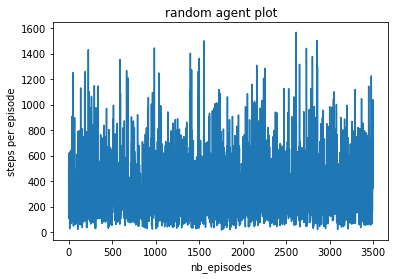

In [43]:
fig = plt.figure()
plt.plot(random_steps)
plt.title('random agent plot')
plt.xlabel('nb_episodes')
plt.ylabel('steps per episode')
fig.savefig("random_agent.png")

In [28]:
np.mean(random_steps)

331.9077142857143

In [15]:
min(random_steps)

16

In [23]:
trained_agent

In [24]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
joblib.dump(trained_agent,'neural_agent_'+timestamp+'.pkl', compress=True)
# train_data = joblib.load('ignore_simul2_20211203102304978989.pkl')

['neural_agent_20211206101816449750.pkl']

In [3]:
from ctfsql.agents.agent import NeuralAgent
agent = NeuralAgent()
agent.train()
run_episode(agent)
# trained_agent, steps, mean_scores = run_episode(agent)

  0%|          | 0/10 [00:00<?, ?it/s]

http://127.0.0.1/ctf_1/ctf_1_4.php


KeyError: 'lost'

In [4]:
9 % 1

0